In [19]:
import numpy as np
import pylab as pl
import pandas as pd
import datetime
from os import listdir
from os.path import isfile, join
import glob

%matplotlib inline

In [2]:
import getCTTdata
import CTTtoPandas
import importlib
importlib.reload(getCTTdata)
importlib.reload(CTTtoPandas)
metadata=getCTTdata.metadata_wairio

# Get data

In [85]:
# Initialise everything (run first time only!)
getCTTdata.getFiles(metadata,None)
_,date_deployed = getCTTdata.getStationId(metadata)
gpslist,ndlist,dlist=CTTtoPandas.getFileList(metadata['savepath'],datetime.datetime.strptime(date_deployed, "%Y-%m-%dT%H:%M:%S.000Z").date(),None)
gps,nodedata,data = CTTtoPandas.addData(None,None,None,gpslist,ndlist,dlist)
gps.sort_values(by=['gps at'],inplace=True)
data.sort_values(by=['Time'],inplace=True)
nodedata.sort_values(by=['Time'],inplace=True)
CTTtoPandas.saveDataFrames(metadata['savepath'],gps,nodedata,data)

In [68]:
# Update 
metadata=getCTTdata.metadata_zealandia
firstNewFile = getCTTdata.updateFiles(metadata)
gpslist,ndlist,dlist=CTTtoPandas.getFileList(metadata['savepath'],datetime.datetime.strptime(firstNewFile, "%Y-%m-%dT%H:%M:%S.000Z").date(),None)
gps,nodedata,data = CTTtoPandas.loadDataFrames(metadata['savepath'])
gps,nodedata,data = CTTtoPandas.addData(gps,nodedata,data,gpslist,ndlist,dlist)
gps.sort_values(by=['gps at'],inplace=True)
data.sort_values(by=['Time'],inplace=True)
nodedata.sort_values(by=['Time'],inplace=True)
CTTtoPandas.saveDataFrames(metadata['savepath'],gps,nodedata,data)

2023-06-18T09:53:56.000Z


In [263]:
# I used this one to get the first Zealandia data
#metadata=getCTTdata.metadata_zealandia
#getCTTdata.getFiles(metadata,"2023-08-29")
gpslist,ndlist,dlist=CTTtoPandas.getFileList(metadata['savepath'],datetime.datetime.strptime(firstNewFile, "%Y-%m-%dT%H:%M:%S.000Z").date(),None)
gps,nodedata,data = CTTtoPandas.addData(None,None,None,gpslist,ndlist,dlist)
gps.sort_values(by=['gps at'],inplace=True)
data.sort_values(by=['Time'],inplace=True)
nodedata.sort_values(by=['Time'],inplace=True)
CTTtoPandas.saveDataFrames(metadata['savepath'],gps,nodedata,data)

In [4]:
# This is how to load a particular timeframe and put it into a new set of dataframes
startdate = "2023-04-23"
enddate="2023-06-30"
gpslist,ndlist,dlist=CTTtoPandas.getFileList(metadata['savepath'],datetime.datetime.strptime(startdate, "%Y-%m-%d").date(),datetime.datetime.strptime(enddate, "%Y-%m-%d").date())
gps,nodedata,data = CTTtoPandas.addData(None,None,None,gpslist,ndlist,dlist)
gps.sort_values(by=['gps at'],inplace=True)
data.sort_values(by=['Time'],inplace=True)
nodedata.sort_values(by=['Time'],inplace=True)
CTTtoPandas.saveDataFrames(metadata['savepath'],gps,nodedata,data)

In [77]:
# This is how to add to a set of dataframes
startdate="2023-05-16"
gpslist,ndlist,dlist=CTTtoPandas.getFileList(metadata['savepath'],datetime.datetime.strptime(startdate, "%Y-%m-%d").date(),None)
gps,nodedata,data = CTTtoPandas.addData(gps,nodedata,data,gpslist,ndlist,dlist)
gps.sort_values(by=['gps at'],inplace=True)
data.sort_values(by=['Time'],inplace=True)
nodedata.sort_values(by=['Time'],inplace=True)

In [81]:
# In case you end up with some rows repeated
gps.drop_duplicates(inplace=True)

# GPS locations

Nodedata holds the data from each node about battery state, GPS fixes. 
We will use the GPS info, but that's about it. 
And we should probably just store those and then assume they don't change.

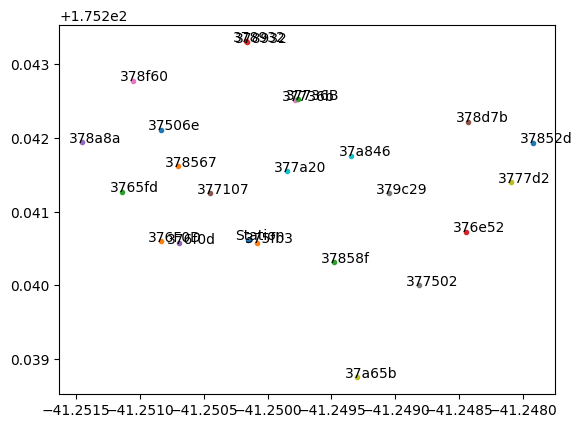

In [60]:
# Plot on map
# All node data
nodes = np.unique(nodedata.NodeId)
#for n in nodes:
#    pl.plot(nodedata[nodedata.NodeId==n].Latitude.to_numpy(),nodedata[nodedata.NodeId==n].Longitude.to_numpy(),'.')

# Plot single point at average (remove outliers?)
# Give name
# Get the average, don't check for outliers
a = nodedata[['NodeId','Latitude','Longitude']]
avg_locns = a.groupby(['NodeId']).mean().reset_index()

#avg_locns = gps.groupby(by=['NodeId']).mean().reset_index()
avg_locns.head()
nodes = np.unique(avg_locns.NodeId)

# The sensor station
# There are loads of fixes for it...
avg_locns.loc[len(avg_locns.index)] = ['Station',gps['mean lat'].mean(),gps['mean lng'].mean()]

pl.figure()
# WTF
#for n in nodes:
#    pl.plot(avg_locns[avg_locns.NodeId==n].Latitude,avg_locns[avg_locns.NodeId==n].Longitude,'.')
#    pl.text(avg_locns[avg_locns.NodeId==n].Latitude-0.0001,avg_locns[avg_locns.NodeId==n].Longitude,n)
for n in range(len(avg_locns)):
    pl.plot(avg_locns.iloc[n,1],avg_locns.iloc[n,2],'.')
    #print(avg_locns.iloc[n,1],avg_locns.iloc[n,2])
    pl.text(avg_locns.iloc[n,1]-0.0001,avg_locns.iloc[n,2],avg_locns.iloc[n,0])

# Compare with GPS -- I have 3, they look pretty good
g = []
g.append(["376F0D",-41.25083195976913,175.24059796705842])
g.append(["37736B",-41.249759998172522,175.24252396076918])
g.append(["378932",-41.250157970935106,175.24329501204193])

for n in g:
    pl.plot(n[1],n[2],'.')
    pl.text(n[1]-0.0001,n[2],n[0])


/home/marslast/.pyenv/versions/3.9.16/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


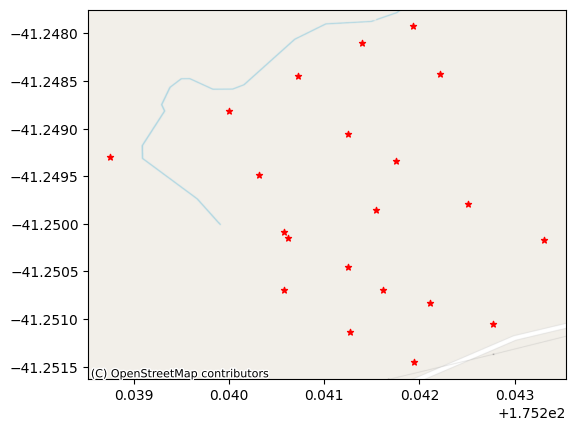

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(avg_locns.Longitude,avg_locns.Latitude)]
    
#ward = gpd.read_file(wardlink, bbox=None, mask=None, rows=None)
geo_df = gpd.GeoDataFrame(geometry = geometry)
geo_df.crs = {'init':"epsg:4326"}

ax = pl.figure().gca()

#for x,y,label in zip(avg_locns.Longitude,avg_locns.Latitude,avg_locns.NodeId):
#    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
    
# plot the polygon
#ax = ward.plot(alpha=0.35, color='#d66058', zorder=1)
# plot the boundary only (without fill), just uncomment
#ax = gpd.GeoSeries(ward.to_crs(epsg=3857)['geometry'].unary_union).boundary.plot(ax=ax, alpha=0.5, color="#ed2518",zorder=2)
#ax = gpd.GeoSeries(ward['geometry'].unary_union).boundary.plot(ax=ax, alpha=0.5, color="#ed2518",zorder=2)

# plot the marker
ax = geo_df.plot(ax = ax, markersize = 20, color = 'red',marker = '*', zorder=3)

ctx.add_basemap(ax, crs=geo_df.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# How to add labels? annotate line fails

In [21]:
# Save those average locations as the ones we use from now on
avg_locns.to_pickle(join(metadata['savepath'],'nodeLocations.pkl'))

# Beep data

Pretty much everything we want is in the data dataframe. 

In [29]:
# The station lines have NaN for the NodeId
data.NodeId.fillna('Station', inplace=True)

In [30]:
data.head()

,Time,RadioId,TagId,TagRSSI,NodeId,Validated
114184,2023-04-20 19:12:58,1,5207349E,-115,376e52,0
114182,2023-04-20 19:13:32,3,35DE57EF,-96,Station,0
114183,2023-04-20 19:15:09,5,A06E6A7A,-111,Station,0
114185,2023-04-20 19:19:50,3,F64A8E6B,-109,Station,0
114186,2023-05-11 23:21:02,1,3466612D,-109,376f0d,0


There are immense holes in this data and there are truck loads of misreads. For example, we have 10 tags that could have been out -- most weren't -- but look how many unique TagIds have been read:

In [24]:
print(len(np.unique(data[data.NodeId.notnull()].NodeId.astype(str))))
print(np.unique(data[data.NodeId.notnull()].NodeId.astype(str)))
print(len(np.unique(data[data.TagId.notnull()].TagId.astype(str))))
print(np.unique(data[data.TagId.notnull()].TagId.astype(str)))

20
['37506e' '375fb3' '3765fd' '376e52' '376f0d' '377107' '37736b' '377502'
 '3777d2' '377a20' '37852d' '378567' '37858f' '378932' '378a8a' '378d7b'
 '378f60' '379c29' '37a65b' '37a846']
16956
['00000000' '00005507' '0000661E' ... 'FFFF9EF8' 'FFFFD59E' 'FFFFFFFF']


In [25]:
# This and the next box do the same thing. Both are slow -- check which is better...
tags = np.unique(data.TagId.astype(str))
for i in tags:
    if len(np.where(data.TagId==i)[0]) > 100:
        print(i,len(np.where(data.TagId==i)[0]))

2A194B78 53681
2D2D6166 12672
332D7855 271492
332D78D5 584
332DF855 975
33AD7855 597
3466612D 58745
346661AD 171
3466E12D 155
34E6612D 157
4C664C66 15286
B32D7855 573
B466612D 163


KeyboardInterrupt: 

In [57]:
tags = np.unique(data.TagId)
for i in tags:
    x = data.TagId.value_counts()[i]
    if x > 100:
        print(i,x)

2A194B78 53391
2D2D6166 12571
332D7855 282437
332D78D5 581
332DF855 963
33AD7855 592
3466612D 48738
346661AD 131
3466E12D 128
34E6612D 128


KeyboardInterrupt: 

Tags Ellen put out (24/4/23 -- 19/05/23)
19523434
3466612D
66556134

Rat tags:
2A194B78 19/5/23 1530
332D7855 24/5/23 1500
19523434 21/6/23 1530

Stephen H
2D2D6166 1/6/23

Let's reduce the dataframe to those exactly for now -- later worth seeing if there are errors in detections

In [31]:
ourtags = ['19523434','3466612D','66556134','2A194B78','332D7855','19523434','2D2D6166']

In [32]:
beeps = data[data.TagId.isin(ourtags)]

In [33]:
beeps.head()

,Time,RadioId,TagId,TagRSSI,NodeId,Validated
114186,2023-05-11 23:21:02,1,3466612D,-109,376f0d,0
114203,2023-05-11 23:21:46,1,3466612D,-69,37858f,0
114204,2023-05-11 23:22:00,1,3466612D,-69,37858f,0
114205,2023-05-11 23:22:15,1,3466612D,-69,37858f,0
114227,2023-05-11 23:22:26,1,3466612D,-106,377502,0


In [34]:
# These are the tags that were detected -- 2 rats, 2 tests
detected = np.unique(beeps.TagId)
print(detected)
for i in detected:
    print(len(np.where(beeps==i)[0]))

['2A194B78' '2D2D6166' '332D7855' '3466612D']
53681
12672
271492
58745


In [52]:
# So there are a few misreads on each. Should we correct them?
from scipy.spatial.distance import hamming
x = list(np.unique(beeps.TagId)[2])
#0.125 is 1 character, 0.25 is 2 characters
for i in ['332D7855']: #tags:
    if hamming(list(i),x) < 0.26:
        print(i,x)

332D7855 ['3', '3', '2', 'D', '7', '8', '5', '5']


In [53]:
# Can hopefully do this more efficiently with apply()
for i in ['332D7855']: #ourtags:
    x = list(i)
    for j in range(np.shape(data)[0]):
        # This seems to be failing -- first test 
        if (data.TagId[j].count(i)>0) & (hamming(list(data.TagId[j]),x) > 0) &(hamming(list(data.TagId[j]),x) < 0.26):
            print(j,data.iloc[j,2],i, hamming(list(data.TagId[j]),x))
            data.iloc[j,2] = i


In [54]:
for istr in ['332D7855']: #ourtags:
    i = list(istr)
    data.TagId.apply(lambda x: istr if ((hamming(list(x),i) > 0) & (hamming(list(x),i) <0.26)) else x)

In [157]:
tags = np.unique(data.TagId)
len(tags)

16790

In [59]:
beeps.to_pickle(join(metadata['savepath'],'beeps.pkl'))

In [55]:
data.head()

,Time,RadioId,TagId,TagRSSI,NodeId,Validated
114184,2023-04-20 19:12:58,1,5207349E,-115,376e52,0
114182,2023-04-20 19:13:32,3,35DE57EF,-96,Station,0
114183,2023-04-20 19:15:09,5,A06E6A7A,-111,Station,0
114185,2023-04-20 19:19:50,3,332D7855,-109,Station,0
114186,2023-05-11 23:21:02,1,332D7855,-109,376f0d,0


In [56]:
print(data.TagId[8691],ourtags[1],hamming(list(data.TagId[8691]),list(ourtags[1])))

332D7855 3466612D 0.875


In [14]:
nodedata[nodedata.NodeId=='3765fd']

TypeError: Could not convert ['2023-04-20 19:12:092023-04-20 19:17:092023-04-20 19:22:092023-05-11 23:30:232023-05-11 23:40:242023-05-11 23:45:242023-05-12 00:00:252023-05-12 00:10:252023-05-12 00:15:262023-05-12 00:20:262023-05-12 00:25:262023-05-12 00:40:272023-05-12 00:55:282023-05-12 01:10:292023-05-12 01:20:302023-05-12 01:30:302023-05-12 02:05:322023-05-12 02:15:332023-05-12 02:20:332023-05-12 02:25:332023-05-12 02:30:342023-05-12 02:35:342023-05-12 02:40:342023-05-12 02:45:352023-05-12 02:50:352023-05-12 02:55:352023-05-12 03:00:362023-05-12 03:05:362023-05-12 03:10:362023-05-12 03:20:372023-05-12 03:50:392023-05-12 04:05:402023-05-12 04:10:402023-05-12 04:15:402023-05-12 04:20:402023-05-12 04:25:412023-05-12 04:30:412023-05-12 04:50:422023-05-12 04:55:432023-05-12 05:05:432023-05-12 05:30:452023-05-12 05:35:452023-05-12 05:40:452023-05-12 06:00:462023-05-12 06:05:472023-05-12 06:10:472023-05-12 06:15:472023-05-12 06:20:482023-05-12 06:25:482023-05-12 06:30:482023-05-12 06:35:492023-05-12 06:40:492023-05-12 06:45:492023-05-12 06:50:492023-05-12 06:55:502023-05-12 07:00:502023-05-12 07:05:502023-05-12 07:10:512023-05-12 07:15:512023-05-12 07:20:512023-05-12 07:25:522023-05-12 07:30:522023-05-12 07:50:532023-05-12 07:55:532023-05-12 08:00:542023-05-12 08:05:542023-05-12 08:10:542023-05-12 08:15:552023-05-12 08:20:552023-05-12 08:25:552023-05-12 08:30:552023-05-12 08:35:562023-05-12 08:40:562023-05-12 08:45:562023-05-12 08:50:572023-05-12 08:55:572023-05-12 09:00:572023-05-12 09:05:582023-05-12 09:10:582023-05-12 09:15:582023-05-12 09:20:582023-05-12 09:25:592023-05-12 09:30:592023-05-12 09:35:592023-05-12 09:41:002023-05-12 09:46:002023-05-12 09:51:002023-05-12 09:56:012023-05-12 10:01:012023-05-12 10:06:012023-05-12 10:11:012023-05-12 10:16:022023-05-12 10:21:022023-05-12 10:26:022023-05-12 10:31:032023-05-12 10:36:032023-05-12 10:41:032023-05-12 10:46:042023-05-12 10:51:042023-05-12 10:56:042023-05-12 11:01:042023-05-12 11:06:052023-05-12 11:11:052023-05-12 11:16:052023-05-12 11:21:062023-05-12 11:26:062023-05-12 11:31:062023-05-12 11:36:072023-05-12 11:41:072023-05-12 11:46:072023-05-12 11:51:072023-05-12 11:56:082023-05-12 12:01:082023-05-12 12:06:082023-05-12 12:11:092023-05-12 12:16:092023-05-12 12:21:092023-05-12 12:26:102023-05-12 12:31:102023-05-12 12:36:102023-05-12 12:41:102023-05-12 12:46:112023-05-12 12:51:112023-05-12 12:56:112023-05-12 13:06:122023-05-12 13:11:122023-05-12 13:16:132023-05-12 13:21:132023-05-12 13:26:132023-05-12 13:31:132023-05-12 13:36:142023-05-12 13:41:142023-05-12 13:46:142023-05-12 13:51:152023-05-12 13:56:152023-05-12 14:01:152023-05-12 14:06:162023-05-12 14:11:162023-05-12 14:16:162023-05-12 14:21:162023-05-12 14:26:172023-05-12 14:31:172023-05-12 14:36:172023-05-12 14:41:182023-05-12 14:46:182023-05-12 14:51:182023-05-12 14:56:182023-05-12 15:01:192023-05-12 15:06:192023-05-12 15:11:192023-05-12 15:16:202023-05-12 15:21:202023-05-12 15:26:202023-05-12 15:31:212023-05-12 15:36:212023-05-12 15:41:212023-05-12 15:46:212023-05-12 15:51:222023-05-12 15:56:222023-05-12 16:01:222023-05-12 16:06:232023-05-12 16:11:232023-05-12 16:16:232023-05-12 16:21:242023-05-12 16:26:242023-05-12 16:36:242023-05-12 16:41:252023-05-12 16:46:252023-05-12 16:51:252023-05-12 16:56:262023-05-12 17:01:262023-05-12 17:06:262023-05-12 17:11:272023-05-12 17:16:272023-05-12 17:21:272023-05-12 17:26:282023-05-12 17:31:282023-05-12 17:36:282023-05-12 17:41:282023-05-12 17:46:292023-05-12 17:51:292023-05-12 17:56:292023-05-12 18:01:302023-05-12 18:06:302023-05-12 18:11:302023-05-12 18:16:312023-05-12 18:21:312023-05-12 18:26:312023-05-12 18:31:312023-05-12 18:36:322023-05-12 18:41:322023-05-12 18:46:322023-05-12 18:51:332023-05-12 18:56:332023-05-12 19:01:332023-05-12 19:06:342023-05-12 19:11:342023-05-12 19:16:342023-05-12 19:21:342023-05-12 19:26:352023-05-12 19:31:352023-05-12 19:36:352023-05-12 19:41:362023-05-12 19:46:362023-05-12 19:51:362023-05-12 19:56:372023-05-12 20:01:372023-05-12 20:06:372023-05-12 20:11:372023-05-12 20:16:382023-05-12 20:21:382023-05-12 20:26:382023-05-12 20:31:392023-05-12 20:36:392023-05-12 20:41:392023-05-12 20:46:392023-05-12 20:51:402023-05-12 20:56:402023-05-12 21:01:402023-05-12 21:06:412023-05-12 21:11:412023-05-12 21:16:412023-05-12 21:21:422023-05-12 21:26:422023-05-12 21:31:422023-05-12 21:36:422023-05-12 21:41:432023-05-12 21:46:432023-05-12 21:51:432023-05-12 21:56:442023-05-12 22:01:442023-05-12 22:06:442023-05-12 22:11:452023-05-12 22:16:452023-05-12 22:21:452023-05-12 22:26:452023-05-12 22:31:462023-05-12 22:36:462023-05-12 22:41:462023-05-12 22:46:472023-05-12 22:51:472023-05-12 22:56:472023-05-12 23:01:482023-05-12 23:06:482023-05-12 23:11:482023-05-12 23:16:482023-05-12 23:21:492023-05-12 23:26:492023-05-12 23:31:492023-05-12 23:36:502023-05-12 23:41:502023-05-12 23:46:502023-05-12 23:51:512023-05-12 23:56:512023-05-13 00:01:512023-05-13 00:06:512023-05-13 00:11:522023-05-13 00:16:522023-05-13 00:21:522023-05-13 00:26:532023-05-13 00:31:532023-05-13 00:36:532023-05-13 00:41:542023-05-13 00:46:542023-05-13 00:51:542023-05-13 00:56:542023-05-13 01:01:552023-05-13 01:11:552023-05-13 01:16:562023-05-13 01:21:562023-05-13 01:26:562023-05-13 01:31:562023-05-13 01:36:572023-05-13 01:41:572023-05-13 01:46:572023-05-13 01:51:582023-05-13 01:56:582023-05-13 02:01:582023-05-13 02:06:592023-05-13 02:11:592023-05-13 02:16:592023-05-13 02:21:592023-05-13 02:27:002023-05-13 02:32:002023-05-13 02:37:002023-05-13 02:42:012023-05-13 02:47:012023-05-13 02:52:012023-05-13 02:57:022023-05-13 03:02:022023-05-13 03:07:022023-05-13 03:12:022023-05-13 03:17:032023-05-13 03:22:032023-05-13 03:27:032023-05-13 03:32:042023-05-13 03:37:042023-05-13 03:42:042023-05-13 03:47:052023-05-13 03:52:052023-05-13 03:57:052023-05-13 04:02:052023-05-13 04:07:062023-05-13 04:12:062023-05-13 04:17:062023-05-13 04:22:072023-05-13 04:27:072023-05-13 04:32:072023-05-13 04:37:082023-05-13 04:42:082023-05-13 04:47:082023-05-13 04:52:082023-05-13 04:57:092023-05-13 05:02:092023-05-13 05:07:092023-05-13 05:12:102023-05-13 05:17:102023-05-13 05:22:102023-05-13 05:27:112023-05-13 05:32:112023-05-13 05:37:112023-05-13 05:42:112023-05-13 05:47:122023-05-13 05:52:122023-05-13 05:57:122023-05-13 06:02:132023-05-13 06:07:132023-05-13 06:12:132023-05-13 06:17:142023-05-13 06:22:142023-05-13 06:27:142023-05-13 06:32:142023-05-13 06:37:152023-05-13 06:42:152023-05-13 06:47:152023-05-13 06:52:162023-05-13 06:57:162023-05-13 07:02:162023-05-13 07:07:172023-05-13 07:12:172023-05-13 07:17:172023-05-13 07:22:182023-05-13 07:27:182023-05-13 07:32:182023-05-13 07:37:182023-05-13 07:42:192023-05-13 07:47:192023-05-13 07:52:192023-05-13 07:57:202023-05-13 08:02:202023-05-13 08:07:202023-05-13 08:12:202023-05-13 08:17:212023-05-13 08:22:212023-05-13 08:27:212023-05-13 08:32:222023-05-13 08:37:222023-05-13 08:42:222023-05-13 08:47:232023-05-13 08:52:232023-05-13 08:57:232023-05-13 09:02:232023-05-13 09:07:242023-05-13 09:12:242023-05-13 09:17:242023-05-13 09:22:252023-05-13 09:27:252023-05-13 09:32:252023-05-13 09:37:262023-05-13 09:42:262023-05-13 09:47:262023-05-13 09:52:272023-05-13 09:57:272023-05-13 10:02:272023-05-13 10:07:272023-05-13 10:12:282023-05-13 10:17:282023-05-13 10:22:282023-05-13 10:27:292023-05-13 10:32:292023-05-13 10:37:292023-05-13 10:42:302023-05-13 10:47:302023-05-13 10:52:302023-05-13 10:57:302023-05-13 11:07:312023-05-13 11:12:312023-05-13 11:17:322023-05-13 11:22:322023-05-13 11:27:322023-05-13 11:32:332023-05-13 11:37:332023-05-13 11:42:332023-05-13 11:47:332023-05-13 11:52:342023-05-13 11:57:342023-05-13 12:02:342023-05-13 12:07:352023-05-13 12:12:352023-05-13 12:17:352023-05-13 12:22:362023-05-13 12:27:362023-05-13 12:32:362023-05-13 12:37:362023-05-13 12:42:372023-05-13 12:47:372023-05-13 12:52:372023-05-13 12:57:382023-05-13 13:07:382023-05-13 13:12:392023-05-13 13:17:392023-05-13 13:22:392023-05-13 13:27:392023-05-13 13:32:402023-05-13 13:37:402023-05-13 13:42:402023-05-13 13:47:412023-05-13 13:52:412023-05-13 13:57:412023-05-13 14:02:422023-05-13 14:07:422023-05-13 14:12:422023-05-13 14:17:422023-05-13 14:22:432023-05-13 14:27:432023-05-13 14:32:432023-05-13 14:37:442023-05-13 14:42:442023-05-13 14:47:442023-05-13 14:52:452023-05-13 14:57:452023-05-13 15:02:452023-05-13 15:07:452023-05-13 15:12:462023-05-13 15:17:462023-05-13 15:22:462023-05-13 15:27:472023-05-13 15:32:472023-05-13 15:37:472023-05-13 15:42:482023-05-13 15:47:482023-05-13 15:52:482023-05-13 15:57:492023-05-13 16:02:492023-05-13 16:07:492023-05-13 16:12:492023-05-13 16:17:502023-05-13 16:22:502023-05-13 16:27:502023-05-13 16:32:512023-05-13 16:37:512023-05-13 16:42:512023-05-13 16:47:522023-05-13 16:52:522023-05-13 16:57:522023-05-13 17:02:522023-05-13 17:07:532023-05-13 17:12:532023-05-13 17:17:532023-05-13 17:22:542023-05-13 17:27:542023-05-13 17:32:542023-05-13 17:37:552023-05-13 17:42:552023-05-13 17:47:552023-05-13 17:52:552023-05-13 17:57:562023-05-13 18:02:562023-05-13 18:07:562023-05-13 18:12:572023-05-13 18:17:572023-05-13 18:22:572023-05-13 18:27:582023-05-13 18:32:582023-05-13 18:37:582023-05-13 18:42:582023-05-13 18:47:592023-05-13 18:52:592023-05-13 18:57:592023-05-13 19:03:002023-05-13 19:08:002023-05-13 19:13:002023-05-13 19:18:012023-05-13 19:23:012023-05-13 19:28:012023-05-13 19:33:022023-05-13 19:38:022023-05-13 19:43:022023-05-13 19:48:022023-05-13 19:53:032023-05-13 19:58:032023-05-13 20:03:032023-05-13 20:08:042023-05-13 20:13:042023-05-13 20:18:042023-05-13 20:23:052023-05-13 20:28:052023-05-13 20:33:052023-05-13 20:38:052023-05-13 20:43:062023-05-13 20:48:062023-05-13 20:53:062023-05-13 20:58:072023-05-13 21:03:072023-05-13 21:08:072023-05-13 21:13:082023-05-13 21:18:082023-05-13 21:23:082023-05-13 21:28:082023-05-13 21:33:092023-05-13 21:38:092023-05-13 21:43:092023-05-13 21:48:102023-05-13 21:53:102023-05-13 21:58:102023-05-13 22:03:112023-05-13 22:08:112023-05-13 22:13:112023-05-13 22:18:112023-05-13 22:23:122023-05-13 22:28:122023-05-13 22:33:122023-05-13 22:38:132023-05-13 22:43:132023-05-13 22:48:132023-05-13 22:53:142023-05-13 22:58:142023-05-13 23:03:142023-05-13 23:08:142023-05-13 23:13:152023-05-13 23:18:152023-05-13 23:23:152023-05-13 23:28:162023-05-13 23:38:162023-05-13 23:43:172023-05-13 23:48:172023-05-13 23:53:172023-05-13 23:58:172023-05-14 00:03:182023-05-14 00:08:182023-05-14 00:13:182023-05-14 00:18:192023-05-14 00:23:192023-05-14 00:28:192023-05-14 00:33:192023-05-14 00:38:202023-05-14 00:43:202023-05-14 00:48:202023-05-14 00:53:212023-05-14 00:58:212023-05-14 01:03:212023-05-14 01:08:222023-05-14 01:13:222023-05-14 01:18:222023-05-14 01:23:222023-05-14 01:28:232023-05-14 01:33:232023-05-14 01:38:232023-05-14 01:43:242023-05-14 01:48:242023-05-14 01:53:242023-05-14 01:58:252023-05-14 02:03:252023-05-14 02:08:252023-05-14 02:13:252023-05-14 02:18:262023-05-14 02:23:262023-05-14 02:28:262023-05-14 02:33:272023-05-14 02:38:272023-05-14 02:43:272023-05-14 02:48:282023-05-14 02:53:282023-05-14 02:58:282023-05-14 03:03:282023-05-14 03:08:292023-05-14 03:13:292023-05-14 03:18:292023-05-14 03:23:302023-05-14 03:28:302023-05-14 03:33:302023-05-14 03:38:312023-05-14 03:43:312023-05-14 03:48:312023-05-14 03:53:312023-05-14 03:58:322023-05-14 04:03:322023-05-14 04:08:322023-05-14 04:13:332023-05-14 04:18:332023-05-14 04:23:332023-05-14 04:28:342023-05-14 04:33:342023-05-14 04:38:342023-05-14 04:43:342023-05-14 04:48:352023-05-14 04:53:352023-05-14 04:58:352023-05-14 05:03:362023-05-14 05:08:362023-05-14 05:13:362023-05-14 05:18:362023-05-14 05:23:372023-05-14 05:28:372023-05-14 05:33:372023-05-14 05:38:382023-05-14 05:43:382023-05-14 05:48:382023-05-14 05:53:392023-05-14 05:58:392023-05-14 06:03:392023-05-14 06:08:392023-05-14 06:13:402023-05-14 06:18:402023-05-14 06:28:412023-05-14 06:33:412023-05-14 06:38:412023-05-14 06:43:422023-05-14 06:48:422023-05-14 06:53:422023-05-14 06:58:422023-05-14 07:03:432023-05-14 07:08:432023-05-14 07:13:432023-05-14 07:18:442023-05-14 07:23:442023-05-14 07:28:442023-05-14 07:33:452023-05-14 07:38:452023-05-14 07:43:452023-05-14 07:48:452023-05-14 07:53:462023-05-14 07:58:462023-05-14 08:03:462023-05-14 08:08:472023-05-14 08:13:472023-05-14 08:18:472023-05-14 08:23:482023-05-14 08:28:482023-05-14 08:33:482023-05-14 08:38:482023-05-14 08:43:492023-05-14 08:48:492023-05-14 08:53:492023-05-14 08:58:502023-05-14 09:03:502023-05-14 09:08:502023-05-14 09:13:512023-05-14 09:18:512023-05-14 09:23:512023-05-14 09:28:512023-05-14 09:33:522023-05-14 09:38:522023-05-14 09:43:522023-05-14 09:48:532023-05-14 09:53:532023-05-14 09:58:532023-05-14 10:03:542023-05-14 10:13:542023-05-14 10:18:542023-05-14 10:23:552023-05-14 10:28:552023-05-14 10:33:552023-05-14 10:38:562023-05-14 10:43:562023-05-14 10:48:562023-05-14 10:53:572023-05-14 10:58:572023-05-14 11:03:572023-05-14 11:08:572023-05-14 11:13:582023-05-14 11:18:582023-05-14 11:23:582023-05-14 11:28:592023-05-14 11:33:592023-05-14 11:38:592023-05-14 11:44:002023-05-14 11:49:002023-05-14 11:54:002023-05-14 11:59:002023-05-14 12:04:012023-05-14 12:09:012023-05-14 12:14:012023-05-14 12:19:022023-05-14 12:24:022023-05-14 12:29:022023-05-14 12:34:032023-05-14 12:39:032023-05-14 12:44:032023-05-14 12:49:032023-05-14 12:54:042023-05-14 12:59:042023-05-14 13:04:042023-05-14 13:09:052023-05-14 13:14:052023-05-14 13:19:052023-05-14 13:24:062023-05-14 13:29:062023-05-14 13:34:062023-05-14 13:39:062023-05-14 13:44:072023-05-14 13:49:072023-05-14 13:54:072023-05-14 13:59:082023-05-14 14:04:082023-05-14 14:09:082023-05-14 14:14:092023-05-14 14:19:092023-05-14 14:24:092023-05-14 14:34:102023-05-14 14:39:102023-05-14 14:44:102023-05-14 14:49:112023-05-14 14:54:112023-05-14 14:59:112023-05-14 15:04:122023-05-14 15:09:122023-05-14 15:14:122023-05-14 15:19:122023-05-14 15:24:132023-05-14 15:29:132023-05-14 15:34:132023-05-14 15:39:142023-05-14 15:44:142023-05-14 15:49:142023-05-14 15:54:152023-05-14 15:59:152023-05-14 16:04:152023-05-14 16:09:152023-05-14 16:14:162023-05-14 16:19:162023-05-14 16:24:162023-05-14 16:29:172023-05-14 16:34:172023-05-14 16:39:352023-05-14 16:44:352023-05-14 16:49:362023-05-14 16:54:362023-05-14 16:59:362023-05-14 17:04:362023-05-14 17:09:372023-05-14 17:14:372023-05-14 17:19:372023-05-14 17:24:382023-05-14 17:29:382023-05-14 17:34:382023-05-14 17:39:392023-05-14 17:44:392023-05-14 17:49:392023-05-14 17:54:392023-05-14 17:59:402023-05-14 18:04:402023-05-14 18:09:402023-05-14 18:14:412023-05-14 18:19:412023-05-14 18:24:412023-05-14 18:29:422023-05-14 18:34:422023-05-14 18:39:422023-05-14 18:44:422023-05-14 18:49:432023-05-14 18:54:432023-05-14 18:59:432023-05-14 19:04:442023-05-14 19:09:442023-05-14 19:14:442023-05-14 19:19:452023-05-14 19:24:452023-05-14 19:30:092023-05-14 19:35:092023-05-14 19:40:092023-05-14 19:45:102023-05-14 19:50:102023-05-14 19:55:102023-05-14 20:00:112023-05-14 20:05:112023-05-14 20:10:112023-05-14 20:15:122023-05-14 20:20:122023-05-14 20:25:122023-05-14 20:30:122023-05-14 20:35:132023-05-14 20:40:132023-05-14 20:45:132023-05-14 20:50:142023-05-14 20:55:142023-05-14 21:00:142023-05-14 21:05:152023-05-14 21:10:152023-05-14 21:15:152023-05-14 21:20:152023-05-14 21:25:162023-05-14 21:30:162023-05-14 21:35:162023-05-14 21:40:172023-05-14 21:45:172023-05-14 21:50:172023-05-14 21:55:182023-05-14 22:00:182023-05-14 22:05:182023-05-14 22:10:182023-05-14 22:15:192023-05-14 22:20:192023-05-14 22:25:192023-05-14 22:30:202023-05-14 22:35:202023-05-14 22:40:202023-05-14 22:45:212023-05-14 22:50:212023-05-14 22:55:212023-05-14 23:00:212023-05-14 23:05:222023-05-14 23:10:222023-05-14 23:15:222023-05-14 23:20:232023-05-14 23:25:232023-05-14 23:30:232023-05-14 23:35:242023-05-14 23:40:242023-05-14 23:45:242023-05-14 23:50:242023-05-14 23:55:252023-05-15 00:00:252023-05-15 00:05:252023-05-15 00:10:262023-05-15 00:15:262023-05-15 00:20:262023-05-15 00:25:272023-05-15 00:30:272023-05-15 00:35:272023-05-15 00:40:272023-05-15 00:50:282023-05-15 00:55:282023-05-15 01:00:292023-05-15 01:05:292023-05-15 01:10:292023-05-15 01:15:292023-05-15 01:20:302023-05-15 01:25:302023-05-15 01:30:302023-05-15 01:35:312023-05-15 01:40:312023-05-15 01:45:312023-05-15 01:50:322023-05-15 01:55:322023-05-15 02:00:322023-05-15 02:05:322023-05-15 02:10:332023-05-15 02:15:332023-05-15 02:20:332023-05-15 02:25:342023-05-15 02:30:342023-05-15 02:35:342023-05-15 02:40:352023-05-15 02:45:352023-05-15 02:50:352023-05-15 02:55:352023-05-15 03:00:362023-05-15 03:05:362023-05-15 03:10:362023-05-15 03:15:372023-05-15 03:20:372023-05-15 03:25:372023-05-15 03:30:382023-05-15 03:35:382023-05-15 03:40:382023-05-15 03:45:382023-05-15 03:50:392023-05-15 03:55:392023-05-15 04:00:392023-05-15 04:05:402023-05-15 04:10:402023-05-15 04:15:402023-05-15 04:20:412023-05-15 04:25:412023-05-15 04:30:412023-05-15 04:35:412023-05-15 04:40:422023-05-15 04:45:422023-05-15 04:50:422023-05-15 04:55:432023-05-15 05:00:432023-05-15 05:05:432023-05-15 05:10:442023-05-15 05:15:442023-05-15 05:20:442023-05-15 05:25:442023-05-15 05:30:452023-05-15 05:35:452023-05-15 05:40:452023-05-15 05:45:462023-05-15 05:50:462023-05-15 05:55:462023-05-15 06:00:472023-05-15 06:05:472023-05-15 06:10:472023-05-15 06:15:472023-05-15 06:20:482023-05-15 06:30:482023-05-15 06:35:492023-05-15 06:40:492023-05-15 06:45:492023-05-15 06:50:502023-05-15 06:55:502023-05-15 07:00:502023-05-15 07:05:502023-05-15 07:10:512023-05-15 07:15:512023-05-15 07:20:512023-05-15 07:26:182023-05-15 07:31:182023-05-15 07:36:182023-05-15 07:41:192023-05-15 07:46:192023-05-15 07:51:192023-05-15 07:56:202023-05-15 08:01:202023-05-15 08:06:202023-05-15 08:11:202023-05-15 08:16:212023-05-15 08:21:212023-05-15 08:26:212023-05-15 08:31:222023-05-15 08:36:222023-05-15 08:41:222023-05-15 08:46:232023-05-15 08:51:232023-05-15 08:56:232023-05-15 09:01:232023-05-15 09:06:242023-05-15 09:11:242023-05-15 09:16:242023-05-15 09:21:252023-05-15 09:26:252023-05-15 09:31:252023-05-15 09:36:262023-05-15 09:41:262023-05-15 09:46:262023-05-15 09:51:262023-05-15 09:56:272023-05-15 10:01:272023-05-15 10:06:272023-05-15 10:11:282023-05-15 10:16:282023-05-15 10:21:282023-05-15 10:26:292023-05-15 10:31:292023-05-15 10:36:292023-05-15 10:41:292023-05-15 10:46:302023-05-15 10:51:302023-05-15 10:56:302023-05-15 11:01:312023-05-15 11:06:312023-05-15 11:11:312023-05-15 11:16:322023-05-15 11:21:322023-05-15 11:26:322023-05-15 11:31:322023-05-15 11:36:332023-05-15 11:41:332023-05-15 11:46:332023-05-15 11:51:342023-05-15 11:56:342023-05-15 12:01:342023-05-15 12:06:352023-05-15 12:11:352023-05-15 12:16:352023-05-15 12:21:352023-05-15 12:26:362023-05-15 12:31:362023-05-15 12:36:362023-05-15 12:41:372023-05-15 12:46:372023-05-15 12:51:372023-05-15 12:56:382023-05-15 13:01:382023-05-15 13:06:382023-05-15 13:11:382023-05-15 13:16:392023-05-15 13:21:392023-05-15 13:26:392023-05-15 13:31:402023-05-15 13:36:402023-05-15 13:41:402023-05-15 13:46:412023-05-15 13:51:412023-05-15 13:56:412023-05-15 14:01:412023-05-15 14:06:422023-05-15 14:11:422023-05-15 14:16:422023-05-15 14:21:432023-05-15 14:26:432023-05-15 14:31:432023-05-15 14:36:442023-05-15 14:41:442023-05-15 14:46:442023-05-15 14:51:442023-05-15 14:56:452023-05-15 15:01:452023-05-15 15:06:452023-05-15 15:11:462023-05-15 15:16:462023-05-15 15:21:462023-05-15 15:26:472023-05-15 15:31:472023-05-15 15:36:472023-05-15 15:41:472023-05-15 15:46:482023-05-15 15:51:482023-05-15 15:56:482023-05-15 16:01:492023-05-15 16:06:492023-05-15 16:11:492023-05-15 16:16:502023-05-15 16:21:502023-05-15 16:26:502023-05-15 16:31:502023-05-15 16:36:512023-05-15 16:41:512023-05-15 16:46:512023-05-15 16:51:522023-05-15 16:56:522023-05-15 17:01:522023-05-15 17:06:532023-05-15 17:11:532023-05-15 17:16:532023-05-15 17:21:532023-05-15 17:26:542023-05-15 17:31:542023-05-15 17:36:542023-05-15 17:41:552023-05-15 17:46:552023-05-15 17:51:552023-05-15 17:56:562023-05-15 18:01:562023-05-15 18:06:562023-05-15 18:11:562023-05-15 18:16:572023-05-15 18:21:572023-05-15 18:26:572023-05-15 18:31:582023-05-15 18:36:582023-05-15 18:41:582023-05-15 18:46:592023-05-15 18:51:592023-05-15 18:56:592023-05-15 19:01:592023-05-15 19:07:002023-05-15 19:12:002023-05-15 19:17:002023-05-15 19:22:012023-05-15 19:27:012023-05-15 19:32:012023-05-15 19:37:022023-05-15 19:42:022023-05-15 19:47:022023-05-15 19:52:022023-05-15 19:57:032023-05-15 20:02:032023-05-15 20:07:032023-05-15 20:12:042023-05-15 20:17:042023-05-15 20:22:042023-05-15 20:27:052023-05-15 20:37:052023-05-15 20:42:052023-05-15 20:47:062023-05-15 20:52:062023-05-15 20:57:062023-05-15 21:02:072023-05-15 21:07:072023-05-15 21:12:072023-05-15 21:17:082023-05-15 21:22:082023-05-15 21:27:082023-05-15 21:32:082023-05-15 21:37:092023-05-15 21:42:092023-05-15 21:47:092023-05-15 21:52:102023-05-15 21:57:102023-05-15 22:02:102023-05-15 22:07:112023-05-15 22:12:112023-05-15 22:17:112023-05-15 22:22:112023-05-15 22:27:122023-05-15 22:32:122023-05-15 22:37:122023-05-15 22:42:132023-05-15 22:47:132023-05-15 22:52:132023-05-15 22:57:142023-05-15 23:02:142023-05-15 23:07:142023-05-15 23:12:142023-05-15 23:17:152023-05-15 23:22:152023-05-15 23:27:152023-05-15 23:32:162023-05-15 23:37:162023-05-15 23:42:162023-05-15 23:47:172023-05-15 23:52:172023-05-15 23:57:172023-05-16 00:02:172023-05-16 00:07:182023-05-16 00:12:182023-05-16 00:17:182023-05-16 00:22:192023-05-16 00:27:192023-05-16 00:32:192023-05-16 00:37:202023-05-16 00:42:202023-05-16 00:47:202023-05-16 00:52:202023-05-16 00:57:212023-05-16 01:02:212023-05-16 01:07:212023-05-16 01:12:222023-05-16 01:17:222023-05-16 01:22:222023-05-16 01:27:222023-05-16 01:32:232023-05-16 01:37:232023-05-16 01:42:232023-05-16 01:47:242023-05-16 01:52:242023-05-16 01:57:242023-05-16 02:02:252023-05-16 02:07:252023-05-16 02:12:252023-05-16 02:17:262023-05-16 02:22:262023-05-16 02:27:262023-05-16 02:32:262023-05-16 02:42:272023-05-16 02:47:272023-05-16 02:52:282023-05-16 02:57:282023-05-16 03:02:282023-05-16 03:07:292023-05-16 03:12:292023-05-16 03:17:292023-05-16 03:22:292023-05-16 03:27:302023-05-16 03:32:302023-05-16 03:37:302023-05-16 03:42:312023-05-16 03:47:312023-05-16 03:52:312023-05-16 03:57:312023-05-16 04:02:322023-05-16 04:07:322023-05-16 04:12:322023-05-16 04:17:332023-05-16 04:22:332023-05-16 04:27:332023-05-16 04:32:342023-05-16 04:37:342023-05-16 04:42:342023-05-16 04:47:342023-05-16 04:52:352023-05-16 04:57:352023-05-16 05:02:352023-05-16 05:07:362023-05-16 05:12:362023-05-16 05:17:362023-05-16 05:22:372023-05-16 05:27:372023-05-16 05:32:372023-05-16 05:37:372023-05-16 05:42:382023-05-16 05:47:382023-05-16 05:52:382023-05-16 05:57:392023-05-16 06:02:392023-05-16 06:12:402023-05-16 06:17:402023-05-16 06:22:402023-05-16 06:27:402023-05-16 06:32:412023-05-16 06:37:412023-05-16 06:42:412023-05-16 06:47:422023-05-16 06:52:422023-05-16 06:57:422023-05-16 07:02:432023-05-16 07:07:432023-05-16 07:12:432023-05-16 07:17:432023-05-16 07:22:442023-05-16 07:27:442023-05-16 07:32:442023-05-16 07:37:452023-05-16 07:42:452023-05-16 07:47:452023-05-16 07:52:462023-05-16 07:57:462023-05-16 08:02:462023-05-16 08:07:472023-05-16 08:12:472023-05-16 08:17:472023-05-16 08:22:472023-05-16 08:27:482023-05-16 08:32:482023-05-16 08:37:482023-05-16 08:42:492023-05-16 08:47:492023-05-16 08:52:492023-05-16 08:57:492023-05-16 09:02:502023-05-16 09:07:502023-05-16 09:12:502023-05-16 09:17:512023-05-16 09:22:512023-05-16 09:27:512023-05-16 09:32:522023-05-16 09:37:522023-05-16 09:42:522023-05-16 09:47:522023-05-16 09:52:532023-05-16 09:57:532023-05-16 10:02:532023-05-16 10:07:542023-05-16 10:12:542023-05-16 10:17:542023-05-16 10:22:552023-05-16 10:27:552023-05-16 10:32:552023-05-16 10:37:562023-05-16 10:42:562023-05-16 10:47:562023-05-16 10:52:562023-05-16 10:57:572023-05-16 11:02:572023-05-16 11:07:572023-05-16 11:12:582023-05-16 11:17:582023-05-16 11:22:582023-05-16 11:27:592023-05-16 11:32:592023-05-16 11:37:592023-05-16 11:42:592023-05-16 11:48:002023-05-16 11:53:002023-05-16 11:58:002023-05-16 12:03:012023-05-16 12:08:012023-05-16 12:13:012023-05-16 12:18:022023-05-16 12:23:022023-05-16 12:28:022023-05-16 12:33:022023-05-16 12:38:032023-05-16 12:43:032023-05-16 12:48:032023-05-16 12:53:042023-05-16 12:58:042023-05-16 13:03:042023-05-16 13:08:052023-05-16 13:13:052023-05-16 13:18:052023-05-16 13:23:052023-05-16 13:28:062023-05-16 13:33:062023-05-16 13:38:062023-05-16 13:43:072023-05-16 13:48:072023-05-16 13:53:072023-05-16 13:58:082023-05-16 14:03:082023-05-16 14:08:082023-05-16 14:13:082023-05-16 14:18:092023-05-16 14:23:092023-05-16 14:28:092023-05-16 14:33:102023-05-16 14:38:102023-05-16 14:43:102023-05-16 14:48:112023-05-16 14:53:112023-05-16 14:58:112023-05-16 15:03:112023-05-16 15:08:122023-05-16 15:13:122023-05-16 15:18:122023-05-16 15:23:132023-05-16 15:28:132023-05-16 15:33:132023-05-16 15:38:142023-05-16 15:43:142023-05-16 15:48:142023-05-16 15:53:142023-05-16 15:58:152023-05-16 16:03:152023-05-16 16:08:152023-05-16 16:13:162023-05-16 16:18:162023-05-16 16:23:162023-05-16 16:28:172023-05-16 16:33:172023-05-16 16:38:172023-05-16 16:43:182023-05-16 16:48:182023-05-16 16:53:182023-05-16 16:58:182023-05-16 17:03:192023-05-16 17:08:192023-05-16 17:13:192023-05-16 17:18:202023-05-16 17:23:202023-05-16 17:33:212023-05-16 17:38:212023-05-16 17:43:212023-05-16 17:48:212023-05-16 17:53:222023-05-16 17:58:222023-05-16 18:03:222023-05-16 18:08:232023-05-16 18:13:232023-05-16 18:18:232023-05-16 18:23:242023-05-16 18:28:242023-05-16 18:33:242023-05-16 18:38:242023-05-16 18:43:252023-05-16 18:48:252023-05-16 18:53:252023-05-16 18:58:262023-05-16 19:03:262023-05-16 19:09:172023-05-16 19:14:172023-05-16 19:19:172023-05-16 19:24:182023-05-16 19:29:182023-05-16 19:34:182023-05-16 19:39:192023-05-16 19:44:192023-05-16 19:49:192023-05-16 19:54:202023-05-16 19:59:202023-05-16 20:04:202023-05-16 20:09:202023-05-16 20:14:212023-05-16 20:19:212023-05-16 20:24:212023-05-16 20:29:222023-05-16 20:34:222023-05-16 20:39:222023-05-16 20:44:232023-05-16 20:49:232023-05-16 20:54:232023-05-16 20:59:232023-05-16 21:04:242023-05-16 21:09:242023-05-16 21:14:242023-05-16 21:19:252023-05-16 21:24:252023-05-16 21:29:252023-05-16 21:34:262023-05-16 21:39:262023-05-16 21:44:262023-05-16 21:49:262023-05-16 21:54:272023-05-16 21:59:272023-05-16 22:04:272023-05-16 22:09:282023-05-16 22:14:282023-05-16 22:19:282023-05-16 22:24:292023-05-16 22:29:292023-05-16 22:34:292023-05-16 22:39:292023-05-16 22:44:302023-05-16 22:49:302023-05-16 22:59:312023-05-16 23:04:312023-05-16 23:09:312023-05-16 23:14:322023-05-16 23:19:322023-05-16 23:24:322023-05-16 23:29:322023-05-16 23:34:332023-05-16 23:39:332023-05-16 23:44:332023-05-16 23:49:342023-05-16 23:54:342023-05-16 23:59:342023-05-17 00:04:342023-05-17 00:09:352023-05-17 00:14:352023-05-17 00:19:352023-05-17 00:24:362023-05-17 00:29:362023-05-17 00:34:362023-05-17 00:39:372023-05-17 00:44:372023-05-17 00:49:372023-05-17 00:54:372023-05-17 00:59:382023-05-17 01:04:382023-05-17 01:09:382023-05-17 01:14:392023-05-17 01:19:392023-05-17 01:24:392023-05-17 01:29:402023-05-17 01:34:402023-05-17 01:39:402023-05-17 01:44:402023-05-17 01:49:412023-05-17 01:54:412023-05-17 01:59:412023-05-17 02:04:422023-05-17 02:09:422023-05-17 02:14:422023-05-17 02:19:432023-05-17 02:24:432023-05-17 02:29:432023-05-17 02:34:432023-05-17 02:39:442023-05-17 02:44:442023-05-17 02:49:442023-05-17 02:54:452023-05-17 02:59:452023-05-17 03:04:452023-05-17 03:09:462023-05-17 03:14:462023-05-17 03:19:462023-05-17 03:24:462023-05-17 03:34:472023-05-17 03:39:472023-05-17 03:44:482023-05-17 03:49:482023-05-17 03:54:482023-05-17 03:59:492023-05-17 04:04:492023-05-17 04:09:492023-05-17 04:14:492023-05-17 04:19:502023-05-17 04:24:502023-05-17 04:29:502023-05-17 04:34:512023-05-17 04:39:512023-05-17 04:44:512023-05-17 04:49:522023-05-17 04:54:522023-05-17 04:59:522023-05-17 05:04:522023-05-17 05:09:532023-05-17 05:14:532023-05-17 05:19:532023-05-17 05:24:542023-05-17 05:29:542023-05-17 05:34:542023-05-17 05:39:552023-05-17 05:44:552023-05-17 05:49:552023-05-17 05:54:562023-05-17 05:59:562023-05-17 06:04:562023-05-17 06:09:562023-05-17 06:14:572023-05-17 06:19:572023-05-17 06:24:572023-05-17 06:29:582023-05-17 06:34:582023-05-17 06:39:582023-05-17 06:44:582023-05-17 06:49:592023-05-17 06:54:592023-05-17 06:59:592023-05-17 07:05:002023-05-17 07:10:002023-05-17 07:15:002023-05-17 07:20:002023-05-17 07:25:012023-05-17 07:30:012023-05-17 07:35:012023-05-17 07:40:022023-05-17 07:45:022023-05-17 07:50:022023-05-17 07:55:032023-05-17 08:00:032023-05-17 08:05:032023-05-17 08:10:032023-05-17 08:15:042023-05-17 08:20:042023-05-17 08:25:042023-05-17 08:30:052023-05-17 08:35:052023-05-17 08:40:052023-05-17 08:45:062023-05-17 08:50:062023-05-17 08:55:062023-05-17 09:00:062023-05-17 09:05:072023-05-17 09:10:072023-05-17 09:15:072023-05-17 09:20:082023-05-17 09:25:082023-05-17 09:30:082023-05-17 09:35:092023-05-17 09:40:092023-05-17 09:45:092023-05-17 09:50:092023-05-17 09:55:102023-05-17 10:00:102023-05-17 10:05:102023-05-17 10:10:112023-05-17 10:15:112023-05-17 10:20:112023-05-17 10:25:122023-05-17 10:30:122023-05-17 10:35:122023-05-17 10:40:122023-05-17 10:45:132023-05-17 10:50:132023-05-17 10:55:132023-05-17 11:00:142023-05-17 11:05:142023-05-17 11:10:142023-05-17 11:20:152023-05-17 11:25:152023-05-17 11:30:152023-05-17 11:35:162023-05-17 11:40:162023-05-17 11:45:162023-05-17 11:50:172023-05-17 11:55:172023-05-17 12:00:172023-05-17 12:05:182023-05-17 12:10:182023-05-17 12:15:182023-05-17 12:20:182023-05-17 12:25:192023-05-17 12:30:192023-05-17 12:35:192023-05-17 12:40:202023-05-17 12:45:202023-05-17 12:50:202023-05-17 12:55:212023-05-17 13:00:212023-05-17 13:05:212023-05-17 13:10:212023-05-17 13:15:222023-05-17 13:20:222023-05-17 13:25:222023-05-17 13:30:232023-05-17 13:35:232023-05-17 13:40:242023-05-17 13:45:242023-05-17 13:50:242023-05-17 13:55:242023-05-17 14:00:242023-05-17 14:05:252023-05-17 14:10:252023-05-17 14:15:252023-05-17 14:20:262023-05-17 14:25:262023-05-17 14:30:262023-05-17 14:35:272023-05-17 14:40:272023-05-17 14:45:272023-05-17 14:50:272023-05-17 14:55:282023-05-17 15:00:282023-05-17 15:05:282023-05-17 15:10:292023-05-17 15:15:292023-05-17 15:20:292023-05-17 15:25:302023-05-17 15:30:302023-05-17 15:35:302023-05-17 15:40:312023-05-17 15:45:312023-05-17 15:50:312023-05-17 15:55:322023-05-17 16:00:322023-05-17 16:05:322023-05-17 16:10:322023-05-17 16:15:332023-05-17 16:20:332023-05-17 16:25:332023-05-17 16:30:342023-05-17 16:35:342023-05-17 16:40:342023-05-17 16:45:352023-05-17 16:50:352023-05-17 16:55:352023-05-17 17:00:352023-05-17 17:05:362023-05-17 17:10:362023-05-17 17:15:362023-05-17 17:20:372023-05-17 17:25:372023-05-17 17:30:372023-05-17 17:35:372023-05-17 17:40:382023-05-17 17:45:382023-05-17 17:50:382023-05-17 17:55:392023-05-17 18:00:392023-05-17 18:05:392023-05-17 18:10:402023-05-17 18:15:402023-05-17 18:20:402023-05-17 18:25:412023-05-17 18:30:412023-05-17 18:35:412023-05-17 18:40:412023-05-17 18:45:422023-05-17 18:50:422023-05-17 18:55:422023-05-17 19:00:432023-05-17 19:05:432023-05-17 19:10:432023-05-17 19:15:442023-05-17 19:20:442023-05-17 19:25:442023-05-17 19:30:452023-05-17 19:35:452023-05-17 19:40:452023-05-17 19:45:452023-05-17 19:50:462023-05-17 19:55:462023-05-17 20:00:462023-05-17 20:05:462023-05-17 20:10:472023-05-17 20:15:472023-05-17 20:20:472023-05-17 20:25:482023-05-17 20:30:482023-05-17 20:35:482023-05-17 20:40:492023-05-17 20:45:492023-05-17 20:50:492023-05-17 20:55:502023-05-17 21:00:502023-05-17 21:05:502023-05-17 21:10:512023-05-17 21:15:512023-05-17 21:20:512023-05-17 21:25:512023-05-17 21:30:522023-05-17 21:35:522023-05-17 21:40:522023-05-17 21:45:532023-05-17 21:50:532023-05-17 21:55:532023-05-17 22:00:532023-05-17 22:05:542023-05-17 22:10:542023-05-17 22:15:542023-05-17 22:20:552023-05-17 22:25:552023-05-17 22:30:552023-05-17 22:35:562023-05-17 22:40:562023-05-17 22:45:562023-05-17 22:50:562023-05-17 22:55:572023-05-17 23:05:572023-05-17 23:10:582023-05-17 23:15:582023-05-17 23:20:582023-05-17 23:25:592023-05-17 23:30:592023-05-17 23:35:592023-05-17 23:40:592023-05-17 23:46:002023-05-17 23:51:002023-05-17 23:56:002023-05-18 00:01:012023-05-18 00:06:012023-05-18 00:11:012023-05-18 00:16:022023-05-18 00:21:022023-05-18 00:26:022023-05-18 00:31:022023-05-18 00:36:032023-05-18 00:41:032023-05-18 00:46:032023-05-18 00:51:042023-05-18 00:56:042023-05-18 01:01:042023-05-18 01:06:052023-05-18 01:11:052023-05-18 01:16:052023-05-18 01:21:052023-05-18 01:26:062023-05-18 01:31:062023-05-18 01:36:062023-05-18 01:41:072023-05-18 01:46:072023-05-18 01:51:072023-05-18 01:56:072023-05-18 02:01:082023-05-18 02:06:082023-05-18 02:11:082023-05-18 02:16:092023-05-18 02:21:092023-05-18 02:26:092023-05-18 02:31:102023-05-18 02:36:102023-05-18 02:41:102023-05-18 02:46:112023-05-18 02:51:112023-05-18 02:56:112023-05-18 03:06:122023-05-18 03:11:122023-05-18 03:16:122023-05-18 03:21:132023-05-18 03:26:132023-05-18 03:31:132023-05-18 03:36:142023-05-18 03:41:142023-05-18 03:46:142023-05-18 03:51:142023-05-18 03:56:152023-05-18 04:01:152023-05-18 04:06:152023-05-18 04:11:162023-05-18 04:16:162023-05-18 04:21:162023-05-18 04:26:162023-05-18 04:31:172023-05-18 04:36:172023-05-18 04:41:172023-05-18 04:46:182023-05-18 04:51:182023-05-18 04:56:182023-05-18 05:01:192023-05-18 05:06:192023-05-18 05:11:192023-05-18 05:16:202023-05-18 05:21:202023-05-18 05:26:202023-05-18 05:31:202023-05-18 05:36:212023-05-18 05:41:212023-05-18 05:46:212023-05-18 05:51:222023-05-18 05:56:222023-05-18 06:01:222023-05-18 06:06:232023-05-18 06:11:232023-05-18 06:16:232023-05-18 06:21:232023-05-18 06:26:242023-05-18 06:31:242023-05-18 06:36:242023-05-18 06:41:252023-05-18 06:46:252023-05-18 06:51:252023-05-18 06:56:252023-05-18 07:01:262023-05-18 07:06:262023-05-18 07:11:262023-05-18 07:16:272023-05-18 07:21:272023-05-18 07:26:272023-05-18 07:31:282023-05-18 07:36:282023-05-18 07:41:282023-05-18 07:46:292023-05-18 07:56:292023-05-18 08:01:292023-05-18 08:06:302023-05-18 08:11:302023-05-18 08:16:302023-05-18 08:21:312023-05-18 08:26:312023-05-18 08:31:312023-05-18 08:36:322023-05-18 08:41:322023-05-18 08:46:322023-05-18 08:51:322023-05-18 08:56:332023-05-18 09:01:332023-05-18 09:06:332023-05-18 09:11:332023-05-18 09:16:342023-05-18 09:21:342023-05-18 09:26:342023-05-18 09:31:352023-05-18 09:36:352023-05-18 09:41:352023-05-18 09:46:362023-05-18 09:51:362023-05-18 09:56:362023-05-18 10:01:362023-05-18 10:06:372023-05-18 10:11:372023-05-18 10:16:372023-05-18 10:21:382023-05-18 10:26:382023-05-18 10:31:382023-05-18 10:36:392023-05-18 10:41:392023-05-18 10:46:392023-05-18 10:56:402023-05-18 11:01:402023-05-18 11:06:402023-05-18 11:11:412023-05-18 11:16:412023-05-18 11:21:412023-05-18 11:26:422023-05-18 11:31:422023-05-18 11:36:422023-05-18 11:41:422023-05-18 11:46:432023-05-18 11:51:432023-05-18 11:56:432023-05-18 12:01:442023-05-18 12:06:442023-05-18 12:11:442023-05-18 12:16:452023-05-18 12:21:452023-05-18 12:26:452023-05-18 12:31:452023-05-18 12:36:462023-05-18 12:41:462023-05-18 12:46:462023-05-18 12:51:472023-05-18 12:56:472023-05-18 13:01:472023-05-18 13:06:482023-05-18 13:11:482023-05-18 13:16:482023-05-18 13:21:492023-05-18 13:26:492023-05-18 13:31:492023-05-18 13:36:502023-05-18 13:41:502023-05-18 13:46:502023-05-18 13:51:502023-05-18 13:56:512023-05-18 14:01:512023-05-18 14:06:512023-05-18 14:11:522023-05-18 14:16:522023-05-18 14:21:522023-05-18 14:26:532023-05-18 14:31:532023-05-18 14:36:532023-05-18 14:41:532023-05-18 14:46:542023-05-18 14:51:542023-05-18 14:56:542023-05-18 15:01:552023-05-18 15:06:552023-05-18 15:11:552023-05-18 15:16:562023-05-18 15:21:562023-05-18 15:26:562023-05-18 15:31:562023-05-18 15:36:572023-05-18 15:41:572023-05-18 15:46:572023-05-18 15:51:582023-05-18 15:56:582023-05-18 16:01:582023-05-18 16:06:592023-05-18 16:11:592023-05-18 16:16:592023-05-18 16:21:592023-05-18 16:27:002023-05-18 16:32:002023-05-18 16:37:002023-05-18 16:42:002023-05-18 16:47:012023-05-18 16:52:012023-05-18 16:57:012023-05-18 17:02:022023-05-18 17:07:022023-05-18 17:12:022023-05-18 17:17:032023-05-18 17:22:032023-05-18 17:27:032023-05-18 17:32:042023-05-18 17:37:042023-05-18 17:42:042023-05-18 17:47:052023-05-18 17:52:052023-05-18 17:57:052023-05-18 18:02:052023-05-18 18:07:062023-05-18 18:12:062023-05-18 18:17:062023-05-18 18:22:072023-05-18 18:27:072023-05-18 18:32:072023-05-18 18:37:072023-05-18 18:42:082023-05-18 18:47:082023-05-18 18:52:082023-05-18 18:57:092023-05-18 19:02:092023-05-18 19:07:092023-05-18 19:12:102023-05-18 19:17:102023-05-18 19:22:102023-05-18 19:27:112023-05-18 19:32:112023-05-18 19:37:112023-05-18 19:42:112023-05-18 19:47:122023-05-18 19:52:122023-05-18 19:57:122023-05-18 20:02:132023-05-18 20:07:132023-05-18 20:12:132023-05-18 20:17:132023-05-18 20:22:142023-05-18 20:27:142023-05-18 20:32:142023-05-18 20:37:152023-05-18 20:42:152023-05-18 20:47:152023-05-18 20:52:162023-05-18 20:57:162023-05-18 21:02:162023-05-18 21:07:172023-05-18 21:12:172023-05-18 21:17:172023-05-18 21:22:172023-05-18 21:27:182023-05-18 21:32:182023-05-18 21:37:182023-05-18 21:42:192023-05-18 21:52:192023-05-18 21:57:202023-05-18 22:02:202023-05-18 22:07:202023-05-18 22:12:202023-05-18 22:17:212023-05-18 22:22:212023-05-18 22:27:212023-05-18 22:32:222023-05-18 22:37:222023-05-18 22:42:222023-05-18 22:47:232023-05-18 22:52:232023-05-18 22:57:232023-05-18 23:02:232023-05-18 23:07:242023-05-18 23:12:242023-05-18 23:17:242023-05-18 23:22:252023-05-18 23:27:252023-05-18 23:32:252023-05-18 23:37:262023-05-18 23:42:262023-05-18 23:47:262023-05-18 23:52:262023-05-18 23:57:272023-05-19 00:02:272023-05-19 00:07:272023-05-19 00:12:282023-05-19 00:17:282023-05-19 00:22:282023-05-19 00:27:282023-05-19 00:32:292023-05-19 00:37:292023-05-19 00:42:292023-05-19 00:47:302023-05-19 00:52:302023-05-19 00:57:302023-05-19 01:02:312023-05-19 01:07:312023-05-19 01:12:312023-05-19 01:17:322023-05-19 01:22:322023-05-19 01:27:322023-05-19 01:32:322023-05-19 01:37:332023-05-19 01:42:332023-05-19 01:47:332023-05-19 01:52:332023-05-19 01:57:342023-05-19 02:02:342023-05-19 02:07:342023-05-19 02:12:352023-05-19 02:17:352023-05-19 02:22:352023-05-19 02:27:362023-05-19 02:32:362023-05-19 02:37:362023-05-19 02:42:372023-05-19 02:47:372023-05-19 02:52:372023-05-19 02:57:372023-05-19 03:02:382023-05-19 03:07:382023-05-19 03:12:382023-05-19 03:17:392023-05-19 03:22:392023-05-19 03:27:392023-05-19 03:32:402023-05-19 03:37:402023-05-19 03:42:402023-05-19 03:47:402023-05-19 03:52:412023-05-19 03:57:412023-05-19 04:02:412023-05-19 04:07:422023-05-19 04:12:422023-05-19 04:17:422023-05-19 04:22:432023-05-19 04:27:432023-05-19 04:32:432023-05-19 04:37:432023-05-19 04:42:442023-05-19 04:47:442023-05-19 04:52:442023-05-19 04:57:452023-05-19 05:02:452023-05-19 05:07:452023-05-19 05:12:462023-05-19 05:17:462023-05-19 05:22:462023-05-19 05:27:472023-05-19 05:32:472023-05-19 05:37:472023-05-19 05:42:472023-05-19 05:47:482023-05-19 05:52:482023-05-19 05:57:482023-05-19 06:02:492023-05-19 06:07:492023-05-19 06:12:492023-05-19 06:17:502023-05-19 06:22:502023-05-19 06:27:502023-05-19 06:32:512023-05-19 06:37:512023-05-19 06:42:512023-05-19 06:47:512023-05-19 06:52:522023-05-19 06:57:522023-05-19 07:02:522023-05-19 07:07:532023-05-19 07:12:532023-05-19 07:17:532023-05-19 07:22:542023-05-19 07:27:542023-05-19 07:32:542023-05-19 07:37:542023-05-19 07:42:552023-05-19 07:47:552023-05-19 07:52:552023-05-19 07:57:552023-05-19 08:02:562023-05-19 08:07:562023-05-19 08:12:562023-05-19 08:22:572023-05-19 08:27:572023-05-19 08:32:582023-05-19 08:37:582023-05-19 08:42:582023-05-19 08:47:592023-05-19 08:52:592023-05-19 08:57:592023-05-19 09:03:002023-05-19 09:13:002023-05-19 09:18:002023-05-19 09:23:062023-05-19 09:28:062023-05-19 09:33:072023-05-19 09:38:072023-05-19 09:43:072023-05-19 09:48:082023-05-19 09:53:082023-05-19 09:58:082023-05-19 10:03:092023-05-19 10:08:092023-05-19 10:13:092023-05-19 10:18:102023-05-19 10:23:102023-05-19 10:28:102023-05-19 10:33:102023-05-19 10:38:112023-05-19 10:43:112023-05-19 10:48:112023-05-19 10:53:122023-05-19 10:58:122023-05-19 11:03:122023-05-19 11:08:122023-05-19 11:13:132023-05-19 11:18:132023-05-19 11:23:132023-05-19 11:28:142023-05-19 11:33:142023-05-19 11:38:142023-05-19 11:43:152023-05-19 11:48:152023-05-19 11:53:152023-05-19 11:58:152023-05-19 12:03:162023-05-19 12:09:182023-05-19 12:14:182023-05-19 12:19:182023-05-19 12:24:182023-05-19 12:29:192023-05-19 12:34:192023-05-19 12:39:192023-05-19 12:44:202023-05-19 12:49:202023-05-19 12:54:202023-05-19 12:59:212023-05-19 13:04:212023-05-19 13:09:212023-05-19 13:14:222023-05-19 13:19:222023-05-19 13:24:222023-05-19 13:29:222023-05-19 13:34:232023-05-19 13:39:232023-05-19 13:44:232023-05-19 13:49:242023-05-19 13:54:242023-05-19 13:59:242023-05-19 14:04:252023-05-19 14:09:252023-05-19 14:14:252023-05-19 14:19:252023-05-19 14:24:262023-05-19 14:29:262023-05-19 14:34:262023-05-19 14:39:272023-05-19 14:44:272023-05-19 14:49:272023-05-19 14:54:282023-05-19 14:59:282023-05-19 15:04:282023-05-19 15:09:282023-05-19 15:14:292023-05-19 15:19:292023-05-19 15:24:292023-05-19 15:29:302023-05-19 15:34:302023-05-19 15:39:302023-05-19 15:44:312023-05-19 15:49:312023-05-19 15:54:312023-05-19 15:59:322023-05-19 16:04:322023-05-19 16:09:322023-05-19 16:14:332023-05-19 16:19:332023-05-19 16:24:332023-05-19 16:29:332023-05-19 16:34:342023-05-19 16:39:342023-05-19 16:44:342023-05-19 16:49:352023-05-19 16:54:352023-05-19 16:59:352023-05-19 17:04:362023-05-19 17:09:362023-05-19 17:14:362023-05-19 17:19:362023-05-19 17:24:372023-05-19 17:29:372023-05-19 17:34:372023-05-19 17:39:382023-05-19 17:44:382023-05-19 17:49:382023-05-19 17:54:382023-05-19 17:59:392023-05-19 18:04:392023-05-19 18:09:392023-05-19 18:14:402023-05-19 18:19:402023-05-19 18:24:402023-05-19 18:29:412023-05-19 18:34:412023-05-19 18:39:412023-05-19 18:44:422023-05-19 18:49:422023-05-19 18:54:422023-05-19 18:59:422023-05-19 19:04:432023-05-19 19:09:432023-05-19 19:14:432023-05-19 19:19:442023-05-19 19:24:442023-05-19 19:29:442023-05-19 19:34:452023-05-19 19:39:452023-05-19 19:44:452023-05-19 19:49:452023-05-19 19:54:462023-05-19 19:59:462023-05-19 20:04:462023-05-19 20:09:472023-05-19 20:14:472023-05-19 20:19:472023-05-19 20:24:482023-05-19 20:29:482023-05-19 20:34:482023-05-19 20:39:482023-05-19 20:44:492023-05-19 20:49:492023-05-19 20:54:492023-05-19 20:59:502023-05-19 21:04:502023-05-19 21:09:502023-05-19 21:14:512023-05-19 21:19:512023-05-19 21:24:512023-05-19 21:29:512023-05-19 21:34:522023-05-19 21:39:522023-05-19 21:44:522023-05-19 21:49:532023-05-19 21:54:532023-05-19 21:59:532023-05-19 22:04:542023-05-19 22:09:542023-05-19 22:14:542023-05-19 22:19:542023-05-19 22:24:552023-05-19 22:29:552023-05-19 22:34:552023-05-19 22:39:562023-05-19 22:44:562023-05-19 22:49:562023-05-19 22:54:572023-05-19 22:59:572023-05-19 23:04:572023-05-19 23:09:572023-05-19 23:14:582023-05-19 23:19:582023-05-19 23:24:582023-05-19 23:29:592023-05-19 23:34:592023-05-19 23:39:592023-05-19 23:45:002023-05-19 23:50:002023-05-19 23:55:002023-05-20 00:00:002023-05-20 00:05:012023-05-20 00:10:012023-05-20 00:15:012023-05-20 00:20:022023-05-20 00:25:022023-05-20 00:30:022023-05-20 00:35:032023-05-20 00:40:032023-05-20 00:45:032023-05-20 00:50:032023-05-20 00:55:042023-05-20 01:00:042023-05-20 01:05:042023-05-20 01:10:052023-05-20 01:15:052023-05-20 01:20:052023-05-20 01:25:052023-05-20 01:30:062023-05-20 01:35:062023-05-20 01:40:062023-05-20 01:45:072023-05-20 01:50:072023-05-20 01:55:072023-05-20 02:00:082023-05-20 02:05:082023-05-20 02:10:082023-05-20 02:15:082023-05-20 02:20:092023-05-20 02:25:092023-05-20 02:30:092023-05-20 02:35:102023-05-20 02:40:102023-05-20 02:45:102023-05-20 02:50:112023-05-20 02:55:112023-05-20 03:00:112023-05-20 03:10:122023-05-20 03:15:122023-05-20 03:20:122023-05-20 03:25:132023-05-20 03:35:132023-05-20 03:40:142023-05-20 03:45:142023-05-20 03:50:142023-05-20 03:55:142023-05-20 04:00:152023-05-20 04:05:152023-05-20 04:10:162023-05-20 04:15:162023-05-20 04:20:162023-05-20 04:25:162023-05-20 04:30:172023-05-20 04:35:172023-05-20 04:40:172023-05-20 04:45:172023-05-20 04:50:182023-05-20 04:55:182023-05-20 05:00:182023-05-20 05:05:192023-05-20 05:10:192023-05-20 05:15:192023-05-20 05:20:202023-05-20 05:25:202023-05-20 05:30:202023-05-20 05:35:212023-05-20 05:40:212023-05-20 05:45:212023-05-20 05:50:222023-05-20 05:55:222023-05-20 06:00:222023-05-20 06:05:222023-05-20 06:10:232023-05-20 06:15:232023-05-20 06:20:232023-05-20 06:25:242023-05-20 06:30:242023-05-20 06:35:242023-05-20 06:40:252023-05-20 06:45:252023-05-20 06:50:252023-05-20 06:55:252023-05-20 07:00:262023-05-20 07:05:262023-05-20 07:10:262023-05-20 07:15:272023-05-20 07:20:272023-05-20 07:25:272023-05-20 07:30:272023-05-20 07:35:282023-05-20 07:40:282023-05-20 07:45:282023-05-20 07:50:292023-05-20 07:55:292023-05-20 08:00:292023-05-20 08:05:292023-05-20 08:10:302023-05-20 08:15:302023-05-20 08:20:302023-05-20 08:25:312023-05-20 08:30:312023-05-20 08:35:312023-05-20 08:40:322023-05-20 08:45:322023-05-20 08:50:322023-05-20 08:55:322023-05-20 09:00:332023-05-20 09:30:352023-05-20 10:40:392023-05-20 10:45:392023-05-20 10:50:392023-05-20 11:15:412023-05-20 12:30:462023-05-20 15:20:562023-05-20 15:25:562023-05-20 15:45:572023-05-20 17:11:032023-05-20 17:56:052023-05-20 18:26:072023-05-20 18:31:072023-05-20 18:36:082023-05-20 18:46:082023-05-20 18:56:092023-05-20 19:06:102023-05-20 19:16:102023-05-20 19:21:102023-05-20 19:26:112023-05-20 19:31:112023-05-20 19:46:122023-05-20 20:01:132023-05-20 20:06:132023-05-20 20:21:142023-05-20 20:26:142023-05-20 20:31:152023-05-20 20:41:152023-05-20 20:46:152023-05-20 20:51:162023-05-20 20:56:162023-05-20 21:01:162023-05-20 21:06:172023-05-20 21:11:172023-05-20 21:16:172023-05-20 21:21:182023-05-20 21:26:172023-05-20 21:36:182023-05-20 21:41:192023-05-20 21:46:192023-05-20 21:51:192023-05-20 21:56:202023-05-20 22:06:202023-05-20 22:11:202023-05-20 22:16:212023-05-20 22:21:212023-05-20 22:31:222023-05-20 22:36:222023-05-20 22:41:222023-05-20 22:46:222023-05-20 22:51:222023-05-20 22:56:232023-05-20 23:01:232023-05-20 23:06:232023-05-20 23:11:242023-05-20 23:16:242023-05-20 23:21:242023-05-20 23:26:252023-05-20 23:31:252023-05-20 23:36:252023-05-20 23:41:252023-05-20 23:46:262023-05-20 23:51:262023-05-20 23:56:272023-05-21 00:01:272023-05-21 00:06:272023-05-21 00:11:272023-05-21 00:16:282023-05-21 00:21:282023-05-21 00:26:282023-05-21 00:31:292023-05-21 00:36:292023-05-21 00:41:292023-05-21 00:46:302023-05-21 00:51:302023-05-21 00:56:302023-05-21 01:01:302023-05-21 01:06:312023-05-21 01:11:312023-05-21 01:16:312023-05-21 01:21:322023-05-21 01:26:322023-05-21 01:31:322023-05-21 01:36:332023-05-21 01:41:332023-05-21 01:46:332023-05-21 01:51:332023-05-21 01:56:342023-05-21 02:01:342023-05-21 02:06:342023-05-21 02:11:352023-05-21 02:16:352023-05-21 02:21:352023-05-21 02:26:362023-05-21 02:31:362023-05-21 02:36:362023-05-21 02:41:362023-05-21 02:46:372023-05-21 02:51:372023-05-21 02:56:372023-05-21 03:01:382023-05-21 03:06:382023-05-21 03:11:382023-05-21 03:16:392023-05-21 03:21:392023-05-21 03:26:392023-05-21 03:31:392023-05-21 03:36:402023-05-21 03:41:402023-05-21 03:46:402023-05-21 03:51:402023-05-21 03:56:412023-05-21 04:01:412023-05-21 04:06:422023-05-21 04:11:422023-05-21 04:16:422023-05-21 04:21:422023-05-21 04:26:432023-05-21 04:31:432023-05-21 04:36:432023-05-21 04:41:442023-05-21 04:46:442023-05-21 04:51:442023-05-21 04:56:452023-05-21 05:01:452023-05-21 05:06:452023-05-21 05:11:452023-05-21 05:16:462023-05-21 05:21:462023-05-21 05:26:462023-05-21 05:31:472023-05-21 05:36:472023-05-21 05:41:472023-05-21 05:46:472023-05-21 05:51:482023-05-21 05:56:482023-05-21 06:01:482023-05-21 06:06:482023-05-21 06:11:492023-05-21 06:16:492023-05-21 06:21:502023-05-21 06:26:502023-05-21 06:31:502023-05-21 06:36:502023-05-21 06:41:512023-05-21 06:46:512023-05-21 06:51:512023-05-21 06:56:522023-05-21 07:01:522023-05-21 07:06:522023-05-21 07:11:532023-05-21 07:16:532023-05-21 07:21:532023-05-21 07:26:542023-05-21 07:31:542023-05-21 07:36:542023-05-21 07:41:542023-05-21 07:46:552023-05-21 07:51:552023-05-21 07:56:552023-05-21 08:01:552023-05-21 08:06:562023-05-21 08:11:562023-05-21 08:16:572023-05-21 08:21:572023-05-21 08:26:572023-05-21 08:31:572023-05-21 08:36:582023-05-21 08:41:582023-05-21 08:51:592023-05-21 08:56:592023-05-21 09:01:592023-05-21 09:06:592023-05-21 09:12:002023-05-21 09:17:002023-05-21 09:22:002023-05-21 09:27:002023-05-21 09:32:012023-05-21 09:37:012023-05-21 09:42:012023-05-21 09:47:022023-05-21 09:52:022023-05-21 09:57:022023-05-21 10:02:032023-05-21 10:07:032023-05-21 10:12:032023-05-21 10:17:032023-05-21 10:22:042023-05-21 10:27:042023-05-21 10:32:052023-05-21 10:37:052023-05-21 10:42:052023-05-21 10:47:052023-05-21 10:52:062023-05-21 10:57:062023-05-21 11:02:062023-05-21 11:07:062023-05-21 11:12:072023-05-21 11:17:072023-05-21 11:22:072023-05-21 11:27:082023-05-21 11:32:082023-05-21 11:37:082023-05-21 11:42:092023-05-21 11:47:092023-05-21 11:52:092023-05-21 11:57:092023-05-21 12:02:102023-05-21 12:07:102023-05-21 12:12:102023-05-21 12:17:112023-05-21 12:22:112023-05-21 12:27:112023-05-21 12:32:122023-05-21 12:37:122023-05-21 12:42:122023-05-21 12:47:122023-05-21 12:52:132023-05-21 12:57:132023-05-21 13:02:132023-05-21 13:07:142023-05-21 13:12:142023-05-21 13:17:142023-05-21 13:22:152023-05-21 13:27:152023-05-21 13:32:152023-05-21 13:37:152023-05-21 13:42:162023-05-21 13:47:162023-05-21 13:52:162023-05-21 13:57:172023-05-21 14:02:172023-05-21 14:07:172023-05-21 14:12:182023-05-21 14:22:182023-05-21 14:27:182023-05-21 14:32:192023-05-21 14:37:192023-05-21 14:42:192023-05-21 14:47:202023-05-21 14:52:202023-05-21 14:57:202023-05-21 15:02:212023-05-21 15:07:212023-05-21 15:12:212023-05-21 15:17:212023-05-21 15:22:222023-05-21 15:27:222023-05-21 15:32:222023-05-21 15:37:232023-05-21 15:42:232023-05-21 15:47:232023-05-21 15:52:242023-05-21 15:57:242023-05-21 16:02:242023-05-21 16:07:242023-05-21 16:12:252023-05-21 16:17:252023-05-21 16:22:252023-05-21 16:27:262023-05-21 16:32:262023-05-21 16:37:262023-05-21 16:42:272023-05-21 16:47:272023-05-21 16:52:272023-05-21 16:57:272023-05-21 17:02:282023-05-21 17:07:282023-05-21 17:12:282023-05-21 17:17:292023-05-21 17:22:292023-05-21 17:27:292023-05-21 17:32:302023-05-21 17:37:302023-05-21 17:42:302023-05-21 17:47:302023-05-21 17:52:312023-05-21 17:57:312023-05-21 18:02:312023-05-21 18:07:322023-05-21 18:12:322023-05-21 18:17:322023-05-21 18:22:332023-05-21 18:27:332023-05-21 18:32:332023-05-21 18:37:332023-05-21 18:42:342023-05-21 18:47:342023-05-21 18:52:342023-05-21 18:57:352023-05-21 19:02:352023-05-21 19:07:352023-05-21 19:12:362023-05-21 19:17:362023-05-21 19:23:162023-05-21 19:28:162023-05-21 19:33:172023-05-21 19:38:172023-05-21 19:43:172023-05-21 19:48:172023-05-21 19:53:182023-05-21 19:58:182023-05-21 20:03:182023-05-21 20:08:192023-05-21 20:13:192023-05-21 20:18:192023-05-21 20:23:202023-05-21 20:28:202023-05-21 20:33:202023-05-21 20:38:202023-05-21 20:43:212023-05-21 20:48:212023-05-21 20:53:212023-05-21 20:58:222023-05-21 21:03:222023-05-21 21:08:222023-05-21 21:13:232023-05-21 21:18:232023-05-21 21:23:232023-05-21 21:28:232023-05-21 21:33:242023-05-21 21:38:242023-05-21 21:43:242023-05-21 21:48:252023-05-21 21:53:252023-05-21 21:58:252023-05-21 22:03:262023-05-21 22:08:262023-05-21 22:13:262023-05-21 22:18:262023-05-21 22:23:272023-05-21 22:28:272023-05-21 22:33:272023-05-21 22:38:272023-05-21 22:43:282023-05-21 22:48:282023-05-21 22:53:282023-05-21 22:58:292023-05-21 23:03:292023-05-21 23:08:292023-05-21 23:13:302023-05-21 23:18:302023-05-21 23:23:302023-05-21 23:28:312023-05-21 23:33:312023-05-21 23:38:312023-05-21 23:43:312023-05-21 23:48:322023-05-21 23:53:322023-05-21 23:58:322023-05-22 00:03:332023-05-22 00:08:332023-05-22 00:13:332023-05-22 00:18:342023-05-22 00:23:342023-05-22 00:28:342023-05-22 00:33:352023-05-22 00:38:352023-05-22 00:43:352023-05-22 00:48:352023-05-22 00:53:362023-05-22 00:58:362023-05-22 01:03:362023-05-22 01:08:362023-05-22 01:13:372023-05-22 01:18:372023-05-22 01:23:372023-05-22 01:28:382023-05-22 01:33:382023-05-22 01:38:382023-05-22 01:43:392023-05-22 01:48:392023-05-22 01:53:392023-05-22 01:58:392023-05-22 02:03:402023-05-22 02:08:402023-05-22 02:13:402023-05-22 02:18:412023-05-22 02:23:412023-05-22 02:28:412023-05-22 02:33:422023-05-22 02:38:422023-05-22 02:43:422023-05-22 02:48:432023-05-22 02:53:432023-05-22 02:58:432023-05-22 03:03:432023-05-22 03:08:442023-05-22 03:13:442023-05-22 03:18:442023-05-22 03:23:442023-05-22 03:28:452023-05-22 03:33:452023-05-22 03:38:462023-05-22 03:43:462023-05-22 03:48:462023-05-22 03:53:472023-05-22 03:58:472023-05-22 04:03:472023-05-22 04:08:472023-05-22 04:13:472023-05-22 04:18:482023-05-22 04:23:482023-05-22 04:28:482023-05-22 04:33:492023-05-22 04:38:492023-05-22 04:43:492023-05-22 04:48:492023-05-22 04:53:502023-05-22 04:58:502023-05-22 05:03:502023-05-22 05:08:512023-05-22 05:13:512023-05-22 05:18:512023-05-22 05:23:522023-05-22 05:28:522023-05-22 05:33:522023-05-22 05:38:522023-05-22 05:43:532023-05-22 05:48:532023-05-22 05:53:532023-05-22 05:58:542023-05-22 06:03:542023-05-22 06:08:542023-05-22 06:13:552023-05-22 06:19:172023-05-22 06:24:172023-05-22 06:29:172023-05-22 06:34:182023-05-22 06:39:182023-05-22 06:44:182023-05-22 06:49:182023-05-22 06:54:192023-05-22 06:59:192023-05-22 07:04:192023-05-22 07:09:202023-05-22 07:14:202023-05-22 07:19:202023-05-22 07:24:212023-05-22 07:29:212023-05-22 07:34:212023-05-22 07:39:212023-05-22 07:44:222023-05-22 07:49:222023-05-22 07:54:222023-05-22 07:59:232023-05-22 08:04:232023-05-22 08:09:232023-05-22 08:14:232023-05-22 08:19:242023-05-22 08:24:242023-05-22 08:29:242023-05-22 08:34:252023-05-22 08:39:252023-05-22 08:44:252023-05-22 08:49:252023-05-22 08:54:262023-05-22 08:59:262023-05-22 09:04:262023-05-22 09:09:272023-05-22 09:14:272023-05-22 09:19:272023-05-22 09:24:282023-05-22 09:29:282023-05-22 09:34:282023-05-22 09:39:292023-05-22 09:44:292023-05-22 09:49:292023-05-22 09:54:292023-05-22 09:59:302023-05-22 10:04:302023-05-22 10:09:302023-05-22 10:14:312023-05-22 10:19:312023-05-22 10:24:312023-05-22 10:29:322023-05-22 10:34:322023-05-22 10:39:322023-05-22 10:44:332023-05-22 10:49:332023-05-22 10:54:332023-05-22 10:59:332023-05-22 11:04:342023-05-22 11:09:342023-05-22 11:14:342023-05-22 11:19:352023-05-22 11:24:352023-05-22 11:29:352023-05-22 11:34:352023-05-22 11:39:362023-05-22 11:44:362023-05-22 11:49:362023-05-22 11:54:372023-05-22 11:59:372023-05-22 12:04:372023-05-22 12:09:382023-05-22 12:14:382023-05-22 12:19:382023-05-22 12:24:382023-05-22 12:29:392023-05-22 12:34:392023-05-22 12:39:392023-05-22 12:44:402023-05-22 12:49:402023-05-22 12:54:402023-05-22 12:59:412023-05-22 13:04:412023-05-22 13:09:412023-05-22 13:14:412023-05-22 13:19:422023-05-22 13:24:422023-05-22 13:29:422023-05-22 13:34:432023-05-22 13:39:432023-05-22 13:44:432023-05-22 13:49:442023-05-22 13:54:442023-05-22 13:59:442023-05-22 14:04:442023-05-22 14:09:452023-05-22 14:14:452023-05-22 14:19:452023-05-22 14:24:462023-05-22 14:29:462023-05-22 14:34:462023-05-22 14:39:472023-05-22 14:44:472023-05-22 14:49:472023-05-22 14:54:482023-05-22 14:59:482023-05-22 15:04:482023-05-22 15:09:482023-05-22 15:14:492023-05-22 15:19:492023-05-22 15:24:492023-05-22 15:29:502023-05-22 15:34:502023-05-22 15:39:502023-05-22 15:44:512023-05-22 15:49:512023-05-22 15:54:512023-05-22 15:59:512023-05-22 16:04:522023-05-22 16:09:522023-05-22 16:14:522023-05-22 16:19:532023-05-22 16:24:532023-05-22 16:29:532023-05-22 16:34:542023-05-22 16:39:542023-05-22 16:44:542023-05-22 16:49:542023-05-22 16:54:552023-05-22 16:59:552023-05-22 17:04:552023-05-22 17:09:562023-05-22 17:14:562023-05-22 17:19:562023-05-22 17:24:572023-05-22 17:29:572023-05-22 17:34:572023-05-22 17:39:572023-05-22 17:44:582023-05-22 17:49:582023-05-22 17:54:582023-05-22 17:59:592023-05-22 18:04:592023-05-22 18:09:592023-05-22 18:15:002023-05-22 18:20:002023-05-22 18:25:002023-05-22 18:30:002023-05-22 18:35:012023-05-22 18:40:012023-05-22 18:45:012023-05-22 18:50:022023-05-22 18:55:022023-05-22 19:00:022023-05-22 19:05:032023-05-22 19:10:032023-05-22 19:15:032023-05-22 19:20:042023-05-22 19:25:042023-05-22 19:30:042023-05-22 19:35:042023-05-22 19:40:052023-05-22 19:45:052023-05-22 19:50:052023-05-22 19:55:062023-05-22 20:00:062023-05-22 20:05:062023-05-22 20:10:072023-05-22 20:15:072023-05-22 20:20:072023-05-22 20:25:082023-05-22 20:30:082023-05-22 20:35:082023-05-22 20:40:082023-05-22 20:45:092023-05-22 20:50:092023-05-22 20:55:092023-05-22 21:00:092023-05-22 21:05:102023-05-22 21:10:102023-05-22 21:15:102023-05-22 21:25:112023-05-22 21:30:112023-05-22 21:35:122023-05-22 21:40:122023-05-22 21:45:122023-05-22 21:50:132023-05-22 21:55:132023-05-22 22:00:132023-05-22 22:05:142023-05-22 22:10:142023-05-22 22:15:142023-05-22 22:20:142023-05-22 22:25:152023-05-22 22:30:152023-05-22 22:35:152023-05-22 22:40:162023-05-22 22:45:162023-05-22 22:50:162023-05-22 22:55:172023-05-22 23:00:172023-05-22 23:05:172023-05-22 23:10:172023-05-22 23:15:182023-05-22 23:20:182023-05-22 23:25:182023-05-22 23:30:192023-05-22 23:35:192023-05-22 23:40:192023-05-22 23:45:202023-05-22 23:50:202023-05-22 23:55:202023-05-23 00:00:202023-05-23 00:05:212023-05-23 00:10:212023-05-23 00:15:212023-05-23 00:20:222023-05-23 00:25:222023-05-23 00:30:222023-05-23 00:35:232023-05-23 00:40:232023-05-23 00:45:232023-05-23 00:50:232023-05-23 00:55:242023-05-23 01:00:242023-05-23 01:05:242023-05-23 01:10:252023-05-23 01:15:252023-05-23 01:20:252023-05-23 01:25:262023-05-23 01:30:262023-05-23 01:35:262023-05-23 01:40:262023-05-23 01:45:272023-05-23 01:50:272023-05-23 01:55:272023-05-23 02:00:272023-05-23 02:05:282023-05-23 02:10:282023-05-23 02:15:282023-05-23 02:20:292023-05-23 02:25:292023-05-23 02:30:292023-05-23 02:35:302023-05-23 02:40:302023-05-23 02:45:302023-05-23 02:50:302023-05-23 02:55:312023-05-23 03:00:312023-05-23 03:05:322023-05-23 03:10:322023-05-23 03:15:322023-05-23 03:20:322023-05-23 03:25:332023-05-23 03:30:332023-05-23 03:35:332023-05-23 03:40:342023-05-23 03:45:342023-05-23 03:50:342023-05-23 03:55:342023-05-23 04:00:352023-05-23 04:05:352023-05-23 04:10:352023-05-23 04:15:362023-05-23 04:20:362023-05-23 04:25:362023-05-23 04:30:362023-05-23 04:35:372023-05-23 04:40:372023-05-23 04:45:372023-05-23 04:50:382023-05-23 04:55:382023-05-23 05:00:382023-05-23 05:05:382023-05-23 05:10:392023-05-23 05:15:392023-05-23 05:20:402023-05-23 05:25:402023-05-23 05:30:402023-05-23 05:35:402023-05-23 05:40:412023-05-23 05:45:412023-05-23 05:50:412023-05-23 05:55:412023-05-23 06:00:422023-05-23 06:05:422023-05-23 06:10:422023-05-23 06:15:432023-05-23 06:20:432023-05-23 06:25:432023-05-23 06:30:442023-05-23 06:35:442023-05-23 06:40:442023-05-23 06:45:442023-05-23 06:50:452023-05-23 06:55:452023-05-23 07:00:462023-05-23 07:05:462023-05-23 07:10:462023-05-23 07:15:462023-05-23 07:20:472023-05-23 07:25:472023-05-23 07:30:472023-05-23 07:35:482023-05-23 07:40:482023-05-23 07:45:482023-05-23 07:51:042023-05-23 07:56:052023-05-23 08:01:052023-05-23 08:06:052023-05-23 08:11:062023-05-23 08:16:062023-05-23 08:21:062023-05-23 08:26:072023-05-23 08:31:072023-05-23 08:36:072023-05-23 08:41:072023-05-23 08:46:082023-05-23 08:51:082023-05-23 08:56:082023-05-23 09:01:092023-05-23 09:06:092023-05-23 09:11:092023-05-23 09:16:102023-05-23 09:21:102023-05-23 09:26:102023-05-23 09:31:402023-05-23 09:36:402023-05-23 09:41:402023-05-23 09:46:412023-05-23 09:51:412023-05-23 09:56:412023-05-23 10:06:422023-05-23 10:11:422023-05-23 10:16:432023-05-23 10:21:432023-05-23 10:26:432023-05-23 10:31:432023-05-23 10:36:442023-05-23 10:41:442023-05-23 10:46:442023-05-23 10:51:452023-05-23 10:56:452023-05-23 11:01:452023-05-23 11:06:462023-05-23 11:11:462023-05-23 11:16:462023-05-23 11:21:462023-05-23 11:26:472023-05-23 11:31:472023-05-23 11:36:472023-05-23 11:41:472023-05-23 11:46:482023-05-23 11:51:482023-05-23 11:56:482023-05-23 12:01:492023-05-23 12:06:492023-05-23 12:11:492023-05-23 12:16:502023-05-23 12:21:502023-05-23 12:26:502023-05-23 12:31:502023-05-23 12:36:512023-05-23 12:41:512023-05-23 12:46:512023-05-23 12:51:522023-05-23 12:56:522023-05-23 13:01:522023-05-23 13:06:532023-05-23 13:11:532023-05-23 13:16:532023-05-23 13:21:542023-05-23 13:26:542023-05-23 13:31:542023-05-23 13:36:542023-05-23 13:41:552023-05-23 13:46:552023-05-23 13:51:552023-05-23 13:56:562023-05-23 14:01:562023-05-23 14:06:562023-05-23 14:11:572023-05-23 14:16:572023-05-23 14:21:572023-05-23 14:26:572023-05-23 14:31:582023-05-23 14:36:582023-05-23 14:41:582023-05-23 14:46:592023-05-23 14:51:592023-05-23 14:56:592023-05-23 15:02:002023-05-23 15:07:002023-05-23 15:12:002023-05-23 15:17:002023-05-23 15:22:012023-05-23 15:27:012023-05-23 15:32:012023-05-23 15:37:022023-05-23 15:42:022023-05-23 15:47:022023-05-23 15:52:032023-05-23 15:57:032023-05-23 16:02:032023-05-23 16:07:032023-05-23 16:12:042023-05-23 16:17:042023-05-23 16:22:042023-05-23 16:27:052023-05-23 16:32:052023-05-23 16:37:052023-05-23 16:42:062023-05-23 16:47:062023-05-23 16:52:062023-05-23 16:57:072023-05-23 17:02:072023-05-23 17:07:072023-05-23 17:12:072023-05-23 17:17:082023-05-23 17:22:082023-05-23 17:27:082023-05-23 17:32:092023-05-23 17:37:092023-05-23 17:42:092023-05-23 17:47:102023-05-23 17:52:102023-05-23 17:57:102023-05-23 18:02:112023-05-23 18:07:112023-05-23 18:12:112023-05-23 18:17:112023-05-23 18:22:122023-05-23 18:27:122023-05-23 18:32:122023-05-23 18:37:132023-05-23 18:42:132023-05-23 18:47:132023-05-23 18:52:142023-05-23 18:57:142023-05-23 19:02:142023-05-23 19:07:142023-05-23 19:17:152023-05-23 19:22:152023-05-23 19:27:162023-05-23 19:32:162023-05-23 19:37:162023-05-23 19:42:172023-05-23 19:47:172023-05-23 19:52:172023-05-23 19:57:182023-05-23 20:02:182023-05-23 20:07:182023-05-23 20:12:182023-05-23 20:22:192023-05-23 20:27:192023-05-23 20:32:202023-05-23 20:37:202023-05-23 20:42:202023-05-23 20:47:212023-05-23 20:52:212023-05-23 20:57:212023-05-23 21:02:212023-05-23 21:07:222023-05-23 21:12:222023-05-23 21:17:222023-05-23 21:22:232023-05-23 21:27:232023-05-23 21:32:232023-05-23 21:37:232023-05-23 21:42:242023-05-23 21:47:242023-05-23 21:52:242023-05-23 21:57:252023-05-23 22:02:252023-05-23 22:07:252023-05-23 22:12:262023-05-23 22:17:262023-05-23 22:22:262023-05-23 22:27:262023-05-23 22:32:272023-05-23 22:37:272023-05-23 22:42:272023-05-23 22:47:282023-05-23 22:52:282023-05-23 22:57:282023-05-23 23:02:292023-05-23 23:07:292023-05-23 23:12:292023-05-23 23:17:292023-05-23 23:22:302023-05-23 23:27:302023-05-23 23:32:302023-05-23 23:37:312023-05-23 23:42:312023-05-23 23:47:312023-05-23 23:52:322023-05-23 23:57:322023-05-24 00:02:322023-05-24 00:07:322023-05-24 00:12:332023-05-24 00:17:332023-05-24 00:22:332023-05-24 00:27:342023-05-24 00:32:342023-05-24 00:37:342023-05-24 00:42:352023-05-24 00:47:352023-05-24 00:52:352023-05-24 00:57:352023-05-24 01:02:362023-05-24 01:07:362023-05-24 01:12:362023-05-24 01:17:362023-05-24 01:22:372023-05-24 01:27:372023-05-24 01:32:382023-05-24 01:37:382023-05-24 01:42:382023-05-24 01:47:382023-05-24 01:52:392023-05-24 01:57:392023-05-24 02:02:392023-05-24 02:07:392023-05-24 02:12:402023-05-24 02:17:402023-05-24 02:22:402023-05-24 02:27:412023-05-24 02:32:412023-05-24 02:37:412023-05-24 02:42:422023-05-24 02:47:422023-05-24 02:52:422023-05-24 02:57:432023-05-24 03:02:432023-05-24 03:07:432023-05-24 03:12:442023-05-24 03:17:442023-05-24 03:22:442023-05-24 03:27:442023-05-24 03:32:452023-05-24 03:37:452023-05-24 03:42:452023-05-24 03:47:462023-05-24 03:52:462023-05-24 04:02:462023-05-24 04:07:472023-05-24 04:12:472023-05-24 04:17:472023-05-24 04:22:482023-05-24 04:27:482023-05-24 04:32:482023-05-24 04:37:492023-05-24 04:42:492023-05-24 04:47:492023-05-24 04:52:492023-05-24 04:57:502023-05-24 05:02:502023-05-24 05:07:502023-05-24 05:12:512023-05-24 05:17:512023-05-24 05:22:512023-05-24 05:27:522023-05-24 05:32:522023-05-24 05:37:522023-05-24 05:42:522023-05-24 05:47:532023-05-24 05:52:532023-05-24 05:57:532023-05-24 06:02:542023-05-24 06:07:542023-05-24 06:12:542023-05-24 06:17:552023-05-24 06:22:552023-05-24 06:27:552023-05-24 06:32:552023-05-24 06:37:562023-05-24 06:42:562023-05-24 06:47:562023-05-24 06:52:572023-05-24 06:57:572023-05-24 07:02:572023-05-24 07:07:582023-05-24 07:12:582023-05-24 07:17:582023-05-24 07:22:582023-05-24 07:27:592023-05-24 07:32:592023-05-24 07:38:002023-05-24 07:43:002023-05-24 07:48:002023-05-24 07:53:002023-05-24 07:58:012023-05-24 08:03:012023-05-24 08:08:012023-05-24 08:13:022023-05-24 08:18:022023-05-24 08:23:022023-05-24 08:28:032023-05-24 08:33:032023-05-24 08:38:032023-05-24 08:43:032023-05-24 08:48:042023-05-24 08:53:042023-05-24 08:58:042023-05-24 09:03:052023-05-24 09:08:052023-05-24 09:13:052023-05-24 09:18:062023-05-24 09:23:062023-05-24 09:28:062023-05-24 09:33:062023-05-24 09:38:072023-05-24 09:43:072023-05-24 09:48:072023-05-24 09:53:072023-05-24 09:58:082023-05-24 10:03:082023-05-24 10:08:082023-05-24 10:13:092023-05-24 10:18:092023-05-24 10:23:092023-05-24 10:28:102023-05-24 10:33:102023-05-24 10:38:102023-05-24 10:43:112023-05-24 10:48:112023-05-24 10:53:112023-05-24 10:58:112023-05-24 11:03:122023-05-24 11:08:122023-05-24 11:13:122023-05-24 11:18:132023-05-24 11:23:132023-05-24 11:28:132023-05-24 11:33:142023-05-24 11:38:142023-05-24 11:43:142023-05-24 11:48:152023-05-24 11:53:152023-05-24 11:58:152023-05-24 12:03:162023-05-24 12:08:162023-05-24 12:13:162023-05-24 12:18:162023-05-24 12:23:172023-05-24 12:28:172023-05-24 12:33:172023-05-24 12:38:172023-05-24 12:43:182023-05-24 12:48:182023-05-24 12:53:182023-05-24 12:58:192023-05-24 13:03:192023-05-24 13:08:192023-05-24 13:13:202023-05-24 13:18:202023-05-24 13:23:202023-05-24 13:28:202023-05-24 13:33:212023-05-24 13:38:212023-05-24 13:43:212023-05-24 13:48:222023-05-24 13:53:222023-05-24 13:58:222023-05-24 14:03:232023-05-24 14:08:232023-05-24 14:13:232023-05-24 14:18:242023-05-24 14:23:242023-05-24 14:28:242023-05-24 14:33:242023-05-24 14:38:252023-05-24 14:43:252023-05-24 14:48:252023-05-24 14:53:262023-05-24 14:58:262023-05-24 15:03:262023-05-24 15:08:272023-05-24 15:13:272023-05-24 15:18:272023-05-24 15:23:282023-05-24 15:28:282023-05-24 15:33:282023-05-24 15:38:292023-05-24 15:43:292023-05-24 15:48:292023-05-24 15:53:292023-05-24 15:58:302023-05-24 16:03:302023-05-24 16:08:302023-05-24 16:13:302023-05-24 16:18:312023-05-24 16:23:312023-05-24 16:28:312023-05-24 16:33:322023-05-24 16:38:322023-05-24 16:43:322023-05-24 16:48:332023-05-24 16:53:332023-05-24 16:58:332023-05-24 17:03:342023-05-24 17:08:342023-05-24 17:13:342023-05-24 17:18:342023-05-24 17:23:352023-05-24 17:28:352023-05-24 17:33:352023-05-24 17:38:362023-05-24 17:43:362023-05-24 17:48:362023-05-24 17:53:372023-05-24 17:58:372023-05-24 18:03:372023-05-24 18:08:372023-05-24 18:13:382023-05-24 18:18:382023-05-24 18:23:382023-05-24 18:28:392023-05-24 18:33:392023-05-24 18:43:402023-05-24 18:48:402023-05-24 18:53:402023-05-24 18:58:412023-05-24 19:03:412023-05-24 19:08:412023-05-24 19:13:422023-05-24 19:18:422023-05-24 19:23:422023-05-24 19:28:422023-05-24 19:33:432023-05-24 19:38:432023-05-24 19:43:432023-05-24 19:48:442023-05-24 19:53:442023-05-24 19:58:442023-05-24 20:03:452023-05-24 20:08:452023-05-24 20:13:452023-05-24 20:18:452023-05-24 20:23:462023-05-24 20:28:462023-05-24 20:33:462023-05-24 20:38:472023-05-24 20:43:472023-05-24 20:48:472023-05-24 20:53:482023-05-24 20:58:482023-05-24 21:03:482023-05-24 21:08:482023-05-24 21:13:492023-05-24 21:18:492023-05-24 21:23:492023-05-24 21:28:502023-05-24 21:33:502023-05-24 21:38:502023-05-24 21:43:512023-05-24 21:48:512023-05-24 21:53:512023-05-24 21:58:512023-05-24 22:03:522023-05-24 22:08:522023-05-24 22:13:522023-05-24 22:18:532023-05-24 22:23:532023-05-24 22:28:532023-05-24 22:33:542023-05-24 22:38:542023-05-24 22:43:542023-05-24 22:48:542023-05-24 22:58:552023-05-24 23:03:562023-05-24 23:08:562023-05-24 23:13:562023-05-24 23:18:562023-05-24 23:23:572023-05-24 23:28:572023-05-24 23:33:572023-05-24 23:38:572023-05-24 23:43:582023-05-24 23:48:582023-05-24 23:53:582023-05-24 23:58:592023-05-25 00:03:592023-05-25 00:08:592023-05-25 00:14:002023-05-25 00:19:002023-05-25 00:24:002023-05-25 00:29:002023-05-25 00:34:012023-05-25 00:39:012023-05-25 00:44:012023-05-25 00:49:022023-05-25 00:54:022023-05-25 00:59:022023-05-25 01:04:022023-05-25 01:09:032023-05-25 01:14:032023-05-25 01:19:032023-05-25 01:24:042023-05-25 01:29:042023-05-25 01:34:042023-05-25 01:39:052023-05-25 01:44:052023-05-25 01:49:052023-05-25 01:54:052023-05-25 01:59:062023-05-25 02:04:062023-05-25 02:09:062023-05-25 02:14:072023-05-25 02:19:072023-05-25 02:24:072023-05-25 02:29:082023-05-25 02:34:082023-05-25 02:39:082023-05-25 02:44:092023-05-25 02:49:092023-05-25 02:54:092023-05-25 02:59:092023-05-25 03:04:102023-05-25 03:09:102023-05-25 03:14:102023-05-25 03:19:112023-05-25 03:24:112023-05-25 03:29:112023-05-25 03:34:112023-05-25 03:39:122023-05-25 03:44:122023-05-25 03:49:132023-05-25 03:54:132023-05-25 03:59:132023-05-25 04:04:132023-05-25 04:09:142023-05-25 04:14:142023-05-25 04:19:142023-05-25 04:24:152023-05-25 04:29:152023-05-25 04:34:152023-05-25 04:39:162023-05-25 04:44:162023-05-25 04:49:162023-05-25 04:54:162023-05-25 04:59:172023-05-25 05:04:172023-05-25 05:09:172023-05-25 05:14:172023-05-25 05:19:182023-05-25 05:24:182023-05-25 05:29:182023-05-25 05:34:192023-05-25 05:39:192023-05-25 05:44:192023-05-25 05:49:202023-05-25 05:54:202023-05-25 05:59:202023-05-25 06:04:212023-05-25 06:09:212023-05-25 06:14:212023-05-25 06:19:212023-05-25 06:24:222023-05-25 06:29:222023-05-25 06:34:222023-05-25 06:39:232023-05-25 06:44:232023-05-25 06:49:232023-05-25 06:54:242023-05-25 06:59:242023-05-25 07:04:242023-05-25 07:09:252023-05-25 07:14:252023-05-25 07:19:252023-05-25 07:24:252023-05-25 07:29:262023-05-25 07:34:262023-05-25 07:39:262023-05-25 07:44:272023-05-25 07:49:272023-05-25 07:54:272023-05-25 07:59:282023-05-25 08:04:282023-05-25 08:14:292023-05-25 08:19:292023-05-25 08:24:292023-05-25 08:29:292023-05-25 08:34:302023-05-25 08:39:302023-05-25 08:44:302023-05-25 08:49:312023-05-25 08:54:312023-05-25 08:59:312023-05-25 09:04:322023-05-25 09:09:322023-05-25 09:14:322023-05-25 09:19:322023-05-25 09:24:332023-05-25 09:29:332023-05-25 09:34:332023-05-25 09:39:342023-05-25 09:44:342023-05-25 09:49:342023-05-25 09:54:352023-05-25 09:59:352023-05-25 10:04:352023-05-25 10:09:352023-05-25 10:14:362023-05-25 10:19:362023-05-25 10:24:362023-05-25 10:29:372023-05-25 10:34:372023-05-25 10:39:372023-05-25 10:44:372023-05-25 10:49:382023-05-25 10:54:382023-05-25 10:59:382023-05-25 11:04:382023-05-25 11:09:392023-05-25 11:14:392023-05-25 11:19:392023-05-25 11:24:402023-05-25 11:29:402023-05-25 11:34:402023-05-25 11:39:412023-05-25 11:44:412023-05-25 11:49:412023-05-25 11:54:412023-05-25 11:59:422023-05-25 12:04:422023-05-25 12:09:422023-05-25 12:14:432023-05-25 12:19:432023-05-25 12:24:432023-05-25 12:29:442023-05-25 12:34:442023-05-25 12:39:442023-05-25 12:44:442023-05-25 12:49:452023-05-25 12:54:452023-05-25 12:59:452023-05-25 13:04:462023-05-25 13:09:462023-05-25 13:14:462023-05-25 13:19:472023-05-25 13:24:472023-05-25 13:29:472023-05-25 13:34:482023-05-25 13:39:482023-05-25 13:44:482023-05-25 13:49:482023-05-25 13:54:492023-05-25 13:59:492023-05-25 14:04:492023-05-25 14:09:502023-05-25 14:14:502023-05-25 14:19:502023-05-25 14:24:512023-05-25 14:29:512023-05-25 14:34:512023-05-25 14:39:512023-05-25 14:44:522023-05-25 14:49:522023-05-25 14:54:522023-05-25 14:59:532023-05-25 15:04:532023-05-25 15:09:532023-05-25 15:14:542023-05-25 15:19:542023-05-25 15:24:542023-05-25 15:29:542023-05-25 15:34:552023-05-25 15:39:552023-05-25 15:44:552023-05-25 15:49:562023-05-25 15:54:562023-05-25 15:59:562023-05-25 16:04:572023-05-25 16:09:572023-05-25 16:14:572023-05-25 16:19:572023-05-25 16:24:582023-05-25 16:29:582023-05-25 16:34:582023-05-25 16:39:592023-05-25 16:44:592023-05-25 16:49:592023-05-25 16:55:002023-05-25 17:00:002023-05-25 17:05:002023-05-25 17:10:002023-05-25 17:15:012023-05-25 17:20:012023-05-25 17:25:012023-05-25 17:30:022023-05-25 17:35:022023-05-25 17:40:022023-05-25 17:45:032023-05-25 17:50:032023-05-25 17:55:032023-05-25 18:00:032023-05-25 18:05:042023-05-25 18:10:042023-05-25 18:15:042023-05-25 18:20:052023-05-25 18:25:052023-05-25 18:30:052023-05-25 18:35:062023-05-25 18:40:062023-05-25 18:50:062023-05-25 18:55:072023-05-25 19:00:072023-05-25 19:05:072023-05-25 19:10:082023-05-25 19:15:082023-05-25 19:20:082023-05-25 19:25:092023-05-25 19:30:092023-05-25 19:35:092023-05-25 19:40:092023-05-25 19:45:102023-05-25 19:50:102023-05-25 19:55:102023-05-25 20:00:112023-05-25 20:05:112023-05-25 20:10:112023-05-25 20:15:122023-05-25 20:20:122023-05-25 20:25:122023-05-25 20:30:122023-05-25 20:35:132023-05-25 20:40:432023-05-25 20:45:432023-05-25 20:50:442023-05-25 20:55:442023-05-25 21:00:442023-05-25 21:05:442023-05-25 21:10:452023-05-25 21:15:452023-05-25 21:20:452023-05-25 21:25:462023-05-25 21:30:462023-05-25 21:35:462023-05-25 21:40:472023-05-25 21:45:472023-05-25 21:50:472023-05-25 21:55:472023-05-25 22:00:482023-05-25 22:05:482023-05-25 22:10:482023-05-25 22:15:492023-05-25 22:20:492023-05-25 22:25:492023-05-25 22:30:502023-05-25 22:35:502023-05-25 22:40:502023-05-25 22:45:502023-05-25 22:50:512023-05-25 22:55:512023-05-25 23:00:512023-05-25 23:05:522023-05-25 23:10:522023-05-25 23:15:522023-05-25 23:20:522023-05-25 23:25:532023-05-25 23:30:532023-05-25 23:35:532023-05-25 23:40:542023-05-25 23:45:542023-05-25 23:50:542023-05-25 23:55:552023-05-26 00:00:552023-05-26 00:05:552023-05-26 00:10:552023-05-26 00:15:562023-05-26 00:20:562023-05-26 00:25:562023-05-26 00:30:572023-05-26 00:40:572023-05-26 00:45:582023-05-26 00:50:582023-05-26 00:55:582023-05-26 01:00:582023-05-26 01:05:592023-05-26 01:10:592023-05-26 01:15:592023-05-26 01:26:002023-05-26 01:31:002023-05-26 01:36:012023-05-26 01:41:012023-05-26 01:46:012023-05-26 01:51:012023-05-26 01:56:022023-05-26 02:01:022023-05-26 02:06:022023-05-26 02:11:032023-05-26 02:16:032023-05-26 02:21:032023-05-26 02:26:042023-05-26 02:31:042023-05-26 02:36:042023-05-26 02:41:042023-05-26 02:46:052023-05-26 02:51:052023-05-26 02:56:052023-05-26 03:01:062023-05-26 03:06:062023-05-26 03:11:062023-05-26 03:16:072023-05-26 03:21:072023-05-26 03:26:072023-05-26 03:31:072023-05-26 03:41:082023-05-26 03:46:082023-05-26 03:51:092023-05-26 03:56:092023-05-26 04:01:092023-05-26 04:06:102023-05-26 04:11:102023-05-26 04:16:102023-05-26 04:21:102023-05-26 04:26:112023-05-26 04:31:112023-05-26 04:36:112023-05-26 04:41:122023-05-26 04:46:122023-05-26 04:51:122023-05-26 04:56:132023-05-26 05:01:132023-05-26 05:06:132023-05-26 05:11:132023-05-26 05:16:142023-05-26 05:21:142023-05-26 05:26:142023-05-26 05:31:152023-05-26 05:36:152023-05-26 05:41:152023-05-26 05:46:162023-05-26 05:51:162023-05-26 05:56:162023-05-26 06:01:162023-05-26 06:06:172023-05-26 06:11:172023-05-26 06:16:172023-05-26 06:21:182023-05-26 06:26:182023-05-26 06:31:182023-05-26 06:36:192023-05-26 06:41:192023-05-26 06:46:192023-05-26 06:51:192023-05-26 06:56:202023-05-26 07:01:202023-05-26 07:06:202023-05-26 07:11:212023-05-26 07:16:212023-05-26 07:21:212023-05-26 07:26:222023-05-26 07:31:222023-05-26 07:36:222023-05-26 07:41:222023-05-26 07:46:232023-05-26 07:51:232023-05-26 07:56:232023-05-26 08:01:242023-05-26 08:06:242023-05-26 08:11:242023-05-26 08:16:242023-05-26 08:21:252023-05-26 08:26:252023-05-26 08:31:252023-05-26 08:36:262023-05-26 08:41:262023-05-26 08:46:262023-05-26 08:51:272023-05-26 08:56:272023-05-26 09:01:272023-05-26 09:06:272023-05-26 09:11:282023-05-26 09:16:282023-05-26 09:21:282023-05-26 09:26:292023-05-26 09:31:292023-05-26 09:36:292023-05-26 09:41:302023-05-26 09:46:302023-05-26 09:51:302023-05-26 09:56:302023-05-26 10:01:312023-05-26 10:06:312023-05-26 10:11:312023-05-26 10:16:322023-05-26 10:21:322023-05-26 10:26:322023-05-26 10:31:332023-05-26 10:37:082023-05-26 10:42:082023-05-26 10:47:092023-05-26 10:52:092023-05-26 10:57:092023-05-26 11:02:092023-05-26 11:07:102023-05-26 11:12:102023-05-26 11:17:102023-05-26 11:22:112023-05-26 11:27:112023-05-26 11:32:112023-05-26 11:37:122023-05-26 11:42:122023-05-26 11:47:122023-05-26 11:52:122023-05-26 11:57:132023-05-26 12:02:132023-05-26 12:07:132023-05-26 12:12:142023-05-26 12:17:142023-05-26 12:22:142023-05-26 12:27:152023-05-26 12:32:152023-05-26 12:37:152023-05-26 12:42:162023-05-26 12:47:162023-05-26 12:52:162023-05-26 12:57:162023-05-26 13:02:172023-05-26 13:07:172023-05-26 13:12:172023-05-26 13:17:182023-05-26 13:22:182023-05-26 13:27:182023-05-26 13:32:182023-05-26 13:37:192023-05-26 13:42:192023-05-26 13:47:192023-05-26 13:52:202023-05-26 13:57:202023-05-26 14:02:202023-05-26 14:07:202023-05-26 14:12:212023-05-26 14:17:212023-05-26 14:22:212023-05-26 14:27:222023-05-26 14:32:222023-05-26 14:37:222023-05-26 14:42:232023-05-26 14:47:232023-05-26 14:52:232023-05-26 14:57:242023-05-26 15:02:242023-05-26 15:07:242023-05-26 15:12:252023-05-26 15:17:252023-05-26 15:22:252023-05-26 15:27:252023-05-26 15:32:262023-05-26 15:37:262023-05-26 15:42:262023-05-26 15:47:272023-05-26 15:52:272023-05-26 15:57:272023-05-26 16:02:282023-05-26 16:07:282023-05-26 16:12:282023-05-26 16:17:282023-05-26 16:22:292023-05-26 16:27:292023-05-26 16:32:292023-05-26 16:37:302023-05-26 16:42:302023-05-26 16:47:302023-05-26 16:52:312023-05-26 16:57:312023-05-26 17:02:312023-05-26 17:07:312023-05-26 17:12:322023-05-26 17:17:322023-05-26 17:22:322023-05-26 17:27:332023-05-26 17:32:332023-05-26 17:37:332023-05-26 17:42:342023-05-26 17:47:342023-05-26 17:52:342023-05-26 17:57:342023-05-26 18:02:352023-05-26 18:07:352023-05-26 18:12:352023-05-26 18:17:352023-05-26 18:22:362023-05-26 18:27:362023-05-26 18:32:362023-05-26 18:37:372023-05-26 18:42:372023-05-26 18:47:372023-05-26 18:52:382023-05-26 18:57:382023-05-26 19:02:382023-05-26 19:07:392023-05-26 19:12:392023-05-26 19:17:392023-05-26 19:22:392023-05-26 19:27:402023-05-26 19:32:402023-05-26 19:37:402023-05-26 19:42:412023-05-26 19:47:412023-05-26 19:52:412023-05-26 19:57:412023-05-26 20:02:422023-05-26 20:07:422023-05-26 20:12:422023-05-26 20:17:432023-05-26 20:22:432023-05-26 20:27:432023-05-26 20:32:442023-05-26 20:37:442023-05-26 20:42:442023-05-26 20:47:452023-05-26 20:52:452023-05-26 20:57:452023-05-26 21:02:452023-05-26 21:07:462023-05-26 21:12:462023-05-26 21:17:462023-05-26 21:22:472023-05-26 21:27:472023-05-26 21:32:472023-05-26 21:37:482023-05-26 21:42:482023-05-26 21:47:482023-05-26 21:52:482023-05-26 21:57:492023-05-26 22:02:492023-05-26 22:07:492023-05-26 22:12:502023-05-26 22:17:502023-05-26 22:22:502023-05-26 22:27:512023-05-26 22:32:512023-05-26 22:37:512023-05-26 22:42:512023-05-26 22:47:522023-05-26 22:52:522023-05-26 22:57:522023-05-26 23:02:532023-05-26 23:07:532023-05-26 23:12:532023-05-26 23:17:542023-05-26 23:22:542023-05-26 23:27:542023-05-26 23:32:542023-05-26 23:37:552023-05-26 23:42:552023-05-26 23:47:552023-05-26 23:52:562023-05-26 23:57:562023-05-27 00:02:562023-05-27 00:07:572023-05-27 00:12:572023-05-27 00:17:572023-05-27 00:22:572023-05-27 00:27:582023-05-27 00:32:582023-05-27 00:37:582023-05-27 00:42:592023-05-27 00:47:592023-05-27 00:52:592023-05-27 00:58:002023-05-27 01:03:002023-05-27 01:08:002023-05-27 01:13:002023-05-27 01:18:012023-05-27 01:23:012023-05-27 01:28:012023-05-27 01:33:022023-05-27 01:38:022023-05-27 01:43:022023-05-27 01:48:032023-05-27 01:53:032023-05-27 01:58:032023-05-27 02:03:032023-05-27 02:08:042023-05-27 02:13:042023-05-27 02:18:042023-05-27 02:23:052023-05-27 02:28:052023-05-27 02:33:052023-05-27 02:38:062023-05-27 02:43:062023-05-27 02:48:062023-05-27 02:53:062023-05-27 02:58:072023-05-27 03:03:072023-05-27 03:08:072023-05-27 03:13:082023-05-27 03:18:082023-05-27 03:23:082023-05-27 03:28:092023-05-27 03:33:092023-05-27 03:38:092023-05-27 03:43:092023-05-27 03:48:102023-05-27 03:53:102023-05-27 03:58:102023-05-27 04:03:112023-05-27 04:08:112023-05-27 04:13:112023-05-27 04:18:122023-05-27 04:23:122023-05-27 04:28:122023-05-27 04:33:122023-05-27 04:38:132023-05-27 04:43:132023-05-27 04:48:132023-05-27 04:53:142023-05-27 04:58:142023-05-27 05:03:142023-05-27 05:08:142023-05-27 05:13:152023-05-27 05:18:152023-05-27 05:23:152023-05-27 05:28:162023-05-27 05:33:162023-05-27 05:38:162023-05-27 05:43:172023-05-27 05:48:172023-05-27 05:53:172023-05-27 05:58:172023-05-27 06:03:182023-05-27 06:08:182023-05-27 06:13:182023-05-27 06:18:192023-05-27 06:23:192023-05-27 06:28:192023-05-27 06:33:202023-05-27 06:38:202023-05-27 06:43:202023-05-27 06:48:202023-05-27 06:53:212023-05-27 06:58:212023-05-27 07:03:212023-05-27 07:08:222023-05-27 07:13:222023-05-27 07:18:222023-05-27 07:23:232023-05-27 07:28:232023-05-27 07:33:232023-05-27 07:38:232023-05-27 07:43:242023-05-27 07:48:242023-05-27 07:53:242023-05-27 07:58:252023-05-27 08:03:252023-05-27 08:08:252023-05-27 08:13:262023-05-27 08:18:262023-05-27 08:23:262023-05-27 08:28:262023-05-27 08:33:272023-05-27 08:38:272023-05-27 08:43:272023-05-27 08:48:282023-05-27 08:53:282023-05-27 08:58:282023-05-27 09:03:292023-05-27 09:08:292023-05-27 09:13:292023-05-27 09:18:292023-05-27 09:23:302023-05-27 09:28:302023-05-27 09:33:302023-05-27 09:38:312023-05-27 09:43:312023-05-27 09:48:312023-05-27 09:53:322023-05-27 09:58:322023-05-27 10:03:322023-05-27 10:08:322023-05-27 10:13:332023-05-27 10:18:332023-05-27 10:23:332023-05-27 10:28:342023-05-27 10:33:342023-05-27 10:38:342023-05-27 10:43:352023-05-27 10:48:352023-05-27 10:53:352023-05-27 10:58:352023-05-27 11:03:362023-05-27 11:08:362023-05-27 11:13:362023-05-27 11:18:362023-05-27 11:23:372023-05-27 11:28:372023-05-27 11:33:372023-05-27 11:38:382023-05-27 11:43:382023-05-27 11:48:382023-05-27 11:53:392023-05-27 11:58:392023-05-27 12:03:392023-05-27 12:08:392023-05-27 12:13:402023-05-27 12:18:402023-05-27 12:23:412023-05-27 12:28:412023-05-27 12:33:412023-05-27 12:38:412023-05-27 12:43:422023-05-27 12:48:422023-05-27 12:53:422023-05-27 12:58:422023-05-27 13:03:432023-05-27 13:08:432023-05-27 13:13:442023-05-27 13:18:442023-05-27 13:23:442023-05-27 13:28:442023-05-27 13:33:452023-05-27 13:38:452023-05-27 13:43:452023-05-27 13:48:462023-05-27 13:53:462023-05-27 13:58:462023-05-27 14:03:472023-05-27 14:08:472023-05-27 14:13:472023-05-27 14:18:482023-05-27 14:23:482023-05-27 14:28:482023-05-27 14:33:482023-05-27 14:38:492023-05-27 14:43:492023-05-27 14:48:492023-05-27 14:53:502023-05-27 14:58:502023-05-27 15:03:502023-05-27 15:08:502023-05-27 15:13:512023-05-27 15:18:512023-05-27 15:23:512023-05-27 15:28:522023-05-27 15:33:522023-05-27 15:38:522023-05-27 15:43:532023-05-27 15:48:532023-05-27 15:53:532023-05-27 15:58:532023-05-27 16:03:542023-05-27 16:08:542023-05-27 16:13:542023-05-27 16:18:552023-05-27 16:23:552023-05-27 16:28:552023-05-27 16:33:562023-05-27 16:38:562023-05-27 16:43:562023-05-27 16:48:572023-05-27 16:53:572023-05-27 16:58:572023-05-27 17:03:572023-05-27 17:08:582023-05-27 17:13:582023-05-27 17:18:582023-05-27 17:23:592023-05-27 17:28:592023-05-27 17:33:592023-05-27 17:39:002023-05-27 17:44:002023-05-27 17:49:002023-05-27 17:54:002023-05-27 17:59:012023-05-27 18:04:012023-05-27 18:09:012023-05-27 18:14:012023-05-27 18:19:022023-05-27 18:24:022023-05-27 18:29:022023-05-27 18:34:032023-05-27 18:39:032023-05-27 18:44:032023-05-27 18:49:042023-05-27 18:54:042023-05-27 18:59:042023-05-27 19:04:052023-05-27 19:09:052023-05-27 19:14:052023-05-27 19:19:052023-05-27 19:24:062023-05-27 19:29:062023-05-27 19:34:062023-05-27 19:39:072023-05-27 19:44:072023-05-27 19:49:072023-05-27 19:54:082023-05-27 19:59:082023-05-27 20:04:082023-05-27 20:09:092023-05-27 20:14:092023-05-27 20:19:092023-05-27 20:24:092023-05-27 20:29:102023-05-27 20:34:102023-05-27 20:39:102023-05-27 20:44:112023-05-27 20:49:112023-05-27 20:54:112023-05-27 20:59:112023-05-27 21:04:122023-05-27 21:09:122023-05-27 21:14:122023-05-27 21:19:132023-05-27 21:24:132023-05-27 21:29:132023-05-27 21:34:142023-05-27 21:44:142023-05-27 21:49:142023-05-27 21:54:152023-05-27 21:59:152023-05-27 22:04:152023-05-27 22:09:162023-05-27 22:14:162023-05-27 22:19:162023-05-27 22:24:172023-05-27 22:29:172023-05-27 22:34:172023-05-27 22:39:172023-05-27 22:44:182023-05-27 22:49:182023-05-27 22:54:182023-05-27 22:59:192023-05-27 23:04:192023-05-27 23:09:192023-05-27 23:14:202023-05-27 23:19:202023-05-27 23:24:202023-05-27 23:29:202023-05-27 23:34:212023-05-27 23:39:212023-05-27 23:44:212023-05-27 23:49:222023-05-27 23:54:222023-05-27 23:59:222023-05-28 00:04:232023-05-28 00:09:232023-05-28 00:14:232023-05-28 00:19:232023-05-28 00:24:242023-05-28 00:29:242023-05-28 00:34:242023-05-28 00:39:242023-05-28 00:44:252023-05-28 00:49:252023-05-28 00:54:252023-05-28 00:59:262023-05-28 01:04:262023-05-28 01:09:262023-05-28 01:14:272023-05-28 01:19:272023-05-28 01:24:272023-05-28 01:29:282023-05-28 01:34:282023-05-28 01:39:282023-05-28 01:44:282023-05-28 01:49:292023-05-28 01:54:292023-05-28 01:59:292023-05-28 02:04:302023-05-28 02:09:302023-05-28 02:14:302023-05-28 02:19:312023-05-28 02:24:312023-05-28 02:29:312023-05-28 02:34:312023-05-28 02:39:322023-05-28 02:44:322023-05-28 02:49:322023-05-28 02:54:332023-05-28 02:59:332023-05-28 03:04:332023-05-28 03:09:342023-05-28 03:14:342023-05-28 03:19:342023-05-28 03:24:342023-05-28 03:29:352023-05-28 03:34:352023-05-28 03:39:352023-05-28 03:44:362023-05-28 03:49:362023-05-28 03:54:362023-05-28 03:59:362023-05-28 04:04:372023-05-28 04:09:372023-05-28 04:14:372023-05-28 04:19:382023-05-28 04:24:382023-05-28 04:29:382023-05-28 04:34:382023-05-28 04:39:392023-05-28 04:44:392023-05-28 04:49:392023-05-28 04:54:402023-05-28 04:59:402023-05-28 05:04:402023-05-28 05:09:412023-05-28 05:14:412023-05-28 05:19:412023-05-28 05:24:422023-05-28 05:29:422023-05-28 05:34:422023-05-28 05:39:432023-05-28 05:44:432023-05-28 05:49:432023-05-28 05:54:432023-05-28 05:59:442023-05-28 06:04:442023-05-28 06:09:442023-05-28 06:14:452023-05-28 06:19:452023-05-28 06:24:452023-05-28 06:29:462023-05-28 06:34:462023-05-28 06:39:462023-05-28 06:44:462023-05-28 06:49:472023-05-28 06:54:472023-05-28 06:59:472023-05-28 07:04:482023-05-28 07:09:482023-05-28 07:14:482023-05-28 07:19:492023-05-28 07:24:492023-05-28 07:29:492023-05-28 07:34:492023-05-28 07:39:502023-05-28 07:44:502023-05-28 07:49:502023-05-28 07:59:512023-05-28 08:04:512023-05-28 08:09:522023-05-28 08:14:522023-05-28 08:19:522023-05-28 08:24:532023-05-28 08:29:532023-05-28 08:34:532023-05-28 08:39:532023-05-28 08:44:542023-05-28 08:49:542023-05-28 08:54:542023-05-28 08:59:552023-05-28 09:04:552023-05-28 09:09:552023-05-28 09:14:562023-05-28 09:19:562023-05-28 09:24:562023-05-28 09:29:562023-05-28 09:34:572023-05-28 09:39:572023-05-28 09:44:572023-05-28 09:49:582023-05-28 09:54:582023-05-28 09:59:582023-05-28 10:04:592023-05-28 10:09:592023-05-28 10:14:592023-05-28 10:19:592023-05-28 10:25:002023-05-28 10:30:002023-05-28 10:35:002023-05-28 10:40:012023-05-28 10:45:012023-05-28 10:50:012023-05-28 10:55:022023-05-28 11:00:022023-05-28 11:05:022023-05-28 11:10:022023-05-28 11:15:032023-05-28 11:20:032023-05-28 11:25:032023-05-28 11:30:042023-05-28 11:35:042023-05-28 11:40:042023-05-28 11:45:042023-05-28 11:50:052023-05-28 11:55:052023-05-28 12:00:052023-05-28 12:05:062023-05-28 12:10:062023-05-28 12:15:062023-05-28 12:20:072023-05-28 12:25:072023-05-28 12:30:072023-05-28 12:35:082023-05-28 12:40:082023-05-28 12:45:082023-05-28 12:50:082023-05-28 12:55:092023-05-28 13:00:092023-05-28 13:05:092023-05-28 13:10:102023-05-28 13:15:102023-05-28 13:20:102023-05-28 13:25:102023-05-28 13:30:112023-05-28 13:35:112023-05-28 13:40:112023-05-28 13:45:122023-05-28 13:50:122023-05-28 13:55:122023-05-28 14:00:122023-05-28 14:05:132023-05-28 14:10:132023-05-28 14:15:132023-05-28 14:20:142023-05-28 14:25:142023-05-28 14:30:142023-05-28 14:35:152023-05-28 14:40:152023-05-28 14:45:152023-05-28 14:50:162023-05-28 14:55:162023-05-28 15:00:162023-05-28 15:05:172023-05-28 15:10:172023-05-28 15:15:172023-05-28 15:20:172023-05-28 15:25:182023-05-28 15:30:182023-05-28 15:35:182023-05-28 15:40:192023-05-28 15:45:192023-05-28 15:50:192023-05-28 15:55:202023-05-28 16:00:202023-05-28 16:05:202023-05-28 16:10:212023-05-28 16:15:212023-05-28 16:20:212023-05-28 16:25:212023-05-28 16:35:222023-05-28 16:40:222023-05-28 16:45:232023-05-28 16:50:232023-05-28 16:55:242023-05-28 17:00:242023-05-28 17:05:242023-05-28 17:10:242023-05-28 17:15:242023-05-28 17:20:252023-05-28 17:25:252023-05-28 17:30:252023-05-28 17:35:262023-05-28 17:40:262023-05-28 17:45:262023-05-28 17:50:272023-05-28 17:55:272023-05-28 18:00:272023-05-28 18:05:272023-05-28 18:10:282023-05-28 18:15:282023-05-28 18:20:282023-05-28 18:25:292023-05-28 18:30:292023-05-28 18:35:292023-05-28 18:40:302023-05-28 18:45:302023-05-28 18:50:302023-05-28 18:55:302023-05-28 19:00:312023-05-28 19:05:312023-05-28 19:10:312023-05-28 19:15:322023-05-28 19:20:322023-05-28 19:25:332023-05-28 19:30:332023-05-28 19:35:332023-05-28 19:40:332023-05-28 19:45:342023-05-28 19:50:342023-05-28 19:55:342023-05-28 20:00:352023-05-28 20:05:352023-05-28 20:10:352023-05-28 20:15:352023-05-28 20:20:362023-05-28 20:25:362023-05-28 20:30:362023-05-28 20:35:362023-05-28 20:40:372023-05-28 20:45:372023-05-28 20:50:372023-05-28 20:55:382023-05-28 21:00:382023-05-28 21:05:382023-05-28 21:10:392023-05-28 21:15:392023-05-28 21:20:392023-05-28 21:25:392023-05-28 21:30:402023-05-28 21:35:402023-05-28 21:40:402023-05-28 21:45:412023-05-28 21:50:412023-05-28 21:55:412023-05-28 22:00:422023-05-28 22:05:422023-05-28 22:10:422023-05-28 22:15:422023-05-28 22:20:432023-05-28 22:25:432023-05-28 22:30:432023-05-28 22:35:442023-05-28 22:40:442023-05-28 22:45:442023-05-28 22:50:452023-05-28 22:55:452023-05-28 23:00:452023-05-28 23:05:452023-05-28 23:10:462023-05-28 23:15:462023-05-28 23:20:462023-05-28 23:25:472023-05-28 23:30:472023-05-28 23:35:472023-05-28 23:40:482023-05-28 23:45:482023-05-28 23:50:482023-05-28 23:55:482023-05-29 00:00:492023-05-29 00:05:492023-05-29 00:10:492023-05-29 00:15:582023-05-29 00:20:582023-05-29 00:25:582023-05-29 00:30:592023-05-29 00:35:592023-05-29 00:40:592023-05-29 00:46:002023-05-29 00:51:002023-05-29 00:56:002023-05-29 01:01:012023-05-29 01:06:012023-05-29 01:11:012023-05-29 01:16:012023-05-29 01:21:022023-05-29 01:26:022023-05-29 01:31:022023-05-29 01:36:032023-05-29 01:46:032023-05-29 01:51:042023-05-29 01:56:042023-05-29 02:01:042023-05-29 02:06:052023-05-29 02:11:052023-05-29 02:16:052023-05-29 02:21:052023-05-29 02:26:062023-05-29 02:31:062023-05-29 02:36:062023-05-29 02:41:072023-05-29 02:46:072023-05-29 02:51:072023-05-29 02:56:072023-05-29 03:01:082023-05-29 03:06:082023-05-29 03:11:082023-05-29 03:16:092023-05-29 03:21:092023-05-29 03:26:092023-05-29 03:31:102023-05-29 03:36:102023-05-29 03:41:102023-05-29 03:46:102023-05-29 03:51:112023-05-29 03:56:112023-05-29 04:01:112023-05-29 04:06:122023-05-29 04:11:122023-05-29 04:16:122023-05-29 04:21:132023-05-29 04:26:132023-05-29 04:31:132023-05-29 04:36:132023-05-29 04:41:142023-05-29 04:46:142023-05-29 04:51:142023-05-29 04:56:152023-05-29 05:01:152023-05-29 05:06:152023-05-29 05:11:162023-05-29 05:16:162023-05-29 05:21:162023-05-29 05:26:162023-05-29 05:31:172023-05-29 05:36:172023-05-29 05:41:172023-05-29 05:46:182023-05-29 05:51:182023-05-29 05:56:182023-05-29 06:01:192023-05-29 06:06:192023-05-29 06:11:192023-05-29 06:16:192023-05-29 06:21:202023-05-29 06:26:202023-05-29 06:31:202023-05-29 06:36:212023-05-29 06:41:212023-05-29 06:46:212023-05-29 06:51:222023-05-29 06:56:222023-05-29 07:01:222023-05-29 07:06:222023-05-29 07:11:232023-05-29 07:16:232023-05-29 07:21:232023-05-29 07:26:452023-05-29 07:31:452023-05-29 07:36:452023-05-29 07:41:462023-05-29 07:46:462023-05-29 07:51:462023-05-29 07:56:472023-05-29 08:01:472023-05-29 08:06:472023-05-29 08:11:482023-05-29 08:16:482023-05-29 08:21:482023-05-29 08:26:482023-05-29 08:31:492023-05-29 08:36:492023-05-29 08:41:492023-05-29 08:46:502023-05-29 08:51:502023-05-29 08:56:502023-05-29 09:01:512023-05-29 09:06:512023-05-29 09:11:512023-05-29 09:16:512023-05-29 09:21:522023-05-29 09:26:522023-05-29 09:31:522023-05-29 09:36:532023-05-29 09:41:532023-05-29 09:46:532023-05-29 09:51:542023-05-29 09:56:542023-05-29 10:01:542023-05-29 10:06:542023-05-29 10:11:552023-05-29 10:16:552023-05-29 10:21:552023-05-29 10:26:562023-05-29 10:31:562023-05-29 10:36:562023-05-29 10:41:562023-05-29 10:46:572023-05-29 10:51:572023-05-29 10:56:572023-05-29 11:01:582023-05-29 11:06:582023-05-29 11:11:582023-05-29 11:16:592023-05-29 11:21:592023-05-29 11:26:592023-05-29 11:37:002023-05-29 11:42:002023-05-29 11:52:002023-05-29 11:57:012023-05-29 12:02:012023-05-29 12:07:012023-05-29 12:12:022023-05-29 12:17:022023-05-29 12:22:022023-05-29 12:27:032023-05-29 12:32:032023-05-29 12:37:032023-05-29 12:42:042023-05-29 12:47:042023-05-29 12:52:042023-05-29 12:57:052023-05-29 13:02:052023-05-29 13:07:052023-05-29 13:12:052023-05-29 13:17:062023-05-29 13:22:062023-05-29 13:27:062023-05-29 13:32:072023-05-29 13:37:072023-05-29 13:42:072023-05-29 13:47:082023-05-29 13:52:082023-05-29 13:57:082023-05-29 14:02:082023-05-29 14:07:092023-05-29 14:12:092023-05-29 14:17:092023-05-29 14:22:102023-05-29 14:27:102023-05-29 14:32:102023-05-29 14:37:112023-05-29 14:42:112023-05-29 14:47:112023-05-29 14:52:112023-05-29 14:57:122023-05-29 15:02:122023-05-29 15:07:122023-05-29 15:12:132023-05-29 15:17:132023-05-29 15:22:132023-05-29 15:27:142023-05-29 15:32:142023-05-29 15:37:142023-05-29 15:43:082023-05-29 15:48:082023-05-29 15:53:082023-05-29 15:58:092023-05-29 16:03:092023-05-29 16:08:092023-05-29 16:13:102023-05-29 16:18:102023-05-29 16:23:102023-05-29 16:28:102023-05-29 16:33:112023-05-29 16:38:112023-05-29 16:43:112023-05-29 16:48:122023-05-29 16:53:122023-05-29 16:58:122023-05-29 17:03:132023-05-29 17:08:132023-05-29 17:13:132023-05-29 17:18:132023-05-29 17:23:142023-05-29 17:28:142023-05-29 17:33:142023-05-29 17:38:152023-05-29 17:43:152023-05-29 17:53:162023-05-29 17:58:162023-05-29 18:03:162023-05-29 18:08:162023-05-29 18:13:172023-05-29 18:18:172023-05-29 18:23:172023-05-29 18:28:182023-05-29 18:33:182023-05-29 18:38:182023-05-29 18:43:182023-05-29 18:48:192023-05-29 18:53:192023-05-29 18:58:192023-05-29 19:03:202023-05-29 19:08:202023-05-29 19:13:202023-05-29 19:18:202023-05-29 19:23:212023-05-29 19:28:212023-05-29 19:33:212023-05-29 19:38:222023-05-29 19:43:222023-05-29 19:48:222023-05-29 19:53:232023-05-29 19:58:232023-05-29 20:03:232023-05-29 20:08:232023-05-29 20:13:242023-05-29 20:18:242023-05-29 20:23:242023-05-29 20:28:252023-05-29 20:33:252023-05-29 20:38:252023-05-29 20:43:262023-05-29 20:48:262023-05-29 20:53:262023-05-29 20:58:262023-05-29 21:03:272023-05-29 21:08:272023-05-29 21:18:282023-05-29 21:23:282023-05-29 21:28:282023-05-29 21:33:292023-05-29 21:38:292023-05-29 21:43:292023-05-29 21:48:302023-05-29 21:53:302023-05-29 21:58:302023-05-29 22:03:302023-05-29 22:08:312023-05-29 22:13:312023-05-29 22:18:312023-05-29 22:23:322023-05-29 22:28:322023-05-29 22:33:322023-05-29 22:38:332023-05-29 22:43:332023-05-29 22:48:332023-05-29 22:53:332023-05-29 22:58:342023-05-29 23:03:342023-05-29 23:08:342023-05-29 23:13:352023-05-29 23:18:352023-05-29 23:23:352023-05-29 23:28:362023-05-29 23:33:362023-05-29 23:38:362023-05-29 23:43:362023-05-29 23:48:372023-05-29 23:53:372023-05-29 23:58:372023-05-30 00:03:382023-05-30 00:08:382023-05-30 00:13:382023-05-30 00:18:392023-05-30 00:23:392023-05-30 00:28:392023-05-30 00:33:392023-05-30 00:38:402023-05-30 00:43:402023-05-30 00:48:402023-05-30 00:53:412023-05-30 00:58:412023-05-30 01:03:412023-05-30 01:08:422023-05-30 01:13:422023-05-30 01:18:422023-05-30 01:23:422023-05-30 01:28:432023-05-30 01:33:432023-05-30 01:38:432023-05-30 01:43:432023-05-30 01:48:442023-05-30 01:53:442023-05-30 01:58:442023-05-30 02:03:452023-05-30 02:08:452023-05-30 02:13:452023-05-30 02:18:462023-05-30 02:23:462023-05-30 02:28:462023-05-30 02:33:472023-05-30 02:38:472023-05-30 02:43:482023-05-30 02:48:482023-05-30 02:53:482023-05-30 02:58:482023-05-30 03:03:482023-05-30 03:08:492023-05-30 03:13:492023-05-30 03:18:492023-05-30 03:23:502023-05-30 03:28:502023-05-30 03:33:502023-05-30 03:43:512023-05-30 03:48:512023-05-30 03:53:512023-05-30 03:58:522023-05-30 04:03:522023-05-30 04:08:522023-05-30 04:13:532023-05-30 04:18:532023-05-30 04:23:532023-05-30 04:28:532023-05-30 04:33:542023-05-30 04:38:542023-05-30 04:43:542023-05-30 04:48:552023-05-30 04:53:552023-05-30 04:58:552023-05-30 05:03:552023-05-30 05:08:562023-05-30 05:13:562023-05-30 05:18:562023-05-30 05:23:572023-05-30 05:28:572023-05-30 05:33:572023-05-30 05:38:582023-05-30 05:43:582023-05-30 05:48:582023-05-30 05:53:592023-05-30 05:58:592023-05-30 06:03:592023-05-30 06:08:592023-05-30 06:14:002023-05-30 06:24:002023-05-30 06:34:012023-05-30 06:39:012023-05-30 06:44:022023-05-30 06:54:022023-05-30 07:09:032023-05-30 07:14:032023-05-30 07:19:042023-05-30 07:24:042023-05-30 07:34:052023-05-30 07:39:052023-05-30 07:44:052023-05-30 07:49:052023-05-30 07:54:062023-05-30 07:59:062023-05-30 08:04:062023-05-30 08:09:072023-05-30 08:14:072023-05-30 08:19:072023-05-30 08:24:082023-05-30 08:29:082023-05-30 08:34:082023-05-30 08:39:082023-05-30 08:44:092023-05-30 08:49:092023-05-30 08:54:092023-05-30 08:59:102023-05-30 09:04:102023-05-30 09:09:102023-05-30 09:14:112023-05-30 09:19:112023-05-30 09:24:112023-05-30 09:29:112023-05-30 09:34:122023-05-30 09:39:122023-05-30 09:44:122023-05-30 09:49:132023-05-30 09:54:132023-05-30 10:04:132023-05-30 10:09:142023-05-30 10:14:142023-05-30 10:19:142023-05-30 10:24:152023-05-30 10:29:152023-05-30 10:34:152023-05-30 10:39:162023-05-30 10:44:162023-05-30 10:49:162023-05-30 10:54:172023-05-30 10:59:172023-05-30 11:04:172023-05-30 11:09:172023-05-30 11:14:182023-05-30 11:19:182023-05-30 11:24:182023-05-30 11:29:182023-05-30 11:34:192023-05-30 11:39:192023-05-30 11:44:192023-05-30 11:49:202023-05-30 11:54:202023-05-30 11:59:202023-05-30 12:04:212023-05-30 12:09:212023-05-30 12:14:212023-05-30 12:19:212023-05-30 12:24:222023-05-30 12:29:222023-05-30 12:34:222023-05-30 12:39:232023-05-30 12:54:242023-05-30 13:04:242023-05-30 13:14:252023-05-30 13:19:252023-05-30 13:24:262023-05-30 13:34:262023-05-30 13:39:262023-05-30 13:44:272023-05-30 13:49:272023-05-30 13:54:272023-05-30 13:59:282023-05-30 14:04:282023-05-30 14:09:282023-05-30 14:14:292023-05-30 14:19:292023-05-30 14:24:292023-05-30 14:29:292023-05-30 14:34:302023-05-30 14:39:302023-05-30 14:44:302023-05-30 14:49:312023-05-30 14:54:312023-05-30 14:59:312023-05-30 15:04:312023-05-30 15:09:322023-05-30 15:14:322023-05-30 15:19:322023-05-30 15:24:332023-05-30 15:29:332023-05-30 15:34:332023-05-30 15:39:342023-05-30 15:44:342023-05-30 15:49:342023-05-30 15:54:352023-05-30 15:59:352023-05-30 16:04:352023-05-30 16:09:352023-05-30 16:14:362023-05-30 16:19:362023-05-30 16:24:362023-05-30 16:29:372023-05-30 16:34:372023-05-30 16:39:372023-05-30 16:44:382023-05-30 16:49:382023-05-30 16:54:382023-05-30 17:04:392023-05-30 17:09:392023-05-30 17:14:392023-05-30 17:19:402023-05-30 17:24:402023-05-30 17:29:412023-05-30 17:34:412023-05-30 17:39:412023-05-30 17:44:412023-05-30 17:49:412023-05-30 17:54:422023-05-30 17:59:422023-05-30 18:04:422023-05-30 18:09:432023-05-30 18:14:432023-05-30 18:19:432023-05-30 18:24:442023-05-30 18:29:442023-05-30 18:39:442023-05-30 18:49:452023-05-30 18:54:452023-05-30 18:59:462023-05-30 19:09:462023-05-30 19:14:472023-05-30 19:19:472023-05-30 19:24:472023-05-30 19:29:472023-05-30 19:34:482023-05-30 19:39:482023-05-30 19:49:492023-05-30 19:59:492023-05-30 20:04:502023-05-30 20:09:502023-05-30 20:29:512023-05-30 20:34:512023-05-30 20:39:522023-05-30 20:44:522023-05-30 20:49:522023-05-30 20:54:532023-05-30 20:59:532023-05-30 21:04:532023-05-30 21:09:532023-05-30 21:14:542023-05-30 21:19:542023-05-30 21:24:542023-05-30 21:34:552023-05-30 21:44:562023-05-30 21:49:562023-05-30 21:54:562023-05-30 21:59:572023-05-30 22:04:572023-05-30 22:09:572023-05-30 22:14:572023-05-30 22:24:582023-05-30 22:34:592023-05-30 22:44:592023-05-30 22:49:592023-05-30 22:55:002023-05-30 23:00:002023-05-30 23:05:002023-05-30 23:10:012023-05-30 23:20:012023-05-30 23:30:022023-05-30 23:40:022023-05-30 23:55:032023-05-31 00:00:042023-05-31 00:10:042023-05-31 00:20:052023-05-31 00:25:052023-05-31 00:30:052023-05-31 00:35:062023-05-31 00:40:062023-05-31 00:45:062023-05-31 00:50:062023-05-31 01:00:072023-05-31 01:05:082023-05-31 01:10:082023-05-31 01:30:092023-05-31 01:35:092023-05-31 01:40:102023-05-31 01:50:102023-05-31 02:10:112023-05-31 02:25:122023-05-31 02:30:132023-05-31 02:45:132023-05-31 02:50:142023-05-31 02:55:142023-05-31 03:00:142023-05-31 03:05:142023-05-31 03:20:162023-05-31 03:25:162023-05-31 03:30:162023-05-31 03:35:162023-05-31 03:40:172023-05-31 03:55:182023-05-31 04:00:182023-05-31 04:10:192023-05-31 04:15:192023-05-31 04:20:192023-05-31 04:35:202023-05-31 04:55:212023-05-31 05:00:212023-05-31 05:05:222023-05-31 05:20:232023-05-31 05:25:232023-05-31 05:30:232023-05-31 05:45:242023-05-31 06:00:252023-05-31 06:05:252023-05-31 06:10:262023-05-31 06:15:262023-05-31 06:20:262023-05-31 06:35:272023-05-31 06:40:282023-05-31 06:45:282023-05-31 06:50:282023-05-31 07:00:292023-05-31 07:05:292023-05-31 07:10:292023-05-31 07:15:302023-05-31 07:20:302023-05-31 07:25:302023-05-31 07:30:302023-05-31 07:35:312023-05-31 07:40:312023-05-31 07:45:312023-05-31 07:50:322023-05-31 07:55:322023-05-31 08:00:322023-05-31 08:05:332023-05-31 08:10:332023-05-31 08:15:332023-05-31 08:20:342023-05-31 08:25:342023-05-31 08:30:342023-05-31 08:35:342023-05-31 08:40:352023-05-31 08:45:352023-05-31 08:50:352023-05-31 08:55:362023-05-31 09:00:362023-05-31 09:05:362023-05-31 09:10:372023-05-31 09:15:372023-05-31 09:20:372023-05-31 09:25:372023-05-31 09:30:382023-05-31 09:35:382023-05-31 09:40:382023-05-31 09:45:392023-05-31 09:50:392023-05-31 09:55:392023-05-31 10:00:402023-05-31 10:05:402023-05-31 10:10:402023-05-31 10:15:402023-05-31 10:20:412023-05-31 10:25:412023-05-31 10:30:412023-05-31 10:35:412023-05-31 10:40:422023-05-31 10:45:422023-05-31 10:50:432023-05-31 10:55:432023-05-31 11:00:432023-05-31 11:05:432023-05-31 11:10:442023-05-31 11:15:442023-05-31 11:20:442023-05-31 11:25:452023-05-31 11:30:452023-05-31 11:35:452023-05-31 11:40:462023-05-31 11:45:462023-05-31 11:50:462023-05-31 11:55:462023-05-31 12:00:472023-05-31 12:05:472023-05-31 12:10:472023-05-31 12:15:472023-05-31 12:20:482023-05-31 12:25:482023-05-31 12:30:482023-05-31 12:35:492023-05-31 12:40:492023-05-31 12:50:502023-05-31 12:55:502023-05-31 13:00:502023-05-31 13:05:512023-05-31 13:10:512023-05-31 13:15:512023-05-31 13:20:522023-05-31 13:25:522023-05-31 13:30:522023-05-31 13:35:522023-05-31 13:40:532023-05-31 13:45:532023-05-31 13:50:532023-05-31 13:55:542023-05-31 14:00:542023-05-31 14:05:542023-05-31 14:10:552023-05-31 14:15:552023-05-31 14:20:552023-05-31 14:25:552023-05-31 14:30:562023-05-31 14:35:562023-05-31 14:45:572023-05-31 14:50:572023-05-31 14:55:572023-05-31 15:00:582023-05-31 15:05:582023-05-31 15:10:582023-05-31 15:15:582023-05-31 15:20:592023-05-31 15:25:592023-05-31 15:30:592023-05-31 15:36:002023-05-31 15:41:002023-05-31 15:46:002023-05-31 15:51:012023-05-31 15:56:012023-05-31 16:01:012023-05-31 16:06:012023-05-31 16:11:022023-05-31 16:16:022023-05-31 16:21:022023-05-31 16:26:032023-05-31 16:31:032023-05-31 16:36:032023-05-31 16:41:042023-05-31 16:46:042023-05-31 16:51:042023-05-31 16:56:042023-05-31 17:01:052023-05-31 17:06:052023-05-31 17:11:052023-05-31 17:16:062023-05-31 17:21:062023-05-31 17:26:062023-05-31 17:31:072023-05-31 17:36:072023-05-31 17:41:072023-05-31 17:46:072023-05-31 17:51:082023-05-31 17:56:082023-05-31 18:01:082023-05-31 18:06:092023-05-31 18:11:092023-05-31 18:16:092023-05-31 18:21:102023-05-31 18:26:102023-05-31 18:31:102023-05-31 18:36:102023-05-31 18:41:112023-05-31 18:46:112023-05-31 18:51:112023-05-31 18:56:122023-05-31 19:02:012023-05-31 19:07:022023-05-31 19:12:022023-05-31 19:17:022023-05-31 19:22:022023-05-31 19:27:032023-05-31 19:32:032023-05-31 19:37:032023-05-31 19:42:042023-05-31 19:47:042023-05-31 19:52:042023-05-31 19:57:052023-05-31 20:02:052023-05-31 20:07:052023-05-31 20:12:052023-05-31 20:17:062023-05-31 20:22:062023-05-31 20:27:062023-05-31 20:32:072023-05-31 20:37:072023-05-31 21:02:082023-05-31 21:07:092023-05-31 21:12:092023-05-31 21:17:092023-05-31 21:22:102023-05-31 21:27:102023-05-31 21:32:102023-05-31 21:37:102023-05-31 21:47:112023-05-31 21:57:122023-05-31 22:07:122023-05-31 22:17:132023-05-31 22:22:132023-05-31 22:27:132023-05-31 22:37:142023-05-31 22:42:152023-05-31 22:52:152023-05-31 22:57:152023-05-31 23:02:162023-05-31 23:07:162023-05-31 23:12:162023-05-31 23:17:162023-05-31 23:27:172023-05-31 23:32:172023-05-31 23:37:182023-05-31 23:42:182023-05-31 23:52:192023-05-31 23:57:192023-06-01 00:02:192023-06-01 00:07:192023-06-01 00:12:202023-06-01 00:27:212023-06-01 00:32:212023-06-01 00:37:212023-06-01 00:42:222023-06-01 00:47:222023-06-01 00:52:222023-06-01 00:57:232023-06-01 01:02:232023-06-01 01:07:232023-06-01 01:12:232023-06-01 01:22:242023-06-01 01:27:242023-06-01 01:32:252023-06-01 01:37:252023-06-01 01:42:252023-06-01 01:47:262023-06-01 01:52:262023-06-01 01:57:262023-06-01 02:02:262023-06-01 02:12:272023-06-01 02:17:272023-06-01 02:32:282023-06-01 02:37:282023-06-01 02:42:292023-06-01 02:47:292023-06-01 02:52:292023-06-01 03:07:302023-06-01 03:12:312023-06-01 03:17:312023-06-01 03:22:312023-06-01 03:32:322023-06-01 03:37:322023-06-01 03:42:322023-06-01 03:47:332023-06-01 03:52:332023-06-01 03:57:332023-06-01 04:02:342023-06-01 04:07:342023-06-01 04:12:342023-06-01 04:22:352023-06-01 04:27:352023-06-01 04:37:362023-06-01 04:42:362023-06-01 04:52:372023-06-01 04:57:372023-06-01 05:02:372023-06-01 05:07:372023-06-01 05:17:382023-06-01 05:22:382023-06-01 05:27:392023-06-01 05:32:392023-06-01 05:37:392023-06-01 05:42:402023-06-01 05:52:402023-06-01 05:57:402023-06-01 06:02:412023-06-01 06:07:412023-06-01 06:12:412023-06-01 06:17:422023-06-01 06:22:422023-06-01 06:27:422023-06-01 06:32:432023-06-01 06:42:432023-06-01 06:47:432023-06-01 06:52:442023-06-01 07:02:442023-06-01 07:07:452023-06-01 07:12:452023-06-01 07:17:452023-06-01 07:22:462023-06-01 07:32:462023-06-01 07:37:462023-06-01 07:42:472023-06-01 07:47:472023-06-01 07:52:472023-06-01 08:02:482023-06-01 08:07:482023-06-01 08:12:482023-06-01 08:17:492023-06-01 08:22:492023-06-01 08:37:502023-06-01 08:42:502023-06-01 08:47:512023-06-01 08:52:512023-06-01 08:57:512023-06-01 09:07:522023-06-01 09:12:522023-06-01 09:22:532023-06-01 09:27:532023-06-01 09:42:542023-06-01 09:47:542023-06-01 09:52:542023-06-01 09:57:552023-06-01 10:02:552023-06-01 10:07:552023-06-01 10:17:562023-06-01 10:22:562023-06-01 10:27:572023-06-01 10:32:572023-06-01 10:37:572023-06-01 10:47:582023-06-01 10:52:582023-06-01 10:57:582023-06-01 11:07:592023-06-01 11:12:592023-06-01 11:17:592023-06-01 11:23:002023-06-01 11:28:002023-06-01 11:38:012023-06-01 11:43:012023-06-01 11:48:012023-06-01 11:53:012023-06-01 11:58:022023-06-01 12:03:022023-06-01 12:08:022023-06-01 12:13:032023-06-01 12:18:032023-06-01 12:23:032023-06-01 12:28:042023-06-01 12:33:042023-06-01 12:38:042023-06-01 12:43:052023-06-01 12:58:052023-06-01 13:03:062023-06-01 13:18:072023-06-01 13:23:072023-06-01 13:28:072023-06-01 13:33:072023-06-01 13:38:082023-06-01 13:43:082023-06-01 13:53:092023-06-01 13:58:092023-06-01 14:03:092023-06-01 14:08:102023-06-01 14:13:102023-06-01 14:18:102023-06-01 14:23:102023-06-01 14:28:112023-06-01 14:33:112023-06-01 14:38:112023-06-01 14:43:122023-06-01 14:48:122023-06-01 14:53:122023-06-01 14:58:132023-06-01 15:03:132023-06-01 15:08:132023-06-01 15:13:132023-06-01 15:18:142023-06-01 15:23:142023-06-01 15:28:142023-06-01 15:33:152023-06-01 15:43:152023-06-01 15:48:162023-06-01 15:58:162023-06-01 16:03:162023-06-01 16:08:172023-06-01 16:13:172023-06-01 16:18:172023-06-01 16:23:182023-06-01 16:28:182023-06-01 16:33:182023-06-01 16:38:182023-06-01 16:43:192023-06-01 16:48:192023-06-01 16:58:202023-06-01 17:03:202023-06-01 17:08:202023-06-01 17:13:212023-06-01 17:18:212023-06-01 17:28:222023-06-01 17:33:222023-06-01 17:38:222023-06-01 17:43:232023-06-01 17:48:232023-06-01 17:53:232023-06-01 17:58:232023-06-01 18:03:242023-06-01 18:08:242023-06-01 18:13:242023-06-01 18:18:242023-06-01 18:23:252023-06-01 18:28:252023-06-01 18:33:262023-06-01 18:38:262023-06-01 18:43:262023-06-01 18:48:262023-06-01 18:53:272023-06-01 18:58:272023-06-01 19:03:272023-06-01 19:08:282023-06-01 19:13:282023-06-01 19:18:282023-06-01 19:23:282023-06-01 19:28:292023-06-01 19:33:292023-06-01 19:38:292023-06-01 19:43:302023-06-01 19:48:302023-06-01 19:53:302023-06-01 19:58:312023-06-01 20:03:312023-06-01 20:08:312023-06-01 20:13:312023-06-01 20:18:322023-06-01 20:23:322023-06-01 20:28:322023-06-01 20:33:332023-06-01 20:38:332023-06-01 20:43:332023-06-01 20:48:342023-06-01 20:53:342023-06-01 20:58:342023-06-01 21:03:342023-06-01 21:08:352023-06-01 21:13:352023-06-01 21:18:352023-06-01 21:23:362023-06-01 21:28:362023-06-01 21:33:362023-06-01 21:38:372023-06-01 21:43:372023-06-01 21:48:372023-06-01 21:53:372023-06-01 21:58:382023-06-01 22:03:382023-06-01 22:08:382023-06-01 22:13:392023-06-01 22:18:392023-06-01 22:23:392023-06-01 22:28:402023-06-01 22:33:402023-06-01 22:38:402023-06-01 22:43:402023-06-01 22:48:412023-06-01 22:53:412023-06-01 22:58:412023-06-01 23:03:422023-06-01 23:08:422023-06-01 23:13:422023-06-01 23:18:432023-06-01 23:23:432023-06-01 23:28:432023-06-01 23:33:432023-06-01 23:38:442023-06-01 23:43:442023-06-01 23:48:442023-06-01 23:53:452023-06-01 23:58:452023-06-02 00:03:452023-06-02 00:08:452023-06-02 00:13:462023-06-02 00:18:462023-06-02 00:23:462023-06-02 00:28:472023-06-02 00:33:472023-06-02 00:38:472023-06-02 00:43:482023-06-02 00:48:482023-06-02 00:53:482023-06-02 00:58:482023-06-02 01:03:492023-06-02 01:08:492023-06-02 01:13:492023-06-02 01:18:502023-06-02 01:23:502023-06-02 01:28:502023-06-02 01:33:502023-06-02 01:38:512023-06-02 01:43:512023-06-02 01:48:512023-06-02 01:53:522023-06-02 01:58:522023-06-02 02:03:522023-06-02 02:08:532023-06-02 02:13:532023-06-02 02:18:532023-06-02 02:23:532023-06-02 02:28:542023-06-02 02:33:542023-06-02 02:38:542023-06-02 02:43:552023-06-02 02:48:552023-06-02 02:53:552023-06-02 02:58:562023-06-02 03:03:562023-06-02 03:08:562023-06-02 03:13:572023-06-02 03:18:572023-06-02 03:23:572023-06-02 03:28:572023-06-02 03:33:582023-06-02 03:38:582023-06-02 03:43:582023-06-02 03:48:592023-06-02 03:53:592023-06-02 03:58:592023-06-02 04:03:592023-06-02 04:09:002023-06-02 04:14:002023-06-02 04:19:002023-06-02 04:24:012023-06-02 04:29:012023-06-02 04:34:012023-06-02 04:39:022023-06-02 04:44:022023-06-02 04:49:022023-06-02 04:54:032023-06-02 04:59:032023-06-02 05:04:032023-06-02 05:09:032023-06-02 05:14:042023-06-02 05:19:042023-06-02 05:24:042023-06-02 05:29:052023-06-02 05:34:052023-06-02 05:39:052023-06-02 05:44:062023-06-02 05:49:062023-06-02 05:54:062023-06-02 05:59:062023-06-02 06:04:072023-06-02 06:09:072023-06-02 06:14:072023-06-02 06:19:082023-06-02 06:24:082023-06-02 06:29:082023-06-02 06:34:092023-06-02 06:39:092023-06-02 06:44:092023-06-02 06:49:092023-06-02 06:54:102023-06-02 06:59:102023-06-02 07:04:102023-06-02 07:09:112023-06-02 07:14:112023-06-02 07:19:112023-06-02 07:24:122023-06-02 07:29:122023-06-02 07:34:122023-06-02 07:39:122023-06-02 07:44:132023-06-02 07:49:132023-06-02 07:54:132023-06-02 07:59:142023-06-02 08:04:142023-06-02 08:09:142023-06-02 08:14:152023-06-02 08:19:152023-06-02 08:24:152023-06-02 08:29:152023-06-02 08:34:162023-06-02 08:39:162023-06-02 08:44:162023-06-02 08:49:162023-06-02 08:54:172023-06-02 08:59:172023-06-02 09:04:182023-06-02 09:09:182023-06-02 09:14:182023-06-02 09:19:182023-06-02 09:24:192023-06-02 09:29:192023-06-02 09:34:192023-06-02 09:39:202023-06-02 09:44:202023-06-02 09:49:202023-06-02 09:54:212023-06-02 09:59:212023-06-02 10:04:212023-06-02 10:09:212023-06-02 10:14:222023-06-02 10:19:222023-06-02 10:24:222023-06-02 10:29:232023-06-02 10:34:232023-06-02 10:39:232023-06-02 10:44:242023-06-02 10:49:242023-06-02 10:54:242023-06-02 10:59:242023-06-02 11:04:252023-06-02 11:09:252023-06-02 11:14:252023-06-02 11:19:262023-06-02 11:24:262023-06-02 11:44:272023-06-02 11:54:282023-06-02 11:59:282023-06-02 12:04:282023-06-02 12:09:292023-06-02 12:14:292023-06-02 12:19:292023-06-02 12:24:302023-06-02 12:29:302023-06-02 12:34:302023-06-02 12:39:302023-06-02 12:44:312023-06-02 12:49:312023-06-02 12:54:312023-06-02 12:59:322023-06-02 13:04:322023-06-02 13:09:322023-06-02 13:14:332023-06-02 13:19:332023-06-02 13:24:332023-06-02 13:30:382023-06-02 13:35:382023-06-02 13:40:392023-06-02 13:45:392023-06-02 13:50:392023-06-02 13:55:402023-06-02 14:00:402023-06-02 14:05:402023-06-02 14:10:402023-06-02 14:15:412023-06-02 14:20:412023-06-02 14:25:412023-06-02 14:30:422023-06-02 14:35:422023-06-02 14:40:422023-06-02 14:45:432023-06-02 14:50:432023-06-02 14:55:432023-06-02 15:00:432023-06-02 15:05:442023-06-02 15:10:442023-06-02 15:15:442023-06-02 15:20:452023-06-02 15:25:452023-06-02 15:30:452023-06-02 15:35:462023-06-02 15:40:462023-06-02 15:45:462023-06-02 15:50:462023-06-02 15:55:472023-06-02 16:00:472023-06-02 16:05:472023-06-02 16:10:482023-06-02 16:15:482023-06-02 16:20:482023-06-02 16:25:492023-06-02 16:30:492023-06-02 16:35:492023-06-02 16:40:492023-06-02 16:45:502023-06-02 16:50:502023-06-02 16:55:502023-06-02 17:00:512023-06-02 17:05:512023-06-02 17:10:512023-06-02 17:15:522023-06-02 17:20:522023-06-02 17:25:522023-06-02 17:30:522023-06-02 17:35:532023-06-02 17:40:532023-06-02 17:45:532023-06-02 17:50:542023-06-02 17:55:542023-06-02 18:00:542023-06-02 18:05:552023-06-02 18:10:552023-06-02 18:15:552023-06-02 18:20:552023-06-02 18:25:562023-06-02 18:30:562023-06-02 18:35:562023-06-02 18:40:572023-06-02 18:45:572023-06-02 18:50:572023-06-02 18:55:582023-06-02 19:00:582023-06-02 19:05:582023-06-02 19:10:592023-06-02 19:15:592023-06-02 19:20:592023-06-02 19:25:592023-06-02 19:31:002023-06-02 19:36:002023-06-02 19:41:012023-06-02 19:51:012023-06-02 19:56:012023-06-02 20:01:022023-06-02 20:06:022023-06-02 20:11:022023-06-02 20:16:022023-06-02 20:21:032023-06-02 20:26:032023-06-02 20:31:032023-06-02 20:36:042023-06-02 20:41:042023-06-02 20:46:042023-06-02 20:51:052023-06-02 20:56:052023-06-02 21:01:052023-06-02 21:06:052023-06-02 21:11:062023-06-02 21:16:062023-06-02 21:21:062023-06-02 21:26:072023-06-02 21:31:072023-06-02 21:36:072023-06-02 21:41:072023-06-02 21:46:082023-06-02 21:51:082023-06-02 21:56:082023-06-02 22:01:092023-06-02 22:06:092023-06-02 22:11:092023-06-02 22:16:102023-06-02 22:21:102023-06-02 22:26:102023-06-02 22:31:102023-06-02 22:36:112023-06-02 22:41:112023-06-02 22:46:112023-06-02 22:51:122023-06-02 22:56:122023-06-02 23:01:122023-06-02 23:06:132023-06-02 23:11:132023-06-02 23:16:132023-06-02 23:21:132023-06-02 23:26:142023-06-02 23:31:142023-06-02 23:36:142023-06-02 23:41:142023-06-02 23:46:152023-06-02 23:51:152023-06-02 23:56:162023-06-03 00:01:162023-06-03 00:06:162023-06-03 00:11:162023-06-03 00:16:172023-06-03 00:21:172023-06-03 00:26:172023-06-03 00:31:182023-06-03 00:36:182023-06-03 00:41:182023-06-03 00:46:182023-06-03 00:51:192023-06-03 00:56:192023-06-03 01:01:192023-06-03 01:06:202023-06-03 01:11:202023-06-03 01:16:202023-06-03 01:21:202023-06-03 01:26:212023-06-03 01:31:212023-06-03 01:36:212023-06-03 01:41:222023-06-03 01:46:222023-06-03 01:51:222023-06-03 01:56:222023-06-03 02:01:232023-06-03 02:06:232023-06-03 02:11:232023-06-03 02:16:242023-06-03 02:21:242023-06-03 02:26:242023-06-03 02:31:252023-06-03 02:36:252023-06-03 02:41:252023-06-03 02:46:252023-06-03 02:51:262023-06-03 02:56:262023-06-03 03:01:262023-06-03 03:06:272023-06-03 03:11:272023-06-03 03:16:272023-06-03 03:21:282023-06-03 03:26:282023-06-03 03:31:282023-06-03 03:36:292023-06-03 03:41:292023-06-03 03:46:292023-06-03 03:51:302023-06-03 03:56:302023-06-03 04:01:302023-06-03 04:06:302023-06-03 04:11:312023-06-03 04:16:312023-06-03 04:21:312023-06-03 04:26:312023-06-03 04:31:322023-06-03 04:36:322023-06-03 04:41:322023-06-03 04:46:332023-06-03 04:51:332023-06-03 05:01:342023-06-03 05:06:342023-06-03 05:11:342023-06-03 05:16:352023-06-03 05:21:352023-06-03 05:26:352023-06-03 05:31:362023-06-03 05:36:362023-06-03 05:41:362023-06-03 05:46:362023-06-03 05:51:372023-06-03 05:56:372023-06-03 06:01:372023-06-03 06:06:382023-06-03 06:11:382023-06-03 06:16:382023-06-03 06:21:382023-06-03 06:26:392023-06-03 06:31:392023-06-03 06:36:392023-06-03 06:41:402023-06-03 06:46:402023-06-03 06:51:402023-06-03 06:56:412023-06-03 07:01:412023-06-03 07:06:412023-06-03 07:11:422023-06-03 07:16:422023-06-03 07:21:422023-06-03 07:26:422023-06-03 07:31:432023-06-03 07:36:432023-06-03 07:41:432023-06-03 07:46:442023-06-03 07:51:442023-06-03 07:56:442023-06-03 08:01:452023-06-03 08:06:452023-06-03 08:11:452023-06-03 08:16:452023-06-03 08:21:462023-06-03 08:26:462023-06-03 08:31:462023-06-03 08:36:472023-06-03 08:41:472023-06-03 08:46:472023-06-03 08:51:482023-06-03 08:56:482023-06-03 09:01:482023-06-03 09:06:482023-06-03 09:11:492023-06-03 09:16:492023-06-03 09:21:492023-06-03 09:26:502023-06-03 09:31:502023-06-03 09:36:502023-06-03 09:41:512023-06-03 09:46:512023-06-03 09:51:512023-06-03 09:56:512023-06-03 10:01:522023-06-03 10:06:522023-06-03 10:11:522023-06-03 10:16:532023-06-03 10:21:532023-06-03 10:26:532023-06-03 10:31:542023-06-03 10:36:542023-06-03 10:41:542023-06-03 10:46:552023-06-03 10:51:552023-06-03 10:56:552023-06-03 11:01:552023-06-03 11:06:562023-06-03 11:11:562023-06-03 11:16:562023-06-03 11:21:572023-06-03 11:26:572023-06-03 11:31:572023-06-03 11:36:582023-06-03 11:41:582023-06-03 11:46:582023-06-03 11:51:582023-06-03 11:56:592023-06-03 12:01:592023-06-03 12:06:592023-06-03 12:12:002023-06-03 12:17:002023-06-03 12:22:002023-06-03 12:27:012023-06-03 12:32:012023-06-03 12:37:012023-06-03 12:42:012023-06-03 12:47:022023-06-03 12:52:022023-06-03 12:57:022023-06-03 13:02:032023-06-03 13:07:032023-06-03 13:12:032023-06-03 13:17:042023-06-03 13:22:562023-06-03 13:27:562023-06-03 13:32:572023-06-03 13:37:572023-06-03 13:42:572023-06-03 13:47:582023-06-03 13:52:582023-06-03 13:57:582023-06-03 14:02:592023-06-03 14:07:592023-06-03 14:12:592023-06-03 14:17:592023-06-03 14:23:002023-06-03 14:28:002023-06-03 14:33:002023-06-03 14:38:012023-06-03 14:43:012023-06-03 14:48:012023-06-03 14:53:012023-06-03 14:58:022023-06-03 15:03:022023-06-03 15:08:022023-06-03 15:13:032023-06-03 15:18:032023-06-03 15:23:032023-06-03 15:28:042023-06-03 15:33:042023-06-03 15:38:042023-06-03 15:43:052023-06-03 15:48:052023-06-03 15:53:052023-06-03 15:58:052023-06-03 16:03:062023-06-03 16:08:062023-06-03 16:13:062023-06-03 16:18:072023-06-03 16:23:072023-06-03 16:28:072023-06-03 16:33:072023-06-03 16:38:082023-06-03 16:43:082023-06-03 16:48:082023-06-03 16:53:092023-06-03 16:58:092023-06-03 17:03:092023-06-03 17:13:102023-06-03 17:18:102023-06-03 17:23:112023-06-03 17:28:112023-06-03 17:33:112023-06-03 17:38:122023-06-03 17:43:122023-06-03 17:48:122023-06-03 17:53:122023-06-03 17:58:132023-06-03 18:03:132023-06-03 18:08:132023-06-03 18:13:142023-06-03 18:18:142023-06-03 18:23:142023-06-03 18:28:152023-06-03 18:33:152023-06-03 18:38:152023-06-03 18:43:152023-06-03 18:48:162023-06-03 18:53:162023-06-03 18:58:162023-06-03 19:03:172023-06-03 19:08:172023-06-03 19:13:172023-06-03 19:18:182023-06-03 19:23:182023-06-03 19:28:182023-06-03 19:33:182023-06-03 19:38:192023-06-03 19:43:192023-06-03 19:48:192023-06-03 19:53:202023-06-03 19:58:202023-06-03 20:03:202023-06-03 20:08:212023-06-03 20:13:212023-06-03 20:18:212023-06-03 20:23:212023-06-03 20:28:222023-06-03 20:33:222023-06-03 20:38:222023-06-03 20:43:232023-06-03 20:48:232023-06-03 20:53:232023-06-03 20:58:242023-06-03 21:03:242023-06-03 21:08:242023-06-03 21:13:242023-06-03 21:18:252023-06-03 21:23:252023-06-03 21:28:252023-06-03 21:33:262023-06-03 21:38:262023-06-03 21:43:262023-06-03 21:48:262023-06-03 21:53:272023-06-03 21:58:272023-06-03 22:03:272023-06-03 22:08:282023-06-03 22:13:282023-06-03 22:18:282023-06-03 22:23:292023-06-03 22:28:292023-06-03 22:33:292023-06-03 22:38:292023-06-03 22:43:302023-06-03 22:48:302023-06-03 22:53:302023-06-03 22:58:312023-06-03 23:03:312023-06-03 23:08:312023-06-03 23:13:322023-06-03 23:18:322023-06-03 23:23:322023-06-03 23:28:322023-06-03 23:33:332023-06-03 23:38:332023-06-03 23:43:332023-06-03 23:48:342023-06-03 23:53:342023-06-03 23:58:342023-06-04 00:03:352023-06-04 00:08:352023-06-04 00:13:352023-06-04 00:18:352023-06-04 00:23:362023-06-04 00:28:362023-06-04 00:33:362023-06-04 00:38:372023-06-04 00:43:372023-06-04 00:48:372023-06-04 00:53:382023-06-04 00:58:382023-06-04 01:03:382023-06-04 01:08:382023-06-04 01:13:392023-06-04 01:18:392023-06-04 01:23:392023-06-04 01:28:402023-06-04 01:33:402023-06-04 01:38:402023-06-04 01:43:412023-06-04 01:48:412023-06-04 01:53:412023-06-04 01:58:412023-06-04 02:03:422023-06-04 02:08:422023-06-04 02:13:422023-06-04 02:18:422023-06-04 02:23:432023-06-04 02:28:432023-06-04 02:33:432023-06-04 02:38:442023-06-04 02:43:442023-06-04 02:48:442023-06-04 02:53:452023-06-04 02:58:452023-06-04 03:03:452023-06-04 03:08:462023-06-04 03:13:462023-06-04 03:18:462023-06-04 03:23:472023-06-04 03:28:472023-06-04 03:33:472023-06-04 03:38:472023-06-04 03:43:482023-06-04 03:48:482023-06-04 03:53:482023-06-04 03:58:482023-06-04 04:03:492023-06-04 04:08:492023-06-04 04:13:492023-06-04 04:23:502023-06-04 04:28:502023-06-04 04:33:512023-06-04 04:38:512023-06-04 04:43:512023-06-04 04:48:512023-06-04 04:53:522023-06-04 04:58:522023-06-04 05:03:532023-06-04 05:08:532023-06-04 05:18:532023-06-04 05:23:542023-06-04 05:28:542023-06-04 05:33:542023-06-04 05:38:542023-06-04 05:43:552023-06-04 05:48:552023-06-04 05:53:552023-06-04 05:58:562023-06-04 06:03:562023-06-04 06:08:562023-06-04 06:13:572023-06-04 06:18:572023-06-04 06:23:572023-06-04 06:28:582023-06-04 06:33:582023-06-04 06:38:582023-06-04 06:43:592023-06-04 06:48:592023-06-04 06:53:592023-06-04 06:58:592023-06-04 07:04:002023-06-04 07:09:002023-06-04 07:14:002023-06-04 07:19:012023-06-04 07:24:012023-06-04 07:29:012023-06-04 07:34:022023-06-04 07:39:022023-06-04 07:44:022023-06-04 07:49:022023-06-04 07:54:032023-06-04 07:59:032023-06-04 08:04:032023-06-04 08:09:042023-06-04 08:14:042023-06-04 08:19:042023-06-04 08:24:042023-06-04 08:29:052023-06-04 08:34:052023-06-04 08:39:052023-06-04 08:44:062023-06-04 08:49:062023-06-04 08:54:062023-06-04 08:59:062023-06-04 09:04:072023-06-04 09:09:072023-06-04 09:14:072023-06-04 09:19:082023-06-04 09:24:082023-06-04 09:29:082023-06-04 09:34:092023-06-04 09:39:092023-06-04 09:44:092023-06-04 09:49:092023-06-04 09:54:102023-06-04 09:59:102023-06-04 10:04:102023-06-04 10:09:112023-06-04 10:14:112023-06-04 10:19:112023-06-04 10:24:122023-06-04 10:29:122023-06-04 10:34:122023-06-04 10:39:132023-06-04 10:44:132023-06-04 10:49:132023-06-04 10:54:132023-06-04 10:59:142023-06-04 11:04:142023-06-04 11:09:142023-06-04 11:14:152023-06-04 11:19:152023-06-04 11:24:152023-06-04 11:29:152023-06-04 11:34:162023-06-04 11:39:162023-06-04 11:44:162023-06-04 11:49:172023-06-04 11:54:172023-06-04 11:59:172023-06-04 12:04:182023-06-04 12:09:182023-06-04 12:14:182023-06-04 12:19:182023-06-04 12:24:192023-06-04 12:29:192023-06-04 12:34:192023-06-04 12:39:202023-06-04 12:44:202023-06-04 12:49:202023-06-04 12:54:212023-06-04 12:59:212023-06-04 13:04:212023-06-04 13:09:212023-06-04 13:14:222023-06-04 13:19:222023-06-04 13:24:222023-06-04 13:29:232023-06-04 13:34:232023-06-04 13:39:232023-06-04 13:44:242023-06-04 13:49:242023-06-04 13:54:242023-06-04 13:59:242023-06-04 14:04:252023-06-04 14:09:252023-06-04 14:14:252023-06-04 14:19:262023-06-04 14:24:262023-06-04 14:29:262023-06-04 14:34:272023-06-04 14:39:272023-06-04 14:44:272023-06-04 14:49:272023-06-04 14:54:282023-06-04 14:59:282023-06-04 15:04:282023-06-04 15:09:292023-06-04 15:14:292023-06-04 15:19:292023-06-04 15:24:302023-06-04 15:29:302023-06-04 15:34:302023-06-04 15:39:302023-06-04 15:44:312023-06-04 15:49:312023-06-04 15:54:312023-06-04 15:59:322023-06-04 16:04:322023-06-04 16:09:322023-06-04 16:14:332023-06-04 16:19:332023-06-04 16:24:332023-06-04 16:29:332023-06-04 16:34:342023-06-04 16:39:342023-06-04 16:44:342023-06-04 16:49:352023-06-04 16:54:352023-06-04 16:59:352023-06-04 17:04:362023-06-04 17:09:362023-06-04 17:14:362023-06-04 17:19:372023-06-04 17:24:372023-06-04 17:29:372023-06-04 17:34:372023-06-04 17:39:382023-06-04 17:44:382023-06-04 17:49:382023-06-04 17:54:392023-06-04 17:59:392023-06-04 18:04:392023-06-04 18:09:392023-06-04 18:14:402023-06-04 18:19:402023-06-04 18:24:402023-06-04 18:29:412023-06-04 18:34:412023-06-04 18:39:412023-06-04 18:44:422023-06-04 18:49:422023-06-04 18:54:422023-06-04 18:59:422023-06-04 19:04:432023-06-04 19:09:432023-06-04 19:14:432023-06-04 19:19:442023-06-04 19:24:442023-06-04 19:29:442023-06-04 19:34:452023-06-04 19:39:452023-06-04 19:44:452023-06-04 19:49:452023-06-04 19:54:462023-06-04 19:59:462023-06-04 20:04:462023-06-04 20:09:472023-06-04 20:14:472023-06-04 20:19:472023-06-04 20:24:482023-06-04 20:29:482023-06-04 20:34:482023-06-04 20:39:492023-06-04 20:44:492023-06-04 20:49:492023-06-04 20:54:502023-06-04 20:59:502023-06-04 21:04:502023-06-04 21:09:502023-06-04 21:14:512023-06-04 21:19:512023-06-04 21:24:512023-06-04 21:29:512023-06-04 21:34:522023-06-04 21:39:522023-06-04 21:44:532023-06-04 21:49:532023-06-04 21:54:532023-06-04 21:59:532023-06-04 22:04:542023-06-04 22:09:542023-06-04 22:14:542023-06-04 22:19:552023-06-04 22:24:552023-06-04 22:29:552023-06-04 22:34:562023-06-04 22:39:562023-06-04 22:44:562023-06-04 22:49:562023-06-04 22:54:572023-06-04 22:59:572023-06-04 23:04:572023-06-04 23:09:582023-06-04 23:14:582023-06-04 23:19:582023-06-04 23:24:592023-06-04 23:29:592023-06-04 23:34:592023-06-04 23:39:592023-06-04 23:45:002023-06-04 23:50:002023-06-04 23:55:002023-06-05 00:00:012023-06-05 00:05:012023-06-05 00:10:012023-06-05 00:15:022023-06-05 00:20:022023-06-05 00:25:022023-06-05 00:30:022023-06-05 00:35:032023-06-05 00:40:032023-06-05 00:45:032023-06-05 00:50:032023-06-05 00:55:042023-06-05 01:00:042023-06-05 01:05:042023-06-05 01:10:052023-06-05 01:15:052023-06-05 01:20:052023-06-05 01:25:062023-06-05 01:30:062023-06-05 01:35:062023-06-05 01:40:062023-06-05 01:45:072023-06-05 01:50:072023-06-05 01:55:072023-06-05 02:00:082023-06-05 02:05:082023-06-05 02:10:082023-06-05 02:15:092023-06-05 02:20:092023-06-05 02:25:092023-06-05 02:30:092023-06-05 02:35:102023-06-05 02:40:102023-06-05 02:45:102023-06-05 02:50:112023-06-05 02:55:112023-06-05 03:00:112023-06-05 03:05:122023-06-05 03:10:122023-06-05 03:15:122023-06-05 03:20:122023-06-05 03:25:132023-06-05 03:30:132023-06-05 03:35:132023-06-05 03:40:142023-06-05 03:45:142023-06-05 03:50:142023-06-05 03:55:152023-06-05 04:00:152023-06-05 04:05:152023-06-05 04:10:152023-06-05 04:15:162023-06-05 04:20:162023-06-05 04:25:162023-06-05 04:30:172023-06-05 04:35:172023-06-05 04:40:172023-06-05 04:45:182023-06-05 04:50:182023-06-05 04:55:182023-06-05 05:00:192023-06-05 05:05:192023-06-05 05:10:192023-06-05 05:15:192023-06-05 05:20:202023-06-05 05:25:202023-06-05 05:30:202023-06-05 05:35:212023-06-05 05:40:212023-06-05 05:45:212023-06-05 05:50:222023-06-05 05:55:222023-06-05 06:00:222023-06-05 06:05:232023-06-05 06:10:232023-06-05 06:15:232023-06-05 06:20:232023-06-05 06:25:242023-06-05 06:30:242023-06-05 06:35:242023-06-05 06:40:252023-06-05 06:45:252023-06-05 06:50:252023-06-05 06:55:262023-06-05 07:00:262023-06-05 07:05:262023-06-05 07:10:262023-06-05 07:15:272023-06-05 07:20:272023-06-05 07:25:272023-06-05 07:30:282023-06-05 07:35:282023-06-05 07:40:282023-06-05 07:45:292023-06-05 07:50:292023-06-05 07:55:292023-06-05 08:00:292023-06-05 08:05:302023-06-05 08:10:302023-06-05 08:15:302023-06-05 08:20:312023-06-05 08:25:312023-06-05 08:30:312023-06-05 08:35:322023-06-05 08:40:322023-06-05 08:45:322023-06-05 08:50:322023-06-05 08:55:332023-06-05 09:00:332023-06-05 09:05:332023-06-05 09:10:342023-06-05 09:15:342023-06-05 09:20:342023-06-05 09:25:352023-06-05 09:30:352023-06-05 09:35:362023-06-05 09:40:362023-06-05 09:45:362023-06-05 09:50:372023-06-05 09:55:372023-06-05 10:00:372023-06-05 10:05:372023-06-05 10:10:382023-06-05 10:15:382023-06-05 10:20:382023-06-05 10:25:392023-06-05 10:30:392023-06-05 10:35:392023-06-05 10:40:402023-06-05 10:45:402023-06-05 10:50:402023-06-05 10:55:402023-06-05 11:00:412023-06-05 11:05:412023-06-05 11:10:412023-06-05 11:15:412023-06-05 11:20:422023-06-05 11:25:422023-06-05 11:30:422023-06-05 11:35:432023-06-05 11:40:432023-06-05 11:50:442023-06-05 11:55:442023-06-05 12:00:442023-06-05 12:05:442023-06-05 12:10:452023-06-05 12:15:452023-06-05 12:20:452023-06-05 12:25:462023-06-05 12:30:462023-06-05 12:35:462023-06-05 12:40:472023-06-05 12:45:472023-06-05 12:50:472023-06-05 12:55:472023-06-05 13:00:482023-06-05 13:05:482023-06-05 13:10:482023-06-05 13:20:492023-06-05 13:25:492023-06-05 13:30:502023-06-05 13:35:502023-06-05 13:40:502023-06-05 13:45:512023-06-05 13:50:512023-06-05 13:55:512023-06-05 14:00:522023-06-05 14:05:522023-06-05 14:10:522023-06-05 14:15:522023-06-05 14:20:532023-06-05 14:25:532023-06-05 14:30:532023-06-05 14:35:532023-06-05 14:40:542023-06-05 14:45:542023-06-05 14:50:542023-06-05 14:55:552023-06-05 15:00:552023-06-05 15:05:552023-06-05 15:10:562023-06-05 15:15:562023-06-05 15:20:562023-06-05 15:25:562023-06-05 15:30:572023-06-05 15:35:572023-06-05 15:40:572023-06-05 15:45:582023-06-05 15:50:582023-06-05 15:55:582023-06-05 16:00:592023-06-05 16:05:592023-06-05 16:10:592023-06-05 16:16:002023-06-05 16:21:002023-06-05 16:26:002023-06-05 16:31:002023-06-05 16:36:012023-06-05 16:41:012023-06-05 16:46:012023-06-05 16:51:022023-06-05 16:56:022023-06-05 17:01:022023-06-05 17:06:032023-06-05 17:11:032023-06-05 17:16:032023-06-05 17:21:042023-06-05 17:26:042023-06-05 17:31:042023-06-05 17:36:052023-06-05 17:41:052023-06-05 17:46:052023-06-05 17:51:052023-06-05 17:56:062023-06-05 18:01:062023-06-05 18:06:062023-06-05 18:11:072023-06-05 18:16:072023-06-05 18:21:072023-06-05 18:26:082023-06-05 18:31:082023-06-05 18:36:082023-06-05 18:41:082023-06-05 18:46:092023-06-05 18:51:092023-06-05 18:56:092023-06-05 19:01:102023-06-05 19:06:102023-06-05 19:11:102023-06-05 19:16:112023-06-05 19:21:112023-06-05 19:26:112023-06-05 19:31:122023-06-05 19:36:122023-06-05 19:41:122023-06-05 19:46:122023-06-05 19:51:132023-06-05 19:56:222023-06-05 20:01:272023-06-05 20:06:312023-06-05 20:11:352023-06-05 20:16:392023-06-05 20:21:432023-06-05 20:26:472023-06-05 20:31:512023-06-05 20:36:562023-06-05 20:42:002023-06-05 20:47:042023-06-05 20:52:082023-06-05 20:57:122023-06-05 21:02:162023-06-05 21:07:202023-06-05 21:12:242023-06-05 21:17:282023-06-05 21:22:332023-06-05 21:27:372023-06-05 21:32:412023-06-05 21:37:452023-06-05 21:42:492023-06-05 21:47:532023-06-05 21:52:572023-06-05 21:58:012023-06-05 22:03:052023-06-05 22:08:102023-06-05 22:13:142023-06-05 22:18:152023-06-05 22:23:152023-06-05 22:28:162023-06-05 22:33:162023-06-05 22:38:162023-06-05 22:43:172023-06-05 22:48:172023-06-05 22:53:172023-06-05 22:58:182023-06-05 23:03:182023-06-05 23:08:182023-06-05 23:13:192023-06-05 23:18:192023-06-05 23:23:192023-06-05 23:28:192023-06-05 23:33:192023-06-05 23:38:202023-06-05 23:43:202023-06-05 23:48:202023-06-05 23:53:212023-06-05 23:58:212023-06-06 00:03:212023-06-06 00:08:222023-06-06 00:13:222023-06-06 00:18:222023-06-06 00:23:222023-06-06 00:28:232023-06-06 00:33:232023-06-06 00:38:232023-06-06 00:43:242023-06-06 00:48:242023-06-06 00:53:242023-06-06 00:58:252023-06-06 01:03:252023-06-06 01:08:252023-06-06 01:13:252023-06-06 01:18:262023-06-06 01:23:262023-06-06 01:28:262023-06-06 01:33:272023-06-06 01:38:272023-06-06 01:43:272023-06-06 01:48:282023-06-06 01:53:282023-06-06 01:58:282023-06-06 02:03:282023-06-06 02:08:292023-06-06 02:13:292023-06-06 02:18:292023-06-06 02:23:302023-06-06 02:28:302023-06-06 02:33:302023-06-06 02:38:312023-06-06 02:43:312023-06-06 02:48:312023-06-06 02:53:322023-06-06 02:58:322023-06-06 03:03:322023-06-06 03:08:322023-06-06 03:13:332023-06-06 03:18:332023-06-06 03:23:332023-06-06 03:28:342023-06-06 03:33:342023-06-06 03:38:342023-06-06 03:43:342023-06-06 03:48:352023-06-06 03:58:352023-06-06 04:03:362023-06-06 04:08:362023-06-06 04:13:362023-06-06 04:18:372023-06-06 04:23:372023-06-06 04:28:372023-06-06 04:33:372023-06-06 04:38:382023-06-06 04:43:382023-06-06 04:48:382023-06-06 04:53:392023-06-06 04:58:392023-06-06 05:03:392023-06-06 05:08:402023-06-06 05:13:402023-06-06 05:18:402023-06-06 05:23:412023-06-06 05:28:412023-06-06 05:33:412023-06-06 05:38:422023-06-06 05:43:422023-06-06 05:48:422023-06-06 05:53:422023-06-06 05:58:432023-06-06 06:03:432023-06-06 06:08:432023-06-06 06:13:432023-06-06 06:18:442023-06-06 06:23:442023-06-06 06:28:452023-06-06 06:33:452023-06-06 06:38:452023-06-06 06:43:452023-06-06 06:48:462023-06-06 06:53:462023-06-06 06:58:462023-06-06 07:03:472023-06-06 07:08:472023-06-06 07:13:472023-06-06 07:18:482023-06-06 07:23:482023-06-06 07:28:482023-06-06 07:33:482023-06-06 07:38:492023-06-06 07:43:492023-06-06 07:48:492023-06-06 07:53:502023-06-06 07:58:502023-06-06 08:03:502023-06-06 08:08:512023-06-06 08:13:512023-06-06 08:18:512023-06-06 08:23:512023-06-06 08:28:522023-06-06 08:33:522023-06-06 08:38:522023-06-06 08:43:532023-06-06 08:48:532023-06-06 08:53:532023-06-06 08:58:532023-06-06 09:03:542023-06-06 09:08:542023-06-06 09:13:542023-06-06 09:18:552023-06-06 09:23:552023-06-06 09:28:552023-06-06 09:33:562023-06-06 09:38:562023-06-06 09:43:562023-06-06 09:48:572023-06-06 09:53:572023-06-06 09:58:572023-06-06 10:03:572023-06-06 10:08:582023-06-06 10:13:582023-06-06 10:18:582023-06-06 10:23:592023-06-06 10:28:592023-06-06 10:33:592023-06-06 10:39:002023-06-06 10:44:002023-06-06 10:49:002023-06-06 10:54:002023-06-06 10:59:012023-06-06 11:04:012023-06-06 11:09:012023-06-06 11:14:012023-06-06 11:19:022023-06-06 11:24:022023-06-06 11:29:022023-06-06 11:34:032023-06-06 11:39:032023-06-06 11:44:032023-06-06 11:49:042023-06-06 11:54:042023-06-06 11:59:042023-06-06 12:04:042023-06-06 12:09:052023-06-06 12:14:052023-06-06 12:19:052023-06-06 12:29:062023-06-06 12:34:062023-06-06 12:39:072023-06-06 12:44:072023-06-06 12:49:072023-06-06 12:54:082023-06-06 12:59:082023-06-06 13:04:082023-06-06 13:09:082023-06-06 13:14:092023-06-06 13:19:092023-06-06 13:24:092023-06-06 13:29:102023-06-06 13:34:102023-06-06 13:39:102023-06-06 13:44:112023-06-06 13:49:112023-06-06 13:54:112023-06-06 13:59:112023-06-06 14:04:122023-06-06 14:09:122023-06-06 14:14:122023-06-06 14:19:132023-06-06 14:24:132023-06-06 14:29:132023-06-06 14:34:142023-06-06 14:39:142023-06-06 14:44:142023-06-06 14:49:142023-06-06 14:54:152023-06-06 14:59:152023-06-06 15:04:152023-06-06 15:09:162023-06-06 15:14:162023-06-06 15:19:162023-06-06 15:24:172023-06-06 15:29:172023-06-06 15:34:172023-06-06 15:39:172023-06-06 15:44:182023-06-06 15:49:182023-06-06 15:54:182023-06-06 15:59:192023-06-06 16:04:192023-06-06 16:09:192023-06-06 16:14:202023-06-06 16:19:202023-06-06 16:24:202023-06-06 16:29:202023-06-06 16:34:212023-06-06 16:39:212023-06-06 16:44:212023-06-06 16:49:222023-06-06 16:54:222023-06-06 16:59:222023-06-06 17:04:222023-06-06 17:09:232023-06-06 17:14:232023-06-06 17:19:232023-06-06 17:24:242023-06-06 17:29:282023-06-06 17:34:322023-06-06 17:39:362023-06-06 17:44:402023-06-06 17:49:442023-06-06 17:54:482023-06-06 17:59:522023-06-06 18:04:572023-06-06 18:10:012023-06-06 18:15:052023-06-06 18:20:092023-06-06 18:25:132023-06-06 18:30:172023-06-06 18:35:212023-06-06 18:40:252023-06-06 18:45:292023-06-06 18:50:342023-06-06 18:55:382023-06-06 19:00:422023-06-06 19:05:462023-06-06 19:10:502023-06-06 19:15:542023-06-06 19:20:582023-06-06 19:26:022023-06-06 19:31:072023-06-06 19:36:112023-06-06 19:41:152023-06-06 19:46:192023-06-06 19:51:232023-06-06 19:56:272023-06-06 20:01:312023-06-06 20:06:352023-06-06 20:11:392023-06-06 20:16:442023-06-06 20:21:482023-06-06 20:26:522023-06-06 20:31:562023-06-06 20:37:002023-06-06 20:42:042023-06-06 20:47:082023-06-06 20:52:122023-06-06 20:57:162023-06-06 21:02:212023-06-06 21:07:252023-06-06 21:12:292023-06-06 21:17:332023-06-06 21:22:372023-06-06 21:27:412023-06-06 21:32:452023-06-06 21:37:492023-06-06 21:42:532023-06-06 21:47:552023-06-06 21:52:562023-06-06 21:57:562023-06-06 22:02:562023-06-06 22:07:562023-06-06 22:12:572023-06-06 22:17:572023-06-06 22:22:572023-06-06 22:27:582023-06-06 22:32:582023-06-06 22:37:582023-06-06 22:42:592023-06-06 22:47:592023-06-06 22:52:592023-06-06 22:57:592023-06-06 23:03:002023-06-06 23:08:002023-06-06 23:13:002023-06-06 23:18:012023-06-06 23:23:012023-06-06 23:28:012023-06-06 23:33:022023-06-06 23:38:022023-06-06 23:43:022023-06-06 23:48:022023-06-06 23:53:032023-06-06 23:58:032023-06-07 00:03:032023-06-07 00:08:042023-06-07 00:13:042023-06-07 00:18:042023-06-07 00:23:042023-06-07 00:28:052023-06-07 00:33:052023-06-07 00:38:052023-06-07 00:43:062023-06-07 00:48:062023-06-07 00:53:062023-06-07 00:58:072023-06-07 01:03:072023-06-07 01:08:072023-06-07 01:13:072023-06-07 01:18:082023-06-07 01:23:082023-06-07 01:28:082023-06-07 01:33:092023-06-07 01:38:092023-06-07 01:43:092023-06-07 01:48:102023-06-07 01:53:102023-06-07 01:58:102023-06-07 02:03:102023-06-07 02:08:112023-06-07 02:13:112023-06-07 02:18:112023-06-07 02:23:122023-06-07 02:28:122023-06-07 02:33:122023-06-07 02:38:132023-06-07 02:43:132023-06-07 02:48:132023-06-07 02:53:132023-06-07 02:58:142023-06-07 03:03:142023-06-07 03:08:142023-06-07 03:13:152023-06-07 03:18:152023-06-07 03:23:152023-06-07 03:28:162023-06-07 03:33:162023-06-07 03:38:162023-06-07 03:43:162023-06-07 03:48:172023-06-07 03:53:172023-06-07 03:58:172023-06-07 04:03:182023-06-07 04:13:182023-06-07 04:18:192023-06-07 04:23:192023-06-07 04:28:192023-06-07 04:33:192023-06-07 04:38:202023-06-07 04:43:202023-06-07 04:48:202023-06-07 04:53:212023-06-07 04:58:212023-06-07 05:03:212023-06-07 05:08:222023-06-07 05:13:222023-06-07 05:18:222023-06-07 05:23:222023-06-07 05:28:232023-06-07 05:33:232023-06-07 05:38:232023-06-07 05:43:242023-06-07 05:48:242023-06-07 05:53:242023-06-07 05:58:252023-06-07 06:03:252023-06-07 06:08:252023-06-07 06:13:252023-06-07 06:18:262023-06-07 06:23:262023-06-07 06:28:262023-06-07 06:33:272023-06-07 06:38:272023-06-07 06:43:272023-06-07 06:48:282023-06-07 06:53:282023-06-07 06:58:282023-06-07 07:03:282023-06-07 07:08:292023-06-07 07:13:292023-06-07 07:18:292023-06-07 07:23:302023-06-07 07:28:302023-06-07 07:33:302023-06-07 07:38:312023-06-07 07:43:312023-06-07 07:48:312023-06-07 07:53:322023-06-07 07:58:322023-06-07 08:03:322023-06-07 08:08:322023-06-07 08:13:332023-06-07 08:18:332023-06-07 08:23:332023-06-07 08:28:342023-06-07 08:33:342023-06-07 08:38:342023-06-07 08:43:352023-06-07 08:48:352023-06-07 08:53:352023-06-07 08:58:352023-06-07 09:03:362023-06-07 09:13:362023-06-07 09:18:372023-06-07 09:23:372023-06-07 09:28:372023-06-07 09:33:382023-06-07 09:38:382023-06-07 09:43:382023-06-07 09:48:382023-06-07 09:53:392023-06-07 09:58:392023-06-07 10:03:392023-06-07 10:08:402023-06-07 10:13:402023-06-07 10:18:402023-06-07 10:23:412023-06-07 10:28:412023-06-07 10:33:412023-06-07 10:38:412023-06-07 10:43:422023-06-07 10:48:422023-06-07 10:53:422023-06-07 10:58:432023-06-07 11:03:432023-06-07 11:08:432023-06-07 11:13:442023-06-07 11:18:442023-06-07 11:23:442023-06-07 11:28:442023-06-07 11:33:452023-06-07 11:38:452023-06-07 11:43:452023-06-07 11:48:462023-06-07 11:53:462023-06-07 11:58:462023-06-07 12:03:472023-06-07 12:08:472023-06-07 12:13:472023-06-07 12:18:472023-06-07 12:23:482023-06-07 12:28:482023-06-07 12:33:482023-06-07 12:38:492023-06-07 12:43:492023-06-07 12:48:492023-06-07 12:53:502023-06-07 12:58:502023-06-07 13:03:502023-06-07 13:08:502023-06-07 13:13:512023-06-07 13:18:512023-06-07 13:23:512023-06-07 13:28:522023-06-07 13:33:522023-06-07 13:38:522023-06-07 13:43:532023-06-07 13:48:532023-06-07 13:53:532023-06-07 13:58:542023-06-07 14:03:542023-06-07 14:08:542023-06-07 14:13:542023-06-07 14:18:552023-06-07 14:23:552023-06-07 14:28:552023-06-07 14:33:562023-06-07 14:38:562023-06-07 14:43:562023-06-07 14:48:572023-06-07 14:53:572023-06-07 14:58:572023-06-07 15:03:572023-06-07 15:08:582023-06-07 15:13:582023-06-07 15:18:582023-06-07 15:23:592023-06-07 15:28:592023-06-07 15:33:592023-06-07 15:39:002023-06-07 15:44:002023-06-07 15:54:002023-06-07 15:59:012023-06-07 16:04:012023-06-07 16:09:012023-06-07 16:14:022023-06-07 16:19:022023-06-07 16:24:022023-06-07 16:29:032023-06-07 16:34:042023-06-07 16:39:082023-06-07 16:44:132023-06-07 16:49:172023-06-07 16:54:212023-06-07 16:59:252023-06-07 17:04:292023-06-07 17:09:332023-06-07 17:14:372023-06-07 17:19:412023-06-07 17:24:452023-06-07 17:29:502023-06-07 17:34:542023-06-07 17:39:582023-06-07 17:45:022023-06-07 17:50:062023-06-07 17:55:102023-06-07 18:00:142023-06-07 18:05:182023-06-07 18:10:222023-06-07 18:15:272023-06-07 18:20:312023-06-07 18:25:352023-06-07 18:30:392023-06-07 18:35:432023-06-07 18:40:472023-06-07 18:45:512023-06-07 18:50:552023-06-07 18:56:002023-06-07 19:01:042023-06-07 19:06:082023-06-07 19:11:122023-06-07 19:16:162023-06-07 19:21:202023-06-07 19:26:242023-06-07 19:31:282023-06-07 19:36:322023-06-07 19:41:372023-06-07 19:46:412023-06-07 19:51:452023-06-07 19:56:492023-06-07 20:01:532023-06-07 20:06:572023-06-07 20:12:012023-06-07 20:17:052023-06-07 20:22:092023-06-07 20:27:142023-06-07 20:32:182023-06-07 20:37:222023-06-07 20:42:262023-06-07 20:47:302023-06-07 20:52:342023-06-07 20:57:382023-06-07 21:02:422023-06-07 21:07:462023-06-07 21:12:512023-06-07 21:17:552023-06-07 21:22:592023-06-07 21:28:032023-06-07 21:33:072023-06-07 21:38:112023-06-07 21:43:152023-06-07 21:48:192023-06-07 21:53:232023-06-07 21:58:272023-06-07 22:03:322023-06-07 22:08:362023-06-07 22:13:402023-06-07 22:18:442023-06-07 22:23:482023-06-07 22:28:522023-06-07 22:33:562023-06-07 22:39:002023-06-07 22:44:042023-06-07 22:49:052023-06-07 22:54:052023-06-07 22:59:062023-06-07 23:04:062023-06-07 23:09:062023-06-07 23:14:062023-06-07 23:19:072023-06-07 23:24:072023-06-07 23:29:072023-06-07 23:34:082023-06-07 23:39:082023-06-07 23:44:082023-06-07 23:49:092023-06-07 23:54:092023-06-07 23:59:092023-06-08 00:04:092023-06-08 00:09:102023-06-08 00:14:102023-06-08 00:19:102023-06-08 00:24:112023-06-08 00:29:112023-06-08 00:34:112023-06-08 00:39:112023-06-08 00:44:122023-06-08 00:49:122023-06-08 00:54:122023-06-08 00:59:132023-06-08 01:04:132023-06-08 01:09:132023-06-08 01:14:142023-06-08 01:19:142023-06-08 01:24:142023-06-08 01:29:142023-06-08 01:34:152023-06-08 01:39:152023-06-08 01:44:152023-06-08 01:49:162023-06-08 01:54:162023-06-08 01:59:162023-06-08 02:04:172023-06-08 02:09:172023-06-08 02:14:172023-06-08 02:19:172023-06-08 02:24:182023-06-08 02:29:182023-06-08 02:34:182023-06-08 02:39:192023-06-08 02:44:192023-06-08 02:49:192023-06-08 02:54:202023-06-08 02:59:202023-06-08 03:04:202023-06-08 03:09:202023-06-08 03:14:212023-06-08 03:19:212023-06-08 03:29:222023-06-08 03:34:222023-06-08 03:39:222023-06-08 03:44:232023-06-08 03:49:232023-06-08 03:54:232023-06-08 03:59:232023-06-08 04:04:242023-06-08 04:09:242023-06-08 04:14:242023-06-08 04:19:252023-06-08 04:24:252023-06-08 04:29:252023-06-08 04:34:262023-06-08 04:39:262023-06-08 04:44:262023-06-08 04:49:262023-06-08 04:54:272023-06-08 04:59:272023-06-08 05:04:272023-06-08 05:09:282023-06-08 05:14:282023-06-08 05:19:282023-06-08 05:24:292023-06-08 05:29:292023-06-08 05:34:292023-06-08 05:39:292023-06-08 05:44:302023-06-08 05:49:302023-06-08 05:54:302023-06-08 06:04:312023-06-08 06:09:312023-06-08 06:14:322023-06-08 06:19:322023-06-08 06:24:322023-06-08 06:29:322023-06-08 06:34:332023-06-08 06:39:332023-06-08 06:44:332023-06-08 06:49:342023-06-08 06:54:342023-06-08 06:59:342023-06-08 07:04:352023-06-08 07:09:352023-06-08 07:14:352023-06-08 07:19:352023-06-08 07:24:362023-06-08 07:29:362023-06-08 07:34:362023-06-08 07:39:372023-06-08 07:44:372023-06-08 07:49:372023-06-08 07:54:382023-06-08 07:59:382023-06-08 08:04:382023-06-08 08:09:382023-06-08 08:14:392023-06-08 08:19:392023-06-08 08:29:402023-06-08 08:34:402023-06-08 08:39:402023-06-08 08:44:412023-06-08 08:49:412023-06-08 08:59:412023-06-08 09:04:422023-06-08 09:09:422023-06-08 09:14:422023-06-08 09:19:432023-06-08 09:24:432023-06-08 09:29:432023-06-08 09:34:442023-06-08 09:39:442023-06-08 09:44:442023-06-08 09:49:442023-06-08 09:54:452023-06-08 09:59:452023-06-08 10:04:452023-06-08 10:09:462023-06-08 10:14:462023-06-08 10:19:462023-06-08 10:24:472023-06-08 10:29:472023-06-08 10:34:472023-06-08 10:39:472023-06-08 10:44:482023-06-08 10:49:482023-06-08 10:54:482023-06-08 10:59:492023-06-08 11:04:492023-06-08 11:09:492023-06-08 11:14:502023-06-08 11:19:502023-06-08 11:24:502023-06-08 11:29:502023-06-08 11:34:512023-06-08 11:39:512023-06-08 11:44:512023-06-08 11:49:522023-06-08 11:54:522023-06-08 11:59:522023-06-08 12:04:532023-06-08 12:09:532023-06-08 12:14:532023-06-08 12:19:532023-06-08 12:24:542023-06-08 12:29:542023-06-08 12:34:542023-06-08 12:39:552023-06-08 12:44:552023-06-08 12:49:552023-06-08 12:54:562023-06-08 12:59:562023-06-08 13:04:562023-06-08 13:09:562023-06-08 13:14:572023-06-08 13:19:572023-06-08 13:24:572023-06-08 13:29:582023-06-08 13:34:582023-06-08 13:39:582023-06-08 13:44:592023-06-08 13:49:592023-06-08 13:54:592023-06-08 13:59:592023-06-08 14:05:002023-06-08 14:10:002023-06-08 14:15:002023-06-08 14:20:012023-06-08 14:25:012023-06-08 14:30:012023-06-08 14:35:022023-06-08 14:40:022023-06-08 14:45:022023-06-08 14:50:022023-06-08 14:55:032023-06-08 15:00:032023-06-08 15:05:032023-06-08 15:10:042023-06-08 15:15:042023-06-08 15:20:042023-06-08 15:25:052023-06-08 15:30:052023-06-08 15:35:052023-06-08 15:40:052023-06-08 15:45:062023-06-08 15:50:062023-06-08 15:55:062023-06-08 16:00:072023-06-08 16:05:072023-06-08 16:10:072023-06-08 16:15:082023-06-08 16:20:082023-06-08 16:25:082023-06-08 16:30:082023-06-08 16:35:092023-06-08 16:40:092023-06-08 16:45:092023-06-08 16:50:102023-06-08 16:55:102023-06-08 17:00:102023-06-08 17:05:112023-06-08 17:10:112023-06-08 17:15:112023-06-08 17:20:112023-06-08 17:25:122023-06-08 17:30:122023-06-08 17:35:122023-06-08 17:40:132023-06-08 17:45:132023-06-08 17:50:132023-06-08 17:55:142023-06-08 18:00:142023-06-08 18:05:142023-06-08 18:10:142023-06-08 18:15:152023-06-08 18:20:152023-06-08 18:25:152023-06-08 18:30:162023-06-08 18:35:162023-06-08 18:40:162023-06-08 18:45:172023-06-08 18:50:172023-06-08 18:55:172023-06-08 19:00:182023-06-08 19:05:182023-06-08 19:10:182023-06-08 19:15:182023-06-08 19:20:192023-06-08 19:25:192023-06-08 19:30:192023-06-08 19:35:202023-06-08 19:40:202023-06-08 19:45:202023-06-08 19:50:212023-06-08 19:55:212023-06-08 20:00:212023-06-08 20:05:212023-06-08 20:10:222023-06-08 20:15:222023-06-08 20:20:222023-06-08 20:25:232023-06-08 20:30:232023-06-08 20:35:232023-06-08 20:40:242023-06-08 20:45:242023-06-08 20:50:242023-06-08 20:55:242023-06-08 21:00:252023-06-08 21:05:252023-06-08 21:10:252023-06-08 21:15:262023-06-08 21:20:262023-06-08 21:25:262023-06-08 21:30:272023-06-08 21:35:272023-06-08 21:40:272023-06-08 21:45:272023-06-08 21:50:282023-06-08 21:55:282023-06-08 22:00:282023-06-08 22:05:292023-06-08 22:15:292023-06-08 22:20:302023-06-08 22:25:302023-06-08 22:30:302023-06-08 22:35:312023-06-08 22:40:312023-06-08 22:45:312023-06-08 22:50:322023-06-08 22:55:322023-06-08 23:00:322023-06-08 23:05:322023-06-08 23:10:332023-06-08 23:15:332023-06-08 23:20:332023-06-08 23:25:342023-06-08 23:30:342023-06-08 23:35:342023-06-08 23:40:352023-06-08 23:45:352023-06-08 23:50:352023-06-08 23:55:352023-06-09 00:00:362023-06-09 00:05:362023-06-09 00:10:362023-06-09 00:15:372023-06-09 00:20:372023-06-09 00:25:372023-06-09 00:30:372023-06-09 00:35:382023-06-09 00:40:382023-06-09 00:45:382023-06-09 00:50:392023-06-09 00:55:392023-06-09 01:00:392023-06-09 01:05:402023-06-09 01:10:402023-06-09 01:15:402023-06-09 01:20:402023-06-09 01:25:412023-06-09 01:30:412023-06-09 01:35:412023-06-09 01:40:422023-06-09 01:45:422023-06-09 01:50:422023-06-09 01:55:432023-06-09 02:00:432023-06-09 02:05:432023-06-09 02:10:442023-06-09 02:15:442023-06-09 02:20:442023-06-09 02:25:442023-06-09 02:30:452023-06-09 02:35:452023-06-09 02:40:452023-06-09 02:45:462023-06-09 02:50:462023-06-09 02:55:462023-06-09 03:00:462023-06-09 03:05:472023-06-09 03:10:472023-06-09 03:15:472023-06-09 03:20:482023-06-09 03:25:482023-06-09 03:30:482023-06-09 03:35:492023-06-09 03:40:492023-06-09 03:45:492023-06-09 03:50:492023-06-09 03:55:502023-06-09 04:00:502023-06-09 04:05:502023-06-09 04:10:512023-06-09 04:15:512023-06-09 04:20:512023-06-09 04:25:522023-06-09 04:30:522023-06-09 04:35:522023-06-09 04:40:522023-06-09 04:45:532023-06-09 04:50:532023-06-09 04:55:532023-06-09 05:00:542023-06-09 05:05:542023-06-09 05:10:542023-06-09 05:15:542023-06-09 05:21:122023-06-09 05:26:132023-06-09 05:31:132023-06-09 05:36:132023-06-09 05:41:142023-06-09 05:46:142023-06-09 05:51:142023-06-09 05:56:152023-06-09 06:01:152023-06-09 06:06:152023-06-09 06:11:152023-06-09 06:16:162023-06-09 06:21:162023-06-09 06:26:162023-06-09 06:31:172023-06-09 06:36:172023-06-09 06:41:172023-06-09 06:46:182023-06-09 06:51:182023-06-09 06:56:182023-06-09 07:01:182023-06-09 07:06:192023-06-09 07:11:192023-06-09 07:16:202023-06-09 07:21:202023-06-09 07:26:202023-06-09 07:31:202023-06-09 07:36:212023-06-09 07:41:212023-06-09 07:46:212023-06-09 07:51:222023-06-09 07:56:222023-06-09 08:01:222023-06-09 08:06:222023-06-09 08:11:232023-06-09 08:16:232023-06-09 08:21:232023-06-09 08:26:242023-06-09 08:31:242023-06-09 08:36:242023-06-09 08:41:242023-06-09 08:46:252023-06-09 08:51:252023-06-09 08:56:252023-06-09 09:01:262023-06-09 09:06:262023-06-09 09:11:262023-06-09 09:16:272023-06-09 09:21:272023-06-09 09:26:272023-06-09 09:31:282023-06-09 09:36:282023-06-09 09:41:282023-06-09 09:46:282023-06-09 09:51:292023-06-09 09:56:292023-06-09 10:01:292023-06-09 10:06:292023-06-09 10:11:302023-06-09 10:16:302023-06-09 10:21:302023-06-09 10:26:312023-06-09 10:31:312023-06-09 10:36:312023-06-09 10:41:322023-06-09 10:46:322023-06-09 10:51:322023-06-09 10:56:322023-06-09 11:01:332023-06-09 11:06:332023-06-09 11:11:332023-06-09 11:16:342023-06-09 11:21:342023-06-09 11:26:342023-06-09 11:31:352023-06-09 11:36:352023-06-09 11:41:352023-06-09 11:46:362023-06-09 11:51:362023-06-09 11:56:362023-06-09 12:01:362023-06-09 12:06:372023-06-09 12:11:372023-06-09 12:16:372023-06-09 12:21:382023-06-09 12:26:382023-06-09 12:31:382023-06-09 12:36:392023-06-09 12:41:392023-06-09 12:46:392023-06-09 12:51:392023-06-09 12:56:402023-06-09 13:01:402023-06-09 13:06:402023-06-09 13:11:412023-06-09 13:16:412023-06-09 13:21:412023-06-09 13:26:422023-06-09 13:31:422023-06-09 13:36:422023-06-09 13:41:422023-06-09 13:46:432023-06-09 13:51:432023-06-09 13:56:432023-06-09 14:01:442023-06-09 14:06:442023-06-09 14:11:442023-06-09 14:16:452023-06-09 14:21:452023-06-09 14:26:452023-06-09 14:31:452023-06-09 14:36:462023-06-09 14:41:462023-06-09 14:46:462023-06-09 14:51:472023-06-09 14:56:472023-06-09 15:01:472023-06-09 15:06:482023-06-09 15:11:482023-06-09 15:16:482023-06-09 15:21:482023-06-09 15:26:492023-06-09 15:31:492023-06-09 15:41:502023-06-09 15:46:502023-06-09 15:51:502023-06-09 15:56:512023-06-09 16:01:512023-06-09 16:06:512023-06-09 16:11:512023-06-09 16:16:522023-06-09 16:21:522023-06-09 16:26:522023-06-09 16:31:532023-06-09 16:36:532023-06-09 16:41:532023-06-09 16:46:542023-06-09 16:51:542023-06-09 16:56:542023-06-09 17:01:542023-06-09 17:06:552023-06-09 17:11:552023-06-09 17:16:552023-06-09 17:21:562023-06-09 17:26:562023-06-09 17:31:562023-06-09 17:36:572023-06-09 17:41:572023-06-09 17:46:572023-06-09 17:51:572023-06-09 17:56:582023-06-09 18:01:582023-06-09 18:06:582023-06-09 18:11:592023-06-09 18:16:592023-06-09 18:21:592023-06-09 18:27:002023-06-09 18:32:002023-06-09 18:37:002023-06-09 18:42:012023-06-09 18:47:012023-06-09 18:52:012023-06-09 18:57:022023-06-09 19:02:022023-06-09 19:07:022023-06-09 19:12:022023-06-09 19:17:032023-06-09 19:22:032023-06-09 19:27:032023-06-09 19:32:042023-06-09 19:37:042023-06-09 19:42:042023-06-09 19:47:052023-06-09 19:52:052023-06-09 19:57:052023-06-09 20:02:052023-06-09 20:07:062023-06-09 20:12:062023-06-09 20:17:062023-06-09 20:22:072023-06-09 20:27:072023-06-09 20:32:072023-06-09 20:37:072023-06-09 20:42:082023-06-09 20:47:082023-06-09 20:52:082023-06-09 20:57:092023-06-09 21:02:092023-06-09 21:07:092023-06-09 21:12:102023-06-09 21:17:102023-06-09 21:22:102023-06-09 21:27:112023-06-09 21:32:112023-06-09 21:37:112023-06-09 21:42:112023-06-09 21:47:122023-06-09 21:52:122023-06-09 21:57:122023-06-09 22:02:132023-06-09 22:07:132023-06-09 22:12:132023-06-09 22:17:132023-06-09 22:22:142023-06-09 22:27:142023-06-09 22:32:142023-06-09 22:37:152023-06-09 22:42:152023-06-09 22:47:152023-06-09 22:52:162023-06-09 22:57:162023-06-09 23:02:162023-06-09 23:07:172023-06-09 23:12:172023-06-09 23:17:172023-06-09 23:22:172023-06-09 23:27:182023-06-09 23:32:182023-06-09 23:37:182023-06-09 23:42:192023-06-09 23:47:192023-06-09 23:52:192023-06-09 23:57:202023-06-10 00:02:202023-06-10 00:07:202023-06-10 00:12:202023-06-10 00:17:212023-06-10 00:22:212023-06-10 00:27:212023-06-10 00:32:212023-06-10 00:37:222023-06-10 00:42:222023-06-10 00:47:222023-06-10 00:52:232023-06-10 00:57:232023-06-10 01:02:232023-06-10 01:07:232023-06-10 01:12:242023-06-10 01:17:242023-06-10 01:22:242023-06-10 01:27:252023-06-10 01:32:252023-06-10 01:37:252023-06-10 01:42:262023-06-10 01:47:262023-06-10 01:52:262023-06-10 01:57:262023-06-10 02:02:272023-06-10 02:07:272023-06-10 02:12:272023-06-10 02:17:282023-06-10 02:22:282023-06-10 02:27:282023-06-10 02:32:292023-06-10 02:37:292023-06-10 02:42:292023-06-10 02:47:292023-06-10 02:52:302023-06-10 02:57:302023-06-10 03:02:302023-06-10 03:07:312023-06-10 03:12:312023-06-10 03:17:312023-06-10 03:22:322023-06-10 03:27:322023-06-10 03:32:322023-06-10 03:37:322023-06-10 03:42:332023-06-10 03:47:332023-06-10 03:52:332023-06-10 03:57:342023-06-10 04:02:342023-06-10 04:07:342023-06-10 04:12:352023-06-10 04:17:352023-06-10 04:22:352023-06-10 04:27:352023-06-10 04:32:362023-06-10 04:37:362023-06-10 04:42:362023-06-10 04:47:372023-06-10 04:52:372023-06-10 04:57:372023-06-10 05:02:382023-06-10 05:07:382023-06-10 05:12:382023-06-10 05:17:382023-06-10 05:27:392023-06-10 05:32:392023-06-10 05:37:402023-06-10 05:42:402023-06-10 05:47:402023-06-10 05:52:412023-06-10 05:57:412023-06-10 06:02:412023-06-10 06:07:412023-06-10 06:12:422023-06-10 06:17:422023-06-10 06:22:422023-06-10 06:27:432023-06-10 06:32:432023-06-10 06:37:432023-06-10 06:42:442023-06-10 06:47:442023-06-10 06:52:442023-06-10 06:57:442023-06-10 07:02:452023-06-10 07:07:452023-06-10 07:12:452023-06-10 07:17:462023-06-10 07:22:462023-06-10 07:27:462023-06-10 07:32:472023-06-10 07:37:472023-06-10 07:42:472023-06-10 07:47:482023-06-10 07:52:482023-06-10 07:57:482023-06-10 08:02:492023-06-10 08:07:492023-06-10 08:12:492023-06-10 08:17:492023-06-10 08:22:502023-06-10 08:27:502023-06-10 08:32:502023-06-10 08:37:512023-06-10 08:42:512023-06-10 08:47:512023-06-10 08:52:512023-06-10 08:57:522023-06-10 09:02:522023-06-10 09:07:522023-06-10 09:12:532023-06-10 09:17:532023-06-10 09:22:532023-06-10 09:27:542023-06-10 09:32:542023-06-10 09:37:542023-06-10 09:42:552023-06-10 09:47:552023-06-10 09:52:552023-06-10 09:57:562023-06-10 10:02:562023-06-10 10:07:562023-06-10 10:12:562023-06-10 10:17:572023-06-10 10:22:572023-06-10 10:27:572023-06-10 10:32:572023-06-10 10:37:582023-06-10 10:42:582023-06-10 10:47:582023-06-10 10:52:592023-06-10 10:57:592023-06-10 11:02:592023-06-10 11:08:002023-06-10 11:13:002023-06-10 11:18:002023-06-10 11:23:002023-06-10 11:28:012023-06-10 11:33:012023-06-10 11:38:012023-06-10 11:43:022023-06-10 11:48:022023-06-10 11:58:032023-06-10 12:03:032023-06-10 12:08:032023-06-10 12:13:042023-06-10 12:18:042023-06-10 12:23:042023-06-10 12:28:042023-06-10 12:33:052023-06-10 12:38:052023-06-10 12:43:052023-06-10 12:48:062023-06-10 12:53:062023-06-10 12:58:062023-06-10 13:03:072023-06-10 13:08:072023-06-10 13:13:072023-06-10 13:18:072023-06-10 13:23:082023-06-10 13:28:082023-06-10 13:33:082023-06-10 13:38:092023-06-10 13:43:092023-06-10 13:48:092023-06-10 13:53:102023-06-10 13:58:102023-06-10 14:03:102023-06-10 14:08:102023-06-10 14:13:112023-06-10 14:18:112023-06-10 14:23:112023-06-10 14:28:122023-06-10 14:33:122023-06-10 14:38:122023-06-10 14:43:132023-06-10 14:48:132023-06-10 14:53:132023-06-10 14:58:132023-06-10 15:03:142023-06-10 15:08:142023-06-10 15:13:142023-06-10 15:18:152023-06-10 15:23:152023-06-10 15:28:152023-06-10 15:33:162023-06-10 15:38:162023-06-10 15:43:162023-06-10 15:48:172023-06-10 15:53:172023-06-10 15:58:172023-06-10 16:03:172023-06-10 16:08:182023-06-10 16:13:182023-06-10 16:18:192023-06-10 16:23:192023-06-10 16:28:192023-06-10 16:33:192023-06-10 16:38:202023-06-10 16:43:202023-06-10 16:48:202023-06-10 16:53:202023-06-10 16:58:212023-06-10 17:03:212023-06-10 17:08:222023-06-10 17:13:222023-06-10 17:18:222023-06-10 17:23:232023-06-10 17:28:232023-06-10 17:33:232023-06-10 17:38:232023-06-10 17:43:242023-06-10 17:48:242023-06-10 17:53:242023-06-10 17:58:252023-06-10 18:03:252023-06-10 18:08:252023-06-10 18:13:262023-06-10 18:18:262023-06-10 18:23:262023-06-10 18:28:262023-06-10 18:33:272023-06-10 18:38:272023-06-10 18:43:272023-06-10 18:48:272023-06-10 18:53:282023-06-10 18:58:282023-06-10 19:03:282023-06-10 19:08:292023-06-10 19:13:292023-06-10 19:18:292023-06-10 19:23:302023-06-10 19:28:302023-06-10 19:33:302023-06-10 19:38:312023-06-10 19:43:312023-06-10 19:48:312023-06-10 19:53:322023-06-10 19:58:322023-06-10 20:03:322023-06-10 20:08:332023-06-10 20:13:332023-06-10 20:18:332023-06-10 20:23:332023-06-10 20:28:342023-06-10 20:33:342023-06-10 20:38:342023-06-10 20:43:352023-06-10 20:48:352023-06-10 20:53:352023-06-10 20:58:362023-06-10 21:03:362023-06-10 21:08:362023-06-10 21:13:362023-06-10 21:18:372023-06-10 21:23:372023-06-10 21:28:372023-06-10 21:33:382023-06-10 21:38:382023-06-10 21:43:382023-06-10 21:48:392023-06-10 21:53:392023-06-10 21:58:392023-06-10 22:03:392023-06-10 22:08:402023-06-10 22:13:402023-06-10 22:18:402023-06-10 22:23:412023-06-10 22:28:412023-06-10 22:33:412023-06-10 22:38:422023-06-10 22:43:422023-06-10 22:48:422023-06-10 22:53:422023-06-10 22:58:432023-06-10 23:03:432023-06-10 23:08:432023-06-10 23:13:442023-06-10 23:18:442023-06-10 23:23:442023-06-10 23:28:442023-06-10 23:33:452023-06-10 23:38:452023-06-10 23:43:452023-06-10 23:48:462023-06-10 23:53:462023-06-10 23:58:462023-06-11 00:03:462023-06-11 00:08:472023-06-11 00:13:472023-06-11 00:18:472023-06-11 00:23:482023-06-11 00:28:482023-06-11 00:33:482023-06-11 00:38:492023-06-11 00:43:492023-06-11 00:48:492023-06-11 00:53:502023-06-11 00:58:502023-06-11 01:03:502023-06-11 01:08:512023-06-11 01:13:512023-06-11 01:18:512023-06-11 01:23:512023-06-11 01:28:522023-06-11 01:33:522023-06-11 01:38:522023-06-11 01:43:532023-06-11 01:48:532023-06-11 01:53:532023-06-11 01:58:542023-06-11 02:08:542023-06-11 02:13:542023-06-11 02:18:552023-06-11 02:23:552023-06-11 02:28:552023-06-11 02:33:562023-06-11 02:38:562023-06-11 02:43:562023-06-11 02:48:562023-06-11 02:53:572023-06-11 02:58:572023-06-11 03:03:572023-06-11 03:08:582023-06-11 03:13:582023-06-11 03:18:582023-06-11 03:23:582023-06-11 03:28:592023-06-11 03:33:592023-06-11 03:38:592023-06-11 03:44:002023-06-11 03:49:002023-06-11 03:54:002023-06-11 03:59:012023-06-11 04:04:012023-06-11 04:09:012023-06-11 04:14:012023-06-11 04:19:022023-06-11 04:24:022023-06-11 04:29:022023-06-11 04:34:032023-06-11 04:39:032023-06-11 04:44:032023-06-11 04:49:042023-06-11 04:54:042023-06-11 04:59:042023-06-11 05:04:042023-06-11 05:09:052023-06-11 05:14:052023-06-11 05:19:062023-06-11 05:24:062023-06-11 05:29:062023-06-11 05:34:062023-06-11 05:39:072023-06-11 05:44:072023-06-11 05:49:072023-06-11 05:54:072023-06-11 05:59:082023-06-11 06:04:082023-06-11 06:09:082023-06-11 06:14:092023-06-11 06:19:092023-06-11 06:24:092023-06-11 06:29:102023-06-11 06:34:102023-06-11 06:39:102023-06-11 06:44:102023-06-11 06:49:112023-06-11 06:54:112023-06-11 06:59:112023-06-11 07:04:122023-06-11 07:09:122023-06-11 07:14:122023-06-11 07:19:132023-06-11 07:24:132023-06-11 07:29:132023-06-11 07:34:142023-06-11 07:39:142023-06-11 07:44:142023-06-11 07:49:142023-06-11 07:54:152023-06-11 07:59:152023-06-11 08:04:152023-06-11 08:09:162023-06-11 08:14:162023-06-11 08:19:162023-06-11 08:24:172023-06-11 08:29:172023-06-11 08:34:172023-06-11 08:39:172023-06-11 08:44:182023-06-11 08:49:182023-06-11 08:54:182023-06-11 08:59:192023-06-11 09:04:192023-06-11 09:09:382023-06-11 09:14:392023-06-11 09:19:392023-06-11 09:24:392023-06-11 09:29:392023-06-11 09:34:402023-06-11 09:44:402023-06-11 09:49:412023-06-11 09:54:412023-06-11 09:59:412023-06-11 10:04:412023-06-11 10:09:422023-06-11 10:14:422023-06-11 10:19:422023-06-11 10:24:432023-06-11 10:29:432023-06-11 10:34:432023-06-11 10:39:442023-06-11 10:44:442023-06-11 10:49:442023-06-11 10:54:442023-06-11 10:59:452023-06-11 11:04:452023-06-11 11:09:452023-06-11 11:14:462023-06-11 11:19:462023-06-11 11:24:462023-06-11 11:29:472023-06-11 11:34:472023-06-11 11:39:472023-06-11 11:44:472023-06-11 11:49:482023-06-11 11:54:482023-06-11 11:59:482023-06-11 12:04:492023-06-11 12:09:492023-06-11 12:14:492023-06-11 12:19:502023-06-11 12:24:502023-06-11 12:29:502023-06-11 12:34:512023-06-11 12:39:512023-06-11 12:44:512023-06-11 12:49:522023-06-11 12:54:522023-06-11 12:59:522023-06-11 13:04:532023-06-11 13:09:532023-06-11 13:14:532023-06-11 13:19:542023-06-11 13:24:542023-06-11 13:29:542023-06-11 13:39:552023-06-11 13:44:552023-06-11 13:49:552023-06-11 13:54:562023-06-11 13:59:562023-06-11 14:04:562023-06-11 14:09:572023-06-11 14:14:572023-06-11 14:19:572023-06-11 14:24:572023-06-11 14:29:582023-06-11 14:34:582023-06-11 14:39:582023-06-11 14:44:592023-06-11 14:49:592023-06-11 14:54:592023-06-11 14:59:592023-06-11 15:05:002023-06-11 15:10:002023-06-11 15:15:002023-06-11 15:20:002023-06-11 15:25:012023-06-11 15:30:012023-06-11 15:35:022023-06-11 15:40:022023-06-11 15:45:022023-06-11 15:50:032023-06-11 15:55:032023-06-11 16:00:032023-06-11 16:05:032023-06-11 16:10:042023-06-11 16:15:042023-06-11 16:20:042023-06-11 16:25:052023-06-11 16:30:052023-06-11 16:35:052023-06-11 16:40:052023-06-11 16:45:062023-06-11 16:50:062023-06-11 16:55:062023-06-11 17:00:072023-06-11 17:05:072023-06-11 17:10:072023-06-11 17:15:082023-06-11 17:20:082023-06-11 17:25:082023-06-11 17:30:092023-06-11 17:35:092023-06-11 17:40:092023-06-11 17:45:092023-06-11 17:50:102023-06-11 17:55:102023-06-11 18:00:102023-06-11 18:05:112023-06-11 18:10:112023-06-11 18:15:112023-06-11 18:20:122023-06-11 18:25:122023-06-11 18:30:122023-06-11 18:35:132023-06-11 18:40:132023-06-11 18:50:132023-06-11 18:55:142023-06-11 19:00:142023-06-11 19:05:142023-06-11 19:10:152023-06-11 19:15:152023-06-11 19:20:152023-06-11 19:25:162023-06-11 19:30:162023-06-11 19:35:162023-06-11 19:40:162023-06-11 19:45:172023-06-11 19:50:172023-06-11 19:55:172023-06-11 20:00:182023-06-11 20:05:182023-06-11 20:10:182023-06-11 20:15:192023-06-11 20:20:192023-06-11 20:25:192023-06-11 20:30:192023-06-11 20:35:202023-06-11 20:40:202023-06-11 20:45:202023-06-11 20:50:202023-06-11 20:55:212023-06-11 21:00:212023-06-11 21:05:222023-06-11 21:10:222023-06-11 21:15:222023-06-11 21:20:222023-06-11 21:25:232023-06-11 21:30:232023-06-11 21:35:232023-06-11 21:45:242023-06-11 21:50:242023-06-11 21:55:242023-06-11 22:00:252023-06-11 22:05:252023-06-11 22:10:252023-06-11 22:15:262023-06-11 22:20:262023-06-11 22:25:262023-06-11 22:30:272023-06-11 22:35:272023-06-11 22:40:272023-06-11 22:45:282023-06-11 22:50:282023-06-11 22:55:282023-06-11 23:00:282023-06-11 23:05:292023-06-11 23:10:292023-06-11 23:15:292023-06-11 23:20:302023-06-11 23:25:302023-06-11 23:30:302023-06-11 23:35:312023-06-11 23:40:312023-06-11 23:45:312023-06-11 23:50:312023-06-11 23:55:322023-06-12 00:00:322023-06-12 00:05:322023-06-12 00:10:322023-06-12 00:15:332023-06-12 00:20:332023-06-12 00:25:332023-06-12 00:30:342023-06-12 00:35:342023-06-12 00:40:342023-06-12 00:45:352023-06-12 00:50:352023-06-12 00:55:352023-06-12 01:00:352023-06-12 01:05:362023-06-12 01:10:362023-06-12 01:15:362023-06-12 01:20:372023-06-12 01:25:372023-06-12 01:30:372023-06-12 01:35:382023-06-12 01:40:382023-06-12 01:45:382023-06-12 01:50:382023-06-12 01:55:392023-06-12 02:00:392023-06-12 02:05:392023-06-12 02:10:402023-06-12 02:15:402023-06-12 02:20:402023-06-12 02:25:412023-06-12 02:30:412023-06-12 02:35:412023-06-12 02:40:412023-06-12 02:45:422023-06-12 02:50:422023-06-12 02:55:422023-06-12 03:00:432023-06-12 03:05:432023-06-12 03:10:432023-06-12 03:15:442023-06-12 03:20:442023-06-12 03:25:442023-06-12 03:30:442023-06-12 03:35:452023-06-12 03:40:452023-06-12 03:45:452023-06-12 03:50:462023-06-12 03:55:462023-06-12 04:00:462023-06-12 04:05:472023-06-12 04:10:472023-06-12 04:15:472023-06-12 04:20:472023-06-12 04:25:482023-06-12 04:30:482023-06-12 04:35:482023-06-12 04:40:492023-06-12 04:45:492023-06-12 04:50:492023-06-12 04:55:502023-06-12 05:00:502023-06-12 05:05:502023-06-12 05:15:512023-06-12 05:20:512023-06-12 05:25:512023-06-12 05:30:522023-06-12 05:35:522023-06-12 05:40:522023-06-12 05:45:532023-06-12 05:50:532023-06-12 05:55:532023-06-12 06:00:532023-06-12 06:05:542023-06-12 06:10:542023-06-12 06:15:542023-06-12 06:20:552023-06-12 06:25:552023-06-12 06:30:552023-06-12 06:35:562023-06-12 06:40:562023-06-12 06:45:562023-06-12 06:50:562023-06-12 06:55:572023-06-12 07:00:572023-06-12 07:05:572023-06-12 07:10:582023-06-12 07:15:582023-06-12 07:20:582023-06-12 07:25:592023-06-12 07:30:592023-06-12 07:35:592023-06-12 07:40:592023-06-12 07:46:002023-06-12 07:51:002023-06-12 07:56:002023-06-12 08:01:012023-06-12 08:06:012023-06-12 08:11:012023-06-12 08:16:022023-06-12 08:21:022023-06-12 08:26:022023-06-12 08:31:022023-06-12 08:36:032023-06-12 08:41:032023-06-12 08:46:032023-06-12 08:51:042023-06-12 08:56:042023-06-12 09:01:042023-06-12 09:06:052023-06-12 09:11:052023-06-12 09:16:052023-06-12 09:21:062023-06-12 09:26:062023-06-12 09:36:072023-06-12 09:41:072023-06-12 09:46:072023-06-12 09:51:082023-06-12 09:56:082023-06-12 10:01:082023-06-12 10:06:082023-06-12 10:11:092023-06-12 10:16:092023-06-12 10:21:092023-06-12 10:26:102023-06-12 10:31:102023-06-12 10:36:102023-06-12 10:41:112023-06-12 10:46:112023-06-12 10:51:112023-06-12 10:56:112023-06-12 11:01:122023-06-12 11:06:122023-06-12 11:11:122023-06-12 11:16:132023-06-12 11:21:132023-06-12 11:26:132023-06-12 11:31:132023-06-12 11:37:122023-06-12 11:42:122023-06-12 11:47:132023-06-12 11:52:132023-06-12 11:57:132023-06-12 12:02:142023-06-12 12:07:142023-06-12 12:12:142023-06-12 12:17:142023-06-12 12:23:072023-06-12 12:28:072023-06-12 12:33:082023-06-12 12:38:082023-06-12 12:43:082023-06-12 12:48:092023-06-12 12:53:092023-06-12 12:58:092023-06-12 13:03:102023-06-12 13:08:102023-06-12 13:13:102023-06-12 13:18:112023-06-12 13:23:112023-06-12 13:28:112023-06-12 13:33:122023-06-12 13:38:122023-06-12 13:43:122023-06-12 13:48:132023-06-12 13:53:132023-06-12 13:58:132023-06-12 14:03:132023-06-12 14:08:132023-06-12 14:13:142023-06-12 14:18:142023-06-12 14:23:142023-06-12 14:28:152023-06-12 14:33:152023-06-12 14:38:152023-06-12 14:43:162023-06-12 14:48:162023-06-12 14:53:162023-06-12 14:58:172023-06-12 15:03:172023-06-12 15:08:172023-06-12 15:13:172023-06-12 15:18:182023-06-12 15:23:182023-06-12 15:28:182023-06-12 15:33:192023-06-12 15:38:192023-06-12 15:43:192023-06-12 15:48:202023-06-12 15:53:202023-06-12 15:58:202023-06-12 16:03:212023-06-12 16:08:212023-06-12 16:13:212023-06-12 16:18:222023-06-12 16:23:222023-06-12 16:28:222023-06-12 16:33:222023-06-12 16:38:232023-06-12 16:43:232023-06-12 16:48:232023-06-12 16:53:242023-06-12 16:58:242023-06-12 17:03:242023-06-12 17:08:252023-06-12 17:13:252023-06-12 17:18:252023-06-12 17:23:262023-06-12 17:28:262023-06-12 17:33:262023-06-12 17:38:262023-06-12 17:43:272023-06-12 17:48:272023-06-12 17:53:272023-06-12 17:58:282023-06-12 18:03:282023-06-12 18:08:282023-06-12 18:13:292023-06-12 18:18:292023-06-12 18:23:292023-06-12 18:28:292023-06-12 18:33:302023-06-12 18:38:302023-06-12 18:43:302023-06-12 18:48:312023-06-12 18:53:312023-06-12 18:58:312023-06-12 19:03:322023-06-12 19:08:322023-06-12 19:13:322023-06-12 19:18:332023-06-12 19:23:332023-06-12 19:28:332023-06-12 19:33:332023-06-12 19:38:342023-06-12 19:43:342023-06-12 19:48:342023-06-12 19:53:352023-06-12 19:58:352023-06-12 20:03:352023-06-12 20:08:362023-06-12 20:13:362023-06-12 20:18:362023-06-12 20:23:362023-06-12 20:28:372023-06-12 20:33:372023-06-12 20:38:372023-06-12 20:43:382023-06-12 20:48:382023-06-12 20:53:382023-06-12 20:58:382023-06-12 21:03:392023-06-12 21:08:392023-06-12 21:13:392023-06-12 21:18:402023-06-12 21:23:402023-06-12 21:28:402023-06-12 21:33:402023-06-12 21:38:412023-06-12 21:43:412023-06-12 21:48:412023-06-12 21:53:422023-06-12 21:58:422023-06-12 22:03:422023-06-12 22:08:432023-06-12 22:13:432023-06-12 22:18:432023-06-12 22:23:432023-06-12 22:28:442023-06-12 22:33:442023-06-12 22:38:442023-06-12 22:43:452023-06-12 22:48:452023-06-12 22:53:452023-06-12 22:58:462023-06-12 23:03:462023-06-12 23:08:462023-06-12 23:13:462023-06-12 23:18:472023-06-12 23:23:472023-06-12 23:28:472023-06-12 23:33:482023-06-12 23:38:482023-06-12 23:43:482023-06-12 23:48:492023-06-12 23:53:492023-06-12 23:58:492023-06-13 00:03:492023-06-13 00:13:502023-06-13 00:18:502023-06-13 00:23:512023-06-13 00:28:512023-06-13 00:33:512023-06-13 00:38:522023-06-13 00:43:522023-06-13 00:48:522023-06-13 00:53:522023-06-13 00:58:532023-06-13 01:03:532023-06-13 01:08:532023-06-13 01:13:542023-06-13 01:18:542023-06-13 01:23:542023-06-13 01:28:552023-06-13 01:33:552023-06-13 01:38:552023-06-13 01:43:552023-06-13 01:48:562023-06-13 01:53:562023-06-13 01:58:562023-06-13 02:03:572023-06-13 02:08:572023-06-13 02:13:572023-06-13 02:18:582023-06-13 02:23:582023-06-13 02:28:582023-06-13 02:33:582023-06-13 02:38:592023-06-13 02:43:592023-06-13 02:48:592023-06-13 02:54:002023-06-13 02:59:002023-06-13 03:04:002023-06-13 03:09:012023-06-13 03:14:012023-06-13 03:19:012023-06-13 03:24:012023-06-13 03:29:022023-06-13 03:34:022023-06-13 03:39:022023-06-13 03:44:032023-06-13 03:49:032023-06-13 03:54:032023-06-13 03:59:042023-06-13 04:04:042023-06-13 04:09:042023-06-13 04:14:042023-06-13 04:19:052023-06-13 04:24:052023-06-13 04:29:052023-06-13 04:34:062023-06-13 04:39:062023-06-13 04:44:062023-06-13 04:49:062023-06-13 04:54:072023-06-13 05:04:072023-06-13 05:09:082023-06-13 05:14:082023-06-13 05:19:082023-06-13 05:24:092023-06-13 05:29:092023-06-13 05:34:092023-06-13 05:39:092023-06-13 05:44:102023-06-13 05:49:102023-06-13 05:54:102023-06-13 05:59:112023-06-13 06:04:112023-06-13 06:09:112023-06-13 06:14:122023-06-13 06:19:122023-06-13 06:24:122023-06-13 06:29:132023-06-13 06:34:132023-06-13 06:39:132023-06-13 06:44:132023-06-13 06:49:142023-06-13 06:54:142023-06-13 06:59:142023-06-13 07:04:152023-06-13 07:09:152023-06-13 07:14:152023-06-13 07:19:162023-06-13 07:24:162023-06-13 07:29:162023-06-13 07:34:162023-06-13 07:39:172023-06-13 07:44:172023-06-13 07:49:172023-06-13 07:54:182023-06-13 07:59:182023-06-13 08:04:182023-06-13 08:09:192023-06-13 08:14:192023-06-13 08:19:192023-06-13 08:24:192023-06-13 08:29:202023-06-13 08:34:202023-06-13 08:39:202023-06-13 08:44:212023-06-13 08:49:212023-06-13 08:54:212023-06-13 08:59:222023-06-13 09:04:222023-06-13 09:09:222023-06-13 09:14:222023-06-13 09:24:232023-06-13 09:29:232023-06-13 09:34:242023-06-13 09:39:242023-06-13 09:44:242023-06-13 09:49:252023-06-13 09:54:252023-06-13 09:59:252023-06-13 10:04:252023-06-13 10:09:262023-06-13 10:14:262023-06-13 10:19:262023-06-13 10:24:272023-06-13 10:29:272023-06-13 10:34:502023-06-13 10:39:502023-06-13 10:44:512023-06-13 10:49:512023-06-13 10:54:512023-06-13 10:59:522023-06-13 11:04:522023-06-13 11:09:522023-06-13 11:14:532023-06-13 11:19:532023-06-13 11:24:532023-06-13 11:29:532023-06-13 11:34:542023-06-13 11:39:542023-06-13 11:44:542023-06-13 11:49:552023-06-13 11:54:552023-06-13 11:59:552023-06-13 12:04:562023-06-13 12:09:562023-06-13 12:14:562023-06-13 12:19:572023-06-13 12:24:572023-06-13 12:29:572023-06-13 12:34:572023-06-13 12:39:582023-06-13 12:44:582023-06-13 12:49:582023-06-13 12:54:592023-06-13 12:59:592023-06-13 13:04:592023-06-13 13:09:592023-06-13 13:15:002023-06-13 13:20:002023-06-13 13:25:002023-06-13 13:30:012023-06-13 13:35:012023-06-13 13:40:012023-06-13 13:45:022023-06-13 13:50:022023-06-13 13:55:022023-06-13 14:00:032023-06-13 14:05:032023-06-13 14:10:032023-06-13 14:15:032023-06-13 14:20:042023-06-13 14:25:042023-06-13 14:30:042023-06-13 14:35:052023-06-13 14:40:052023-06-13 14:45:052023-06-13 14:50:062023-06-13 14:55:062023-06-13 15:00:062023-06-13 15:05:062023-06-13 15:10:072023-06-13 15:15:072023-06-13 15:20:072023-06-13 15:25:082023-06-13 15:30:082023-06-13 15:35:082023-06-13 15:40:082023-06-13 15:45:092023-06-13 15:50:092023-06-13 15:55:092023-06-13 16:00:102023-06-13 16:05:102023-06-13 16:10:102023-06-13 16:15:582023-06-13 16:20:582023-06-13 16:25:592023-06-13 16:30:592023-06-13 16:35:592023-06-13 16:40:592023-06-13 16:46:002023-06-13 16:51:002023-06-13 16:56:002023-06-13 17:01:012023-06-13 17:06:012023-06-13 17:11:012023-06-13 17:16:022023-06-13 17:21:022023-06-13 17:26:022023-06-13 17:31:032023-06-13 17:36:032023-06-13 17:41:032023-06-13 17:46:032023-06-13 17:51:042023-06-13 17:56:042023-06-13 18:01:042023-06-13 18:06:052023-06-13 18:11:052023-06-13 18:16:052023-06-13 18:21:062023-06-13 18:26:062023-06-13 18:31:062023-06-13 18:36:062023-06-13 18:41:072023-06-13 18:46:072023-06-13 18:51:072023-06-13 18:56:082023-06-13 19:01:082023-06-13 19:06:082023-06-13 19:11:092023-06-13 19:16:092023-06-13 19:21:092023-06-13 19:26:092023-06-13 19:31:102023-06-13 19:36:102023-06-13 19:46:112023-06-13 19:51:112023-06-13 19:56:112023-06-13 20:01:122023-06-13 20:06:122023-06-13 20:11:122023-06-13 20:16:122023-06-13 20:21:132023-06-13 20:26:132023-06-13 20:31:132023-06-13 20:36:142023-06-13 20:41:142023-06-13 20:46:142023-06-13 20:51:152023-06-13 20:56:152023-06-13 21:01:152023-06-13 21:06:162023-06-13 21:11:162023-06-13 21:16:162023-06-13 21:21:162023-06-13 21:26:172023-06-13 21:31:172023-06-13 21:36:172023-06-13 21:41:172023-06-13 21:46:182023-06-13 21:51:182023-06-13 21:56:182023-06-13 22:01:192023-06-13 22:06:192023-06-13 22:11:192023-06-13 22:16:202023-06-13 22:21:202023-06-13 22:26:202023-06-13 22:31:202023-06-13 22:36:212023-06-13 22:41:212023-06-13 22:46:212023-06-13 22:51:222023-06-13 22:56:222023-06-13 23:01:222023-06-13 23:06:232023-06-13 23:11:232023-06-13 23:16:232023-06-13 23:21:242023-06-13 23:26:242023-06-13 23:31:242023-06-13 23:36:242023-06-13 23:41:252023-06-13 23:46:252023-06-13 23:51:252023-06-13 23:56:262023-06-14 00:01:262023-06-14 00:06:262023-06-14 00:11:272023-06-14 00:16:272023-06-14 00:21:272023-06-14 00:26:272023-06-14 00:31:282023-06-14 00:36:282023-06-14 00:41:282023-06-14 00:46:292023-06-14 00:51:292023-06-14 00:56:292023-06-14 01:01:302023-06-14 01:06:302023-06-14 01:11:302023-06-14 01:16:302023-06-14 01:21:312023-06-14 01:26:312023-06-14 01:31:312023-06-14 01:36:322023-06-14 01:41:322023-06-14 01:46:322023-06-14 01:51:332023-06-14 01:56:332023-06-14 02:01:332023-06-14 02:06:332023-06-14 02:11:342023-06-14 02:16:342023-06-14 02:21:342023-06-14 02:26:352023-06-14 02:31:352023-06-14 02:36:352023-06-14 02:41:362023-06-14 02:46:362023-06-14 02:51:362023-06-14 02:56:362023-06-14 03:02:092023-06-14 03:07:092023-06-14 03:12:092023-06-14 03:17:092023-06-14 03:22:102023-06-14 03:27:102023-06-14 03:32:102023-06-14 03:37:112023-06-14 03:42:112023-06-14 03:47:112023-06-14 03:52:122023-06-14 03:57:122023-06-14 04:02:122023-06-14 04:07:122023-06-14 04:12:132023-06-14 04:17:132023-06-14 04:22:132023-06-14 04:27:142023-06-14 04:32:142023-06-14 04:37:142023-06-14 04:42:152023-06-14 04:47:152023-06-14 04:52:152023-06-14 04:57:152023-06-14 05:02:162023-06-14 05:07:162023-06-14 05:12:162023-06-14 05:17:172023-06-14 05:22:172023-06-14 05:27:172023-06-14 05:37:182023-06-14 05:42:182023-06-14 05:47:182023-06-14 05:52:192023-06-14 05:57:192023-06-14 06:02:192023-06-14 06:07:202023-06-14 06:12:202023-06-14 06:17:202023-06-14 06:22:212023-06-14 06:27:212023-06-14 06:32:212023-06-14 06:37:212023-06-14 06:42:222023-06-14 06:47:222023-06-14 06:52:232023-06-14 06:57:232023-06-14 07:02:232023-06-14 07:07:232023-06-14 07:12:242023-06-14 07:17:242023-06-14 07:22:242023-06-14 07:27:242023-06-14 07:32:252023-06-14 07:37:252023-06-14 07:42:252023-06-14 07:47:262023-06-14 07:52:262023-06-14 07:57:262023-06-14 08:02:272023-06-14 08:07:272023-06-14 08:12:272023-06-14 08:17:272023-06-14 08:22:282023-06-14 08:27:282023-06-14 08:32:282023-06-14 08:37:292023-06-14 08:42:292023-06-14 08:47:292023-06-14 08:52:302023-06-14 08:57:302023-06-14 09:02:302023-06-14 09:07:302023-06-14 09:12:312023-06-14 09:17:312023-06-14 09:22:312023-06-14 09:27:322023-06-14 09:32:322023-06-14 09:37:322023-06-14 09:42:332023-06-14 09:47:332023-06-14 09:52:332023-06-14 09:57:342023-06-14 10:02:342023-06-14 10:07:342023-06-14 10:12:342023-06-14 10:17:352023-06-14 10:22:352023-06-14 10:27:352023-06-14 10:32:362023-06-14 10:37:362023-06-14 10:42:362023-06-14 10:47:372023-06-14 10:52:372023-06-14 10:57:372023-06-14 11:02:372023-06-14 11:07:382023-06-14 11:12:382023-06-14 11:17:382023-06-14 11:22:392023-06-14 11:27:392023-06-14 11:32:392023-06-14 11:37:402023-06-14 11:42:402023-06-14 11:47:402023-06-14 11:52:402023-06-14 11:57:412023-06-14 12:02:412023-06-14 12:07:412023-06-14 12:12:422023-06-14 12:17:422023-06-14 12:22:422023-06-14 12:27:432023-06-14 12:32:432023-06-14 12:37:432023-06-14 12:42:432023-06-14 12:47:442023-06-14 12:52:442023-06-14 12:57:442023-06-14 13:02:452023-06-14 13:07:452023-06-14 13:12:452023-06-14 13:17:462023-06-14 13:22:462023-06-14 13:27:462023-06-14 13:32:472023-06-14 13:37:472023-06-14 13:42:472023-06-14 13:47:472023-06-14 13:52:482023-06-14 13:57:482023-06-14 14:02:482023-06-14 14:07:492023-06-14 14:12:492023-06-14 14:17:492023-06-14 14:22:502023-06-14 14:27:502023-06-14 14:32:502023-06-14 14:37:502023-06-14 14:42:512023-06-14 14:47:512023-06-14 14:52:512023-06-14 14:57:522023-06-14 15:02:522023-06-14 15:07:522023-06-14 15:12:532023-06-14 15:17:532023-06-14 15:22:532023-06-14 15:27:532023-06-14 15:32:542023-06-14 15:37:542023-06-14 15:42:542023-06-14 15:47:552023-06-14 15:52:552023-06-14 15:57:552023-06-14 16:02:562023-06-14 16:07:562023-06-14 16:12:562023-06-14 16:17:572023-06-14 16:22:572023-06-14 16:27:572023-06-14 16:32:572023-06-14 16:37:582023-06-14 16:42:582023-06-14 16:47:582023-06-14 16:52:592023-06-14 16:57:592023-06-14 17:02:592023-06-14 17:07:592023-06-14 17:13:002023-06-14 17:18:002023-06-14 17:23:012023-06-14 17:28:012023-06-14 17:33:012023-06-14 17:38:022023-06-14 17:43:022023-06-14 17:48:022023-06-14 17:53:032023-06-14 17:58:032023-06-14 18:03:032023-06-14 18:08:032023-06-14 18:13:042023-06-14 18:18:042023-06-14 18:23:042023-06-14 18:28:052023-06-14 18:33:052023-06-14 18:38:052023-06-14 18:43:062023-06-14 18:48:062023-06-14 18:53:062023-06-14 18:58:072023-06-14 19:03:072023-06-14 19:08:072023-06-14 19:13:082023-06-14 19:18:082023-06-14 19:28:082023-06-14 19:33:092023-06-14 19:38:092023-06-14 19:43:092023-06-14 19:48:102023-06-14 19:53:102023-06-14 19:58:102023-06-14 20:03:112023-06-14 20:08:112023-06-14 20:13:112023-06-14 20:18:112023-06-14 20:23:122023-06-14 20:28:122023-06-14 20:33:122023-06-14 20:38:132023-06-14 20:43:132023-06-14 20:48:132023-06-14 20:53:142023-06-14 20:58:142023-06-14 21:03:142023-06-14 21:08:142023-06-14 21:13:152023-06-14 21:18:152023-06-14 21:23:152023-06-14 21:28:162023-06-14 21:33:162023-06-14 21:38:162023-06-14 21:43:162023-06-14 21:48:172023-06-14 21:53:172023-06-14 21:58:172023-06-14 22:03:182023-06-14 22:08:182023-06-14 22:13:182023-06-14 22:18:182023-06-14 22:23:192023-06-14 22:28:192023-06-14 22:33:202023-06-14 22:38:202023-06-14 22:43:202023-06-14 22:48:202023-06-14 22:53:212023-06-14 22:58:212023-06-14 23:03:212023-06-14 23:08:222023-06-14 23:13:222023-06-14 23:18:222023-06-14 23:23:222023-06-14 23:28:222023-06-14 23:33:232023-06-14 23:38:232023-06-14 23:48:242023-06-14 23:53:242023-06-14 23:58:242023-06-15 00:03:242023-06-15 00:08:252023-06-15 00:13:252023-06-15 00:18:252023-06-15 00:23:262023-06-15 00:28:262023-06-15 00:33:262023-06-15 00:38:272023-06-15 00:43:272023-06-15 00:48:272023-06-15 00:53:272023-06-15 00:58:282023-06-15 01:03:282023-06-15 01:08:292023-06-15 01:13:292023-06-15 01:18:292023-06-15 01:23:292023-06-15 01:28:302023-06-15 01:33:302023-06-15 01:38:302023-06-15 01:43:312023-06-15 01:48:312023-06-15 01:53:312023-06-15 01:58:322023-06-15 02:03:322023-06-15 02:08:322023-06-15 02:13:322023-06-15 02:18:322023-06-15 02:23:332023-06-15 02:28:332023-06-15 02:33:332023-06-15 02:38:342023-06-15 02:43:342023-06-15 02:48:342023-06-15 02:53:352023-06-15 02:58:352023-06-15 03:03:352023-06-15 03:08:362023-06-15 03:13:362023-06-15 03:18:362023-06-15 03:23:362023-06-15 03:28:372023-06-15 03:33:372023-06-15 03:38:372023-06-15 03:43:382023-06-15 03:48:382023-06-15 03:53:382023-06-15 03:58:392023-06-15 04:03:392023-06-15 04:08:392023-06-15 04:13:392023-06-15 04:18:402023-06-15 04:23:402023-06-15 04:28:402023-06-15 04:33:412023-06-15 04:38:412023-06-15 04:43:412023-06-15 04:48:422023-06-15 04:53:422023-06-15 04:58:422023-06-15 05:03:422023-06-15 05:08:432023-06-15 05:13:432023-06-15 05:18:432023-06-15 05:23:442023-06-15 05:28:442023-06-15 05:33:442023-06-15 05:38:452023-06-15 05:43:452023-06-15 05:48:452023-06-15 05:53:452023-06-15 05:58:462023-06-15 06:03:462023-06-15 06:08:462023-06-15 06:13:472023-06-15 06:18:472023-06-15 06:23:472023-06-15 06:28:482023-06-15 06:33:482023-06-15 06:38:482023-06-15 06:43:492023-06-15 06:48:492023-06-15 06:53:492023-06-15 06:58:492023-06-15 07:03:502023-06-15 07:08:502023-06-15 07:13:502023-06-15 07:18:512023-06-15 07:23:512023-06-15 07:28:512023-06-15 07:33:522023-06-15 07:38:522023-06-15 07:43:522023-06-15 07:48:522023-06-15 07:53:532023-06-15 07:58:532023-06-15 08:03:532023-06-15 08:08:542023-06-15 08:13:542023-06-15 08:18:542023-06-15 08:23:552023-06-15 08:28:552023-06-15 08:33:552023-06-15 08:38:552023-06-15 08:43:562023-06-15 08:48:562023-06-15 08:53:562023-06-15 08:58:572023-06-15 09:03:572023-06-15 09:13:582023-06-15 09:18:582023-06-15 09:23:582023-06-15 09:28:582023-06-15 09:33:592023-06-15 09:38:592023-06-15 09:43:592023-06-15 09:49:002023-06-15 09:54:002023-06-15 09:59:012023-06-15 10:04:012023-06-15 10:09:012023-06-15 10:14:012023-06-15 10:19:012023-06-15 10:24:022023-06-15 10:29:022023-06-15 10:34:022023-06-15 10:39:032023-06-15 10:44:032023-06-15 10:49:032023-06-15 10:54:042023-06-15 10:59:042023-06-15 11:04:042023-06-15 11:09:042023-06-15 11:14:052023-06-15 11:19:052023-06-15 11:24:052023-06-15 11:29:062023-06-15 11:34:062023-06-15 11:39:062023-06-15 11:44:072023-06-15 11:49:072023-06-15 11:54:072023-06-15 11:59:082023-06-15 12:04:082023-06-15 12:09:532023-06-15 12:14:532023-06-15 12:19:532023-06-15 12:24:542023-06-15 12:29:542023-06-15 12:34:542023-06-15 12:39:542023-06-15 12:44:552023-06-15 12:49:552023-06-15 12:54:552023-06-15 12:59:562023-06-15 13:04:562023-06-15 13:09:562023-06-15 13:14:572023-06-15 13:19:572023-06-15 13:24:572023-06-15 13:29:572023-06-15 13:34:582023-06-15 13:39:582023-06-15 13:44:582023-06-15 13:49:592023-06-15 13:54:592023-06-15 13:59:592023-06-15 14:05:002023-06-15 14:10:002023-06-15 14:15:002023-06-15 14:20:002023-06-15 14:25:012023-06-15 14:30:012023-06-15 14:35:012023-06-15 14:40:022023-06-15 14:45:022023-06-15 14:50:022023-06-15 14:55:032023-06-15 15:00:032023-06-15 15:05:032023-06-15 15:10:042023-06-15 15:15:042023-06-15 15:20:042023-06-15 15:25:042023-06-15 15:30:052023-06-15 15:35:052023-06-15 15:40:052023-06-15 15:45:062023-06-15 15:50:062023-06-15 15:55:062023-06-15 16:00:072023-06-15 16:05:072023-06-15 16:10:072023-06-15 16:15:072023-06-15 16:20:082023-06-15 16:25:082023-06-15 16:30:082023-06-15 16:35:092023-06-15 16:40:092023-06-15 16:45:092023-06-15 16:50:102023-06-15 16:55:102023-06-15 17:06:112023-06-15 17:16:112023-06-15 17:21:122023-06-15 17:26:122023-06-15 17:31:122023-06-15 17:36:132023-06-15 17:41:132023-06-15 17:46:132023-06-15 17:51:142023-06-15 17:56:142023-06-15 18:01:142023-06-15 18:06:142023-06-15 18:11:152023-06-15 18:16:152023-06-15 18:21:152023-06-15 18:26:162023-06-15 18:31:162023-06-15 18:36:162023-06-15 18:41:172023-06-15 18:46:172023-06-15 18:51:172023-06-15 18:56:182023-06-15 19:01:182023-06-15 19:06:182023-06-15 19:11:182023-06-15 19:16:192023-06-15 19:21:192023-06-15 19:26:192023-06-15 19:31:202023-06-15 19:36:202023-06-15 19:41:202023-06-15 19:46:212023-06-15 19:51:212023-06-15 19:56:212023-06-15 20:01:212023-06-15 20:06:222023-06-15 20:11:222023-06-15 20:16:222023-06-15 20:21:232023-06-15 20:26:232023-06-15 20:31:232023-06-15 20:36:242023-06-15 20:41:242023-06-15 20:46:242023-06-15 20:51:242023-06-15 20:56:252023-06-15 21:01:252023-06-15 21:06:252023-06-15 21:11:262023-06-15 21:16:262023-06-15 21:21:262023-06-15 21:26:272023-06-15 21:31:272023-06-15 21:36:272023-06-15 21:41:282023-06-15 21:46:282023-06-15 21:51:282023-06-15 21:56:282023-06-15 22:01:292023-06-15 22:06:292023-06-15 22:11:292023-06-15 22:16:302023-06-15 22:21:302023-06-15 22:26:302023-06-15 22:31:302023-06-15 22:36:312023-06-15 22:41:312023-06-15 22:46:312023-06-15 22:51:322023-06-15 22:56:322023-06-15 23:01:322023-06-15 23:06:332023-06-15 23:11:332023-06-15 23:16:332023-06-15 23:21:332023-06-15 23:26:342023-06-15 23:31:342023-06-15 23:36:342023-06-15 23:41:352023-06-15 23:46:352023-06-15 23:51:352023-06-15 23:56:362023-06-16 00:01:362023-06-16 00:06:362023-06-16 00:11:362023-06-16 00:16:372023-06-16 00:21:372023-06-16 00:26:372023-06-16 00:31:382023-06-16 00:36:382023-06-16 00:41:382023-06-16 00:46:392023-06-16 00:51:392023-06-16 00:56:392023-06-16 01:01:392023-06-16 01:06:402023-06-16 01:11:402023-06-16 01:16:402023-06-16 01:21:412023-06-16 01:26:412023-06-16 01:31:412023-06-16 01:36:422023-06-16 01:41:422023-06-16 01:46:422023-06-16 01:51:422023-06-16 01:56:432023-06-16 02:01:432023-06-16 02:06:432023-06-16 02:11:442023-06-16 02:16:442023-06-16 02:21:442023-06-16 02:26:442023-06-16 02:31:452023-06-16 02:36:452023-06-16 02:41:452023-06-16 02:46:462023-06-16 02:51:462023-06-16 02:56:462023-06-16 03:01:472023-06-16 03:06:472023-06-16 03:11:472023-06-16 03:16:472023-06-16 03:21:482023-06-16 03:26:482023-06-16 03:31:482023-06-16 03:36:492023-06-16 03:41:492023-06-16 03:46:492023-06-16 03:51:502023-06-16 03:56:502023-06-16 04:01:502023-06-16 04:06:512023-06-16 04:11:512023-06-16 04:16:512023-06-16 04:21:512023-06-16 04:26:522023-06-16 04:31:522023-06-16 04:36:522023-06-16 04:41:532023-06-16 04:46:532023-06-16 04:56:542023-06-16 05:01:542023-06-16 05:06:542023-06-16 05:11:542023-06-16 05:16:552023-06-16 05:21:552023-06-16 05:26:552023-06-16 05:31:562023-06-16 05:36:562023-06-16 05:41:562023-06-16 05:46:572023-06-16 05:51:572023-06-16 05:56:572023-06-16 06:01:572023-06-16 06:06:582023-06-16 06:11:582023-06-16 06:16:582023-06-16 06:21:592023-06-16 06:26:592023-06-16 06:31:592023-06-16 06:37:002023-06-16 06:42:002023-06-16 06:47:002023-06-16 06:52:002023-06-16 06:57:012023-06-16 07:02:012023-06-16 07:07:012023-06-16 07:12:022023-06-16 07:17:022023-06-16 07:22:022023-06-16 07:27:032023-06-16 07:32:032023-06-16 07:37:032023-06-16 07:42:032023-06-16 07:47:042023-06-16 07:52:042023-06-16 07:57:042023-06-16 08:02:052023-06-16 08:07:052023-06-16 08:12:052023-06-16 08:17:062023-06-16 08:22:062023-06-16 08:27:062023-06-16 08:32:062023-06-16 08:37:072023-06-16 08:42:072023-06-16 08:47:072023-06-16 08:52:082023-06-16 08:57:082023-06-16 09:02:082023-06-16 09:07:092023-06-16 09:12:092023-06-16 09:17:092023-06-16 09:22:092023-06-16 09:27:102023-06-16 09:32:102023-06-16 09:37:102023-06-16 09:42:112023-06-16 09:47:112023-06-16 09:52:112023-06-16 09:57:122023-06-16 10:02:122023-06-16 10:07:122023-06-16 10:12:122023-06-16 10:17:132023-06-16 10:22:132023-06-16 10:27:132023-06-16 10:32:142023-06-16 10:37:142023-06-16 10:42:142023-06-16 10:47:152023-06-16 10:52:152023-06-16 10:57:152023-06-16 11:02:152023-06-16 11:07:162023-06-16 11:12:162023-06-16 11:17:162023-06-16 11:22:172023-06-16 11:27:172023-06-16 11:32:172023-06-16 11:37:182023-06-16 11:42:182023-06-16 11:47:182023-06-16 11:52:182023-06-16 11:57:192023-06-16 12:02:192023-06-16 12:07:192023-06-16 12:12:202023-06-16 12:17:202023-06-16 12:22:202023-06-16 12:27:212023-06-16 12:32:212023-06-16 12:37:212023-06-16 12:42:212023-06-16 12:47:222023-06-16 12:52:222023-06-16 12:57:222023-06-16 13:02:232023-06-16 13:07:232023-06-16 13:12:232023-06-16 13:17:242023-06-16 13:22:242023-06-16 13:27:242023-06-16 13:32:242023-06-16 13:37:252023-06-16 13:42:252023-06-16 13:47:252023-06-16 13:52:262023-06-16 13:57:262023-06-16 14:02:262023-06-16 14:07:272023-06-16 14:12:272023-06-16 14:17:272023-06-16 14:22:272023-06-16 14:27:282023-06-16 14:32:282023-06-16 14:37:282023-06-16 14:42:292023-06-16 14:47:292023-06-16 14:52:292023-06-16 14:57:302023-06-16 15:02:302023-06-16 15:07:302023-06-16 15:12:312023-06-16 15:17:312023-06-16 15:22:312023-06-16 15:27:312023-06-16 15:32:322023-06-16 15:37:322023-06-16 15:42:322023-06-16 15:47:332023-06-16 15:52:332023-06-16 15:57:332023-06-16 16:02:342023-06-16 16:07:342023-06-16 16:12:342023-06-16 16:17:342023-06-16 16:22:352023-06-16 16:27:352023-06-16 16:32:352023-06-16 16:37:362023-06-16 16:42:362023-06-16 16:47:362023-06-16 16:52:372023-06-16 16:57:372023-06-16 17:02:372023-06-16 17:07:372023-06-16 17:12:382023-06-16 17:17:382023-06-16 17:22:382023-06-16 17:27:392023-06-16 17:32:392023-06-16 17:37:392023-06-16 17:42:402023-06-16 17:47:402023-06-16 17:52:402023-06-16 17:57:402023-06-16 18:02:412023-06-16 18:07:412023-06-16 18:12:412023-06-16 18:17:422023-06-16 18:22:422023-06-16 18:27:422023-06-16 18:32:432023-06-16 18:37:432023-06-16 18:42:432023-06-16 18:47:432023-06-16 18:52:442023-06-16 18:57:442023-06-16 19:02:442023-06-16 19:07:452023-06-16 19:12:452023-06-16 19:17:452023-06-16 19:22:462023-06-16 19:27:462023-06-16 19:32:462023-06-16 19:37:462023-06-16 19:42:472023-06-16 19:47:472023-06-16 19:52:472023-06-16 19:57:482023-06-16 20:02:482023-06-16 20:07:482023-06-16 20:12:492023-06-16 20:17:492023-06-16 20:22:492023-06-16 20:27:492023-06-16 20:32:502023-06-16 20:37:502023-06-16 20:42:502023-06-16 20:47:512023-06-16 20:52:512023-06-16 20:57:512023-06-16 21:02:522023-06-16 21:07:522023-06-16 21:12:522023-06-16 21:17:522023-06-16 21:22:532023-06-16 21:27:532023-06-16 21:32:532023-06-16 21:37:542023-06-16 21:42:542023-06-16 21:47:542023-06-16 21:52:552023-06-16 21:57:552023-06-16 22:02:552023-06-16 22:07:552023-06-16 22:12:562023-06-16 22:17:562023-06-16 22:22:562023-06-16 22:27:572023-06-16 22:32:572023-06-16 22:37:572023-06-16 22:42:582023-06-16 22:47:582023-06-16 22:52:582023-06-16 22:57:582023-06-16 23:02:592023-06-16 23:07:592023-06-16 23:12:592023-06-16 23:18:002023-06-16 23:23:002023-06-16 23:28:002023-06-16 23:33:012023-06-16 23:38:012023-06-16 23:43:012023-06-16 23:48:012023-06-16 23:53:022023-06-16 23:58:022023-06-17 00:03:022023-06-17 00:08:032023-06-17 00:13:032023-06-17 00:18:032023-06-17 00:23:042023-06-17 00:28:042023-06-17 00:33:042023-06-17 00:38:042023-06-17 00:43:052023-06-17 00:48:052023-06-17 00:53:052023-06-17 00:58:062023-06-17 01:03:062023-06-17 01:08:062023-06-17 01:13:072023-06-17 01:18:072023-06-17 01:23:072023-06-17 01:28:072023-06-17 01:33:082023-06-17 01:38:082023-06-17 01:43:082023-06-17 01:48:092023-06-17 01:53:092023-06-17 01:58:092023-06-17 02:03:102023-06-17 02:08:102023-06-17 02:18:102023-06-17 02:23:112023-06-17 02:33:112023-06-17 02:38:122023-06-17 02:43:122023-06-17 02:48:122023-06-17 02:53:132023-06-17 02:58:132023-06-17 03:03:132023-06-17 03:08:132023-06-17 03:13:142023-06-17 03:18:142023-06-17 03:23:142023-06-17 03:28:152023-06-17 03:33:152023-06-17 03:38:152023-06-17 03:43:152023-06-17 03:48:162023-06-17 03:53:162023-06-17 03:58:162023-06-17 04:03:172023-06-17 04:08:172023-06-17 04:13:172023-06-17 04:18:182023-06-17 04:23:182023-06-17 04:28:182023-06-17 04:33:182023-06-17 04:38:192023-06-17 04:43:192023-06-17 04:48:192023-06-17 04:53:202023-06-17 04:58:202023-06-17 05:03:202023-06-17 05:08:212023-06-17 05:13:212023-06-17 05:18:212023-06-17 05:23:212023-06-17 05:28:222023-06-17 05:33:222023-06-17 05:38:222023-06-17 05:43:232023-06-17 05:48:232023-06-17 05:53:232023-06-17 05:58:242023-06-17 06:03:242023-06-17 06:08:242023-06-17 06:13:242023-06-17 06:18:252023-06-17 06:23:252023-06-17 06:28:252023-06-17 06:33:262023-06-17 06:38:262023-06-17 06:43:262023-06-17 06:48:272023-06-17 06:53:272023-06-17 06:58:272023-06-17 07:03:272023-06-17 07:08:282023-06-17 07:13:282023-06-17 07:18:282023-06-17 07:23:292023-06-17 07:28:292023-06-17 07:33:292023-06-17 07:38:302023-06-17 07:43:302023-06-17 07:48:302023-06-17 07:53:302023-06-17 07:58:312023-06-17 08:03:312023-06-17 08:08:312023-06-17 08:13:322023-06-17 08:18:322023-06-17 08:23:322023-06-17 08:28:332023-06-17 08:33:332023-06-17 08:38:332023-06-17 08:43:332023-06-17 08:48:342023-06-17 08:53:342023-06-17 08:58:342023-06-17 09:03:352023-06-17 09:08:352023-06-17 09:13:352023-06-17 09:18:362023-06-17 09:23:362023-06-17 09:28:362023-06-17 09:33:362023-06-17 09:38:372023-06-17 09:43:372023-06-17 09:48:372023-06-17 09:53:382023-06-17 09:58:382023-06-17 10:03:382023-06-17 10:08:392023-06-17 10:13:392023-06-17 10:23:392023-06-17 10:28:402023-06-17 10:33:402023-06-17 10:38:402023-06-17 10:43:412023-06-17 10:48:412023-06-17 10:53:412023-06-17 10:58:422023-06-17 11:03:422023-06-17 11:08:422023-06-17 11:13:422023-06-17 11:18:432023-06-17 11:23:432023-06-17 11:28:432023-06-17 11:33:442023-06-17 11:38:442023-06-17 11:43:442023-06-17 11:48:452023-06-17 11:53:452023-06-17 11:58:452023-06-17 12:03:452023-06-17 12:08:462023-06-17 12:13:462023-06-17 12:18:462023-06-17 12:23:472023-06-17 12:28:472023-06-17 12:33:472023-06-17 12:38:482023-06-17 12:43:482023-06-17 12:48:482023-06-17 12:53:482023-06-17 12:58:492023-06-17 13:03:492023-06-17 13:08:492023-06-17 13:13:502023-06-17 13:18:502023-06-17 13:23:502023-06-17 13:28:512023-06-17 13:33:512023-06-17 13:38:512023-06-17 13:43:512023-06-17 13:48:522023-06-17 13:53:522023-06-17 13:58:522023-06-17 14:03:532023-06-17 14:08:532023-06-17 14:13:532023-06-17 14:18:542023-06-17 14:23:542023-06-17 14:28:542023-06-17 14:33:542023-06-17 14:38:552023-06-17 14:43:552023-06-17 14:48:552023-06-17 14:53:562023-06-17 14:58:562023-06-17 15:03:562023-06-17 15:08:572023-06-17 15:13:572023-06-17 15:18:572023-06-17 15:23:572023-06-17 15:28:582023-06-17 15:33:582023-06-17 15:38:582023-06-17 15:43:592023-06-17 15:48:592023-06-17 15:53:592023-06-17 15:59:002023-06-17 16:04:002023-06-17 16:09:002023-06-17 16:14:002023-06-17 16:19:012023-06-17 16:24:012023-06-17 16:29:012023-06-17 16:34:022023-06-17 16:39:022023-06-17 16:44:022023-06-17 16:49:032023-06-17 16:54:032023-06-17 16:59:032023-06-17 17:04:032023-06-17 17:09:042023-06-17 17:14:042023-06-17 17:19:042023-06-17 17:24:052023-06-17 17:29:052023-06-17 17:34:052023-06-17 17:39:062023-06-17 17:44:062023-06-17 17:49:062023-06-17 17:54:062023-06-17 17:59:072023-06-17 18:04:072023-06-17 18:09:072023-06-17 18:14:082023-06-17 18:19:082023-06-17 18:24:082023-06-17 18:29:092023-06-17 18:34:092023-06-17 18:39:092023-06-17 18:44:092023-06-17 18:49:102023-06-17 18:54:102023-06-17 18:59:102023-06-17 19:04:112023-06-17 19:09:112023-06-17 19:14:112023-06-17 19:19:122023-06-17 19:24:122023-06-17 19:29:122023-06-17 19:34:122023-06-17 19:39:132023-06-17 19:44:132023-06-17 19:49:132023-06-17 19:54:142023-06-17 19:59:142023-06-17 20:04:142023-06-17 20:09:152023-06-17 20:14:152023-06-17 20:19:152023-06-17 20:24:152023-06-17 20:29:162023-06-17 20:34:162023-06-17 20:39:162023-06-17 20:44:172023-06-17 20:49:172023-06-17 20:54:172023-06-17 20:59:182023-06-17 21:04:182023-06-17 21:09:182023-06-17 21:14:182023-06-17 21:19:192023-06-17 21:24:192023-06-17 21:29:192023-06-17 21:34:202023-06-17 21:39:202023-06-17 21:44:202023-06-17 21:49:212023-06-17 21:54:212023-06-17 21:59:212023-06-17 22:04:212023-06-17 22:09:222023-06-17 22:14:222023-06-17 22:19:222023-06-17 22:24:232023-06-17 22:29:232023-06-17 22:34:232023-06-17 22:39:242023-06-17 22:44:242023-06-17 22:49:242023-06-17 22:54:242023-06-17 22:59:252023-06-17 23:04:252023-06-17 23:09:252023-06-17 23:14:262023-06-17 23:19:262023-06-17 23:24:262023-06-17 23:29:272023-06-17 23:34:272023-06-17 23:39:272023-06-17 23:44:272023-06-17 23:49:282023-06-17 23:54:282023-06-17 23:59:282023-06-18 00:04:292023-06-18 00:09:292023-06-18 00:14:292023-06-18 00:19:302023-06-18 00:24:302023-06-18 00:29:302023-06-18 00:34:302023-06-18 00:39:312023-06-18 00:44:312023-06-18 00:49:312023-06-18 00:54:322023-06-18 00:59:322023-06-18 01:04:322023-06-18 01:09:322023-06-18 01:19:332023-06-18 01:24:332023-06-18 01:29:342023-06-18 01:34:342023-06-18 01:39:342023-06-18 01:44:352023-06-18 01:49:352023-06-18 01:54:352023-06-18 01:59:352023-06-18 02:04:362023-06-18 02:09:362023-06-18 02:14:362023-06-18 02:19:372023-06-18 02:24:372023-06-18 02:29:372023-06-18 02:34:382023-06-18 02:39:382023-06-18 02:44:382023-06-18 02:49:382023-06-18 02:54:392023-06-18 02:59:392023-06-18 03:04:392023-06-18 03:09:402023-06-18 03:14:402023-06-18 03:19:402023-06-18 03:24:412023-06-18 03:29:412023-06-18 03:34:412023-06-18 03:39:412023-06-18 03:44:422023-06-18 03:49:422023-06-18 03:54:422023-06-18 03:59:432023-06-18 04:04:432023-06-18 04:09:432023-06-18 04:14:442023-06-18 04:19:442023-06-18 04:24:442023-06-18 04:29:442023-06-18 04:34:452023-06-18 04:39:452023-06-18 04:44:452023-06-18 04:49:462023-06-18 04:54:462023-06-18 04:59:462023-06-18 05:04:472023-06-18 05:09:472023-06-18 05:14:472023-06-18 05:19:472023-06-18 05:24:482023-06-18 05:29:482023-06-18 05:34:482023-06-18 05:39:492023-06-18 05:44:492023-06-18 05:49:492023-06-18 05:54:502023-06-18 05:59:502023-06-18 06:04:502023-06-18 06:09:502023-06-18 06:14:512023-06-18 06:19:512023-06-18 06:24:512023-06-18 06:29:522023-06-18 06:34:522023-06-18 06:39:522023-06-18 06:44:532023-06-18 06:49:532023-06-18 06:54:532023-06-18 06:59:532023-06-18 07:04:542023-06-18 07:09:542023-06-18 07:14:542023-06-18 07:19:552023-06-18 07:24:552023-06-18 07:29:552023-06-18 07:34:562023-06-18 07:39:562023-06-18 07:44:562023-06-18 07:49:562023-06-18 07:54:572023-06-18 07:59:572023-06-18 08:04:572023-06-18 08:09:582023-06-18 08:14:582023-06-18 08:19:582023-06-18 08:24:592023-06-18 08:29:592023-06-18 08:34:592023-06-18 08:39:592023-06-18 08:45:002023-06-18 08:50:00'] to numeric

In [ ]:
# Sort out the apply
# Save the data
# Then a new notebook -- just load the locations and the beeps
# Ideally, some beeps would be detected by multiple nodes -- check for it
# Otherwise, cluster in time -- what quanta?
# Then think about localisation